# **Factors Research**

Author: Wenyi (Tomas) Zhang

Futures contracts are subject to frequent rollovers, which introduce additional structural breaks and regime shifts into the price series. This characteristic poses significant challenges for time-series forecasting and further amplifies the inherent fragility of time-series-based CTA strategies. Nevertheless, developing more robust modeling frameworks under such conditions is both technically meaningful and practically valuable.

In this project, we aim to systematically investigate whether stable predictive structures can still be extracted, and whether model robustness can be improved through careful data engineering and multi-scale analysis.

The initial focus of this research is on Chinese stock index futures, which offer relatively clean microstructure and stable liquidity. Based on the results obtained at this stage, the framework will then be extended to the ferrous commodity complex, where market dynamics are more regime-driven and structurally complex, yet remain actively explored by speculative traders.

| Code | Contract Name            | Launch Date | Core Characteristics |
| :--: | :----------------------- | :---------- | :--------------------------------------------------------------- |
| IH   | SSE 50 Index Futures     | Apr 2015    | Extremely high financial sector weight, low volatility, policy-driven, strong mean-reversion behavior, weak trend persistence |
| IF   | CSI 300 Index Futures    | Apr 2010    | Large-cap benchmark, macro- and policy-sensitive, trends exist but are frequently interrupted, structurally driven market |
| IC   | CSI 500 Index Futures    | Apr 2015    | Mid-cap growth dominated, high volatility, strong trend persistence, most active for quantitative and CTA strategies |

期货合约由于频繁换月，不可避免地在价格序列中引入额外的结构性断点与状态切换。这一特性对时间序列预测提出了显著挑战，并进一步放大了基于时间序列的 CTA 策略在结构稳定性方面的固有脆弱性。尽管如此，在此类条件下构建更为鲁棒的建模框架，仍具有重要的技术意义和实际价值。在本项目中，我们旨在系统性地研究：在频繁换月和结构扰动并存的环境中，是否仍能够提取相对稳定的可预测结构，以及是否可以通过精细的数据工程与多尺度分析手段，提升模型的稳健性。

本研究的初始阶段将聚焦于中国股指期货市场，该市场具有相对干净的微观结构和较为稳定的流动性。在此阶段取得结果后，研究框架将进一步扩展至黑色系商品期货领域。相较于股指期货，黑色系品种的市场行为更具状态依赖性和结构复杂性，但仍然是投机交易者积极参与和持续研究的市场。

**Roll-Over**

try fetching bigquant_ic.csv


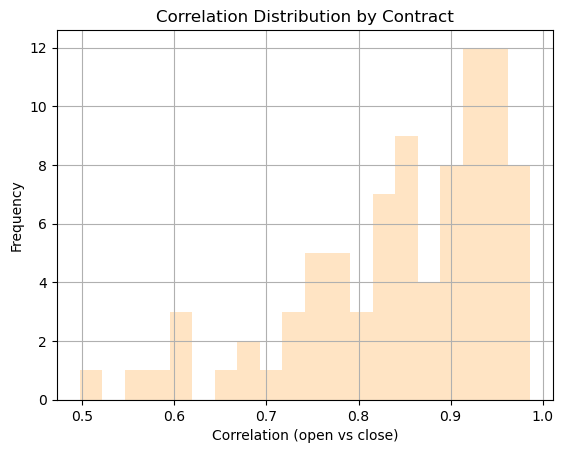

In [1]:
from contract_utilities import contract_diagnosis
import pandas as pd
contract_diagnosis()

In [2]:
ics = pd.read_csv('bigquant_ic.csv')
ics['trading_code'].value_counts().sort_values(ascending = False)

trading_code
IC2406    65
IC2209    65
IC2109    65
IC2509    64
IC2309    64
          ..
IC1910    15
IC1702    13
IC1810    12
IC2010    12
IC2603     9
Name: count, Length: 86, dtype: int64

The main continuous contracts (主力合约) reported by Chinese futures exchanges are constructed as stitched series across successive active contracts. These series are typically adjusted using constant factor multiplication applied uniformly to the OHLC prices at each rollover. The effective lifespan of any individual underlying contract in the continuous series is often limited to roughly two to three months (about 40–60 trading days).

This construction introduces an artificial synchronization across the four price fields (open, high, low, and close), creating a false sense of price “resonance” that does not arise from genuine market microstructure. Such stitching effects dilute subtle technical patterns, distort volatility dynamics, and severely compromise the validity of longer-horizon technical indicators. In particular, indicators with extended lookback windows become structurally unreliable, as their statistical assumptions are violated by repeated rollovers and the resulting artificial price discontinuities, ultimately leading to the generation of spurious trading signals.

中国期货交易所发布的主力连续合约（主力合约）通常是通过将不同时期的活跃合约进行拼接而构造的。在换月时，这类连续合约一般采用对价格比例缩放的方式，对开盘价、最高价、最低价和收盘价（OHLC）进行统一调整。 在连续合约序列中，任一单一标的合约的有效存在周期通常仅为约两到三个月（约 40–60 个交易日）。

这种构造方式在四个价格字段（开盘价、最高价、最低价和收盘价）之间引入了人为的同步调整，从而形成一种并非源自真实市场微观结构的价格“共振”现象。该拼接效应会削弱细微的技术形态、扭曲波动率的动态特征，并显著降低长周期技术指标的有效性。尤其是对于回看窗口较长的指标而言，其统计假设会在反复换月以及由此产生的人为价格不连续性影响下被破坏，最终导致交易信号中出现大量伪信号。

**Session Encoding**

Based on our evaluation of the data pipeline and its structural limitations, we do not adopt the common practice of stacking successive futures contracts into a single continuous time series sorted purely by calendar time. Even when restricting attention to the most active contract, systematic cross-contract differences (ANOVA) can persist.

Instead, we employ a session-based segmentation framework and explicitly identify contract transitions using a roll flag defined as:

df['trading_code'] != df['trading_code'].shift(1)


This roll flag is used to segment the time series into contract-consistent regimes, ensuring that rolling statistics, differencing operators, and stateful transformations are computed strictly within the same contract session.

In principle, a more conservative treatment would exclude a wider buffer around each rollover event to fully eliminate transient effects associated with liquidity migration and pricing adjustments. However, such aggressive filtering is impractical in our setting: the effective sample size is limited (fewer than 3,000 observations), and rollovers occur frequently, so removing large windows would result in a substantial loss of statistical power.

We therefore adopt a minimal-intervention strategy. Only a small number of observations immediately **following**  each rollover are excluded from feature computation. This approach is sufficient to prevent leakage of rollover-induced artifacts into downstream features, while preserving the majority of the usable sample for estimation and evaluation.

在对数据处理流程及其结构性限制进行系统评估后，我们未采用将不同期货合约按时间顺序简单拼接为单一连续序列的常见做法。即使仅使用主力合约，不同合约在交割切换前后仍可能存在系统性差异 (ANOVA 检验)。

为此，我们采用基于 session-based 的分段建模框架，并通过如下规则显式识别合约切换事件：

df['trading_code'] != df['trading_code'].shift(1)

该 roll flag 用于将时间序列划分为合约一致的区间，确保滚动统计、差分算子及其他具有状态依赖性的特征变换均严格在同一合约内计算，从而避免跨合约信息污染。

从理论上讲，更为保守的做法是在每次合约切换前后剔除更大范围的数据窗口，以完全消除流动性迁移和定价调整带来的过渡性影响。然而，在本研究设定下，该方法并不可行：一方面，总体有效样本量有限（不足 3,000 条观测），另一方面，合约切换发生较为频繁，大规模剔除数据将显著削弱统计有效性。

因此，我们采取最小干预原则，仅在合约切换后剔除极少量相邻观测点 (nan mask)，以防止交割相关的人为结构性噪声泄露至特征构建过程中。在不显著牺牲样本规模的前提下，该策略已足以保证特征的稳健性与可解释性。

In [3]:
from contract_utilities import session_encoding
session_encoding('bigquant_ic.csv')
session_encoding('bigquant_if.csv')
session_encoding('bigquant_ih.csv')

try fetching bigquant_ic.csv
Wrote ic_main_day.csv with 2604 rows.
try fetching bigquant_if.csv
Wrote if_main_day.csv with 2604 rows.
try fetching bigquant_ih.csv
Wrote ih_main_day.csv with 2604 rows.


In [4]:
# roll flag 
pd.read_csv('bigquant_ic.csv')[19:21]

date  instrument trading_code    open   close    high     low  \
19  2015-05-14  IC8888.CFE       IC1505  8689.0  8760.4  8813.6  8645.2   
20  2015-05-15  IC8888.CFE       IC1506  8610.0  8579.8  8718.0  8482.0   

    pre_close  volume        amount  open_interest  settle  pre_settle  \
19     8695.8  112711  1.969418e+11           8971  8754.2      8690.8   
20     8603.0  182662  3.134913e+11          28064  8651.4      8593.8   

    upper_limit  lower_limit product_code  
19       9559.8       7821.8           IC  
20       9453.0       7734.6           IC

In [5]:
pd.read_csv('ic_main_day.csv')[19:21]

datetime    open   close    high     low  volume  open_interest  \
19  2015-05-14  8689.0  8760.4  8813.6  8645.2  112711           8971   
20  2015-05-15  8610.0  8579.8  8718.0  8482.0  182662          28064   

    roll_flag  
19          0  
20          1

**Intraday High-Frequency Data Processing**

In [6]:
from contract_utilities import intra_process

When no proprietary factors are included, TA-Lib–based technical indicators often exhibit weak explanatory power, especially when the modeling horizon is shifted to higher-frequency data, where execution slippage and microstructure noise become increasingly significant.

Nevertheless, at the request of Haitong Futures, this research direction is retained for systematic investigation.

Due to the absence of contract-level trading information in the intraday dataset, rollover information is inherited from the daily table. As a result, all intraday bars that fall on a rollover trading day are treated as structurally contaminated and are explicitly flagged to prevent technical indicators from being computed across contract boundaries.

在未引入自有因子的情况下，基于 TA-Lib 的技术指标通常表现出较弱的解释能力，尤其是在将建模周期下移至更高频数据时更为明显。在该情形下，交易执行滑点与市场微观结构噪声的影响显著增强，进一步削弱了传统技术指标的有效性。 尽管如此，应海通期货的要求，本研究仍保留日内研究方向，并对 60 分钟， 30分钟， 15 分钟频率 进行系统性检验。由于日内数据集中缺乏合约层面的交易信息，换月信息由日频数据表继承。因此，所有发生在换月交易日内的日内 K 线均被视为结构性污染数据，并被明确标记，以防止技术指标在不同合约边界之间进行计算。

**Asset Heterogeneity**

In [7]:
from contract_utilities import prepare_then_compare

Futures contracts are tied to fundamentally different underlying assets, which causes their return dynamics to exhibit persistent structural heterogeneity. Even within equity index futures, constituent differences—such as size, sector weights, and liquidity profiles—generate distinct microstructure patterns. As a result, when formulating next-period return forecasting as a machine-learning problem, it is inherently difficult to extract stable and universal trend-following rules across all assets.

Nonetheless, the objective of this project is to maximize generalizability. We adopt a multi-cycle, multi-horizon factor-coding framework, where indicators are constructed across several temporal scales. The working assumption is that if an asset exhibits sustained speculative participation and structural inefficiency, then at least one temporal window will be aligned with its dominant behavioral mode.

期货合约背后的基础资产各不相同，其收益结构也因此呈现出长期且系统性的异质性。即便在股指期货内部，不同指数的成分股在规模、行业权重、流动性上均存在差异，从而导致显著的微观结构差异。因此，当我们将下一周期收益预测视为一个机器学习问题时，想要在所有资产上提取稳定且普适的趋势信号本身就是困难的。

本项目的目标仍然是最大化可泛化性。我们采用多周期、多时间尺度的因子编码框架，在不同周期上构建指标。其基本假设是：如果某个资产具备持续的投机参与和结构性低效，那么一定会有某个时间尺度能够捕捉其主导动态。


| **Concept**                 | **Variable / Formula (Corrected)**                     | **Measures**                    | **Economic Meaning**                                    |                    |                                   |
| --------------------------- | ------------------------------------------------------ | ------------------------------- | ------------------------------------------------------- | ------------------ | --------------------------------- |
| **dOI**               | `open_interest.diff()` *(signed)*                      | Position count change           | Speculator entry/exit; flow pressure; regime shifts     |                    |                                   |
| **Gap**               | `(open - prev_close) / prev_close` → **`abs(gap)`**    | Overnight discontinuity         | News/policy shock sensitivity; execution risk           |                    |                                   |
| **Return r1**          | `log(close_t / close_{t-1})`                           | Total daily movement            | Price discovery; tradable amplitude                     |                    |                                   |
| **Range/Open**        | `(high - low) / open` → always **positive**            | Intraday volatility             | Trading intensity; liquidity stress                     |                    |                                   |
| **ATR20/Close**       | `ATR(20) / close` → **positive**                       | Multi-day volatility            | Market turbulence; friction level                       |                    |                                   |
| **RV10**             | `std(r1, window=10)` → **positive**                    | Local realized vol              | Signal-to-noise environment                             |                    |                                   |
| **ACF(1)**           | `corr(r1, r1.shift(1))` *(signed)*                     | Linear dependence               | Trend-following (positive) vs mean-reversion (negative) |                    |                                   |
| **VR5**              | `var(r5) / (5 * var(r1))` *(positive)*                 | Multi-step dependence           | Persistence (VR>1) or microstructure noise (VR<1)       |                    |                                   |
| **Sign Persistence** | `mean(sign(r1)==sign(r1.shift(1)))` | Directional continuity          | CTA exploitable directional smoothness                  |                    |                                   |
| **Signal-to-Noise**    | `abs(mean(r1)) / std(r1)`           | Drift strength                  | Trend clarity; modelability of momentum                 |                    |                                   |
| **Tail Ratio**        | `quantile(abs(r1), 0.99) / median(abs(r1))`            | Fat-tail severity               | Jump risk; convexity exposure                           |                    |                                   |
| **Jump Prob.**        | `prob(abs(r1) > 3 * std(r1))`                          | Extreme-move frequency          | Shock-driven risk; instability                          |                    |                                   |
| **Roll Frequency**    | `sum(roll_flag) / N`                                   | Contract turnover regularity    | Operational complexity                                  |                    |                                   |
| **Roll Vol Ratio**  | `std(abs(r1_roll)) / std(abs(r1_nonroll))`             | Volatility distortion near roll | Microstructure disturbance                              |                    |                                   |
| **Roll Gap Ratio**   | `median(abs(gap_roll)) / median(abs(gap_nonroll))`     | Price discontinuity during roll | Rollover execution difficulty                           |                    |                                   |

In [8]:
IC,IH,IF = pd.read_csv('ic_main_day.csv'), pd.read_csv('ih_main_day.csv'), pd.read_csv('if_main_day.csv')

                   IC (CSI500)    IH (SSE50)   IF (CSI300)
N                  1940.000000   1870.000000   1884.000000
med_|r1|              0.007311      0.006358      0.006716
p95_|r1|              0.038251      0.029709      0.030595
med_rv10              0.012008      0.010486      0.010561
med_ATR20/Close       0.018105      0.015823      0.015629
med_Range/Open        0.016209      0.013998      0.013877
share_|gap|>0.5%      0.188660      0.224599      0.207006
ACF1_r1               0.046246     -0.030391      0.014926
p_ACF1                0.041658      0.188770      0.517071
ACF5_r1              -0.021292      0.053171      0.025893
VR5                   0.973227      0.931247      0.947968
p_VR5                 0.995633      0.986045      0.990923
z_VR5                -0.005473     -0.017491     -0.011376
skew_r1              -0.564164     -0.007341     -0.240675
kurt_r1               9.224977      9.116042      9.138150
med_volume        23272.500000  22914.500000  35344.5000

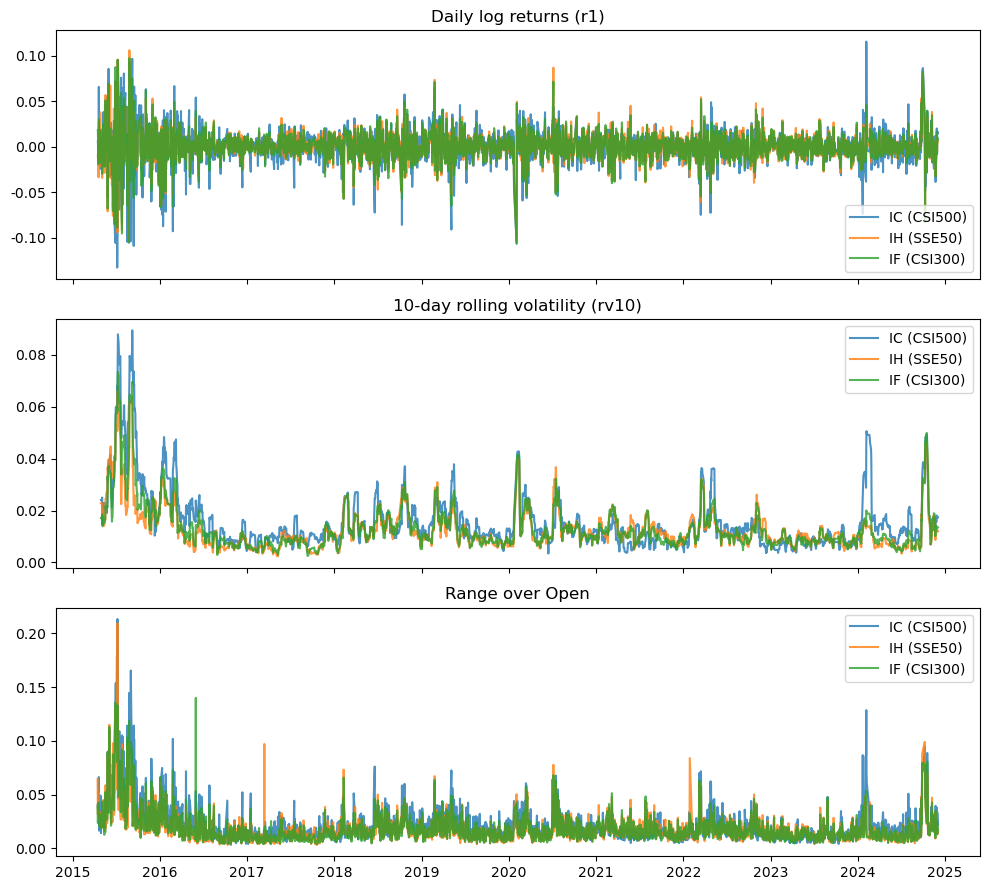

In [9]:
tbl2, prepared2 = prepare_then_compare({'IC (CSI500)': IC, 'IH (SSE50)': IH, 'IF (CSI300)': IF}, train_ratio=0.9)

Across the three index futures—IC (CSI500), IH (SSE50), and IF (CSI300)—daily log returns exhibit a highly synchronized temporal pattern. Volatility spikes tend to occur on the same dates, reflecting shared exposure to systemic macro and policy shocks. This confirms the dominance of a common market-level factor in Chinese equity index futures.

Despite this synchronization, the contracts differ materially in amplitude and microstructure. IC consistently shows the largest return swings, consistent with its small-cap composition and higher beta. IH displays the smoothest behavior, supported by mega-cap constituents and stronger institutional anchoring, while IF lies between the two. Rolling 10-day realized volatility reinforces this stable risk ordering: IC > IF > IH.

Flow dynamics further sharpen these distinctions. IC’s average daily change in open interest is substantially higher than both IF and IH, indicating faster position turnover, stronger speculative participation, and more frequent regime transitions. This aligns with IC’s heavier tails, higher jump probability, and pronounced negative skew. By contrast, IH’s low open-interest variability reflects a more stable, institutionally dominated market with smoother microstructure and weaker short-term amplification. IF again occupies an intermediate regime.

Taken together, IC behaves as a high-beta, flow-sensitive instrument with strong short-horizon dynamics and elevated convexity risk, while IF and IH progressively transition toward more stable and less reactive market structures.

在 IC（中证500）、IH（上证50）与 IF（沪深300）三类股指期货中，日度对数收益在时间结构上高度同步：波动率峰值往往出现在相同日期，反映出它们对宏观与政策冲击的共同暴露。这表明中国股指期货市场中存在显著的系统性共同因子。

尽管时间上同步，三类合约在波动幅度与微观结构上仍存在稳定差异。IC 的收益波动始终最大，符合其中小盘股占比高、β 值较大的特征；IH 由于以超大市值股票为主、机构参与度高，表现最为平稳；IF 则介于两者之间。滚动 10 日波动率清晰地刻画了这一风险排序：IC > IF > IH，且在时间上保持稳定。

从资金与持仓角度看，这一差异更加明显。IC 的日均持仓变动幅度显著高于 IF 与 IH，反映出更快的仓位更替、更强的短期投机参与以及更频繁的状态切换。这与 IC 更厚的尾部、更高的跳跃概率以及更明显的负偏度高度一致。相比之下，IH 的持仓变化极为平缓，体现出以机构资金为主、微观结构更稳定的市场特征；IF 仍处于中间状态。

综合来看，IC 更像是一种高 β、对资金流高度敏感、短期动量与凸性风险突出的交易品种，而 IF 与 IH 则逐步过渡到结构更稳定、反应更温和的市场形态。


=== Loading bigquant_ic.csv ===
Removed 18 artifact intervals: [91.0, 91.0, 89.0, 92.0, 92.0, 91.0, 90.0, 91.0, 92.0, 92.0, 89.0, 99.0, 91.0, 91.0, 91.0, 91.0, 90.0, 91.0]


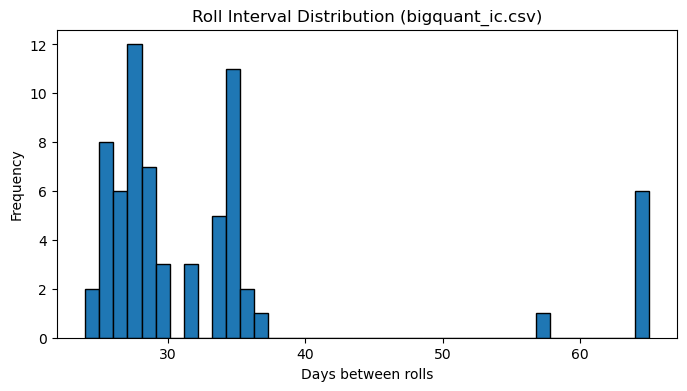


=== Loading bigquant_if.csv ===
Removed 12 artifact intervals: [1.0, 92.0, 91.0, 92.0, 91.0, 96.0, 93.0, 90.0, 92.0, 91.0, 90.0, 91.0]


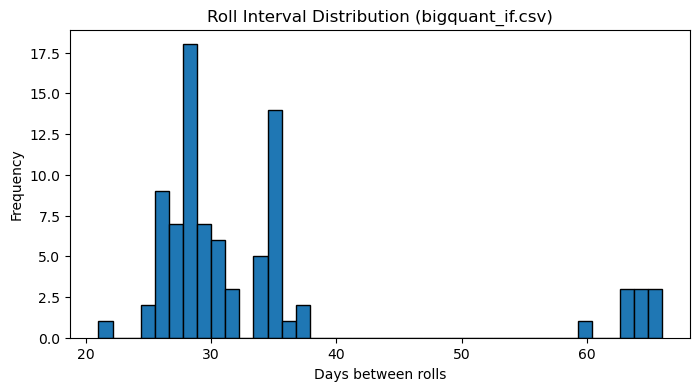


=== Loading bigquant_ih.csv ===
Removed 9 artifact intervals: [92.0, 91.0, 96.0, 94.0, 90.0, 91.0, 91.0, 90.0, 92.0]


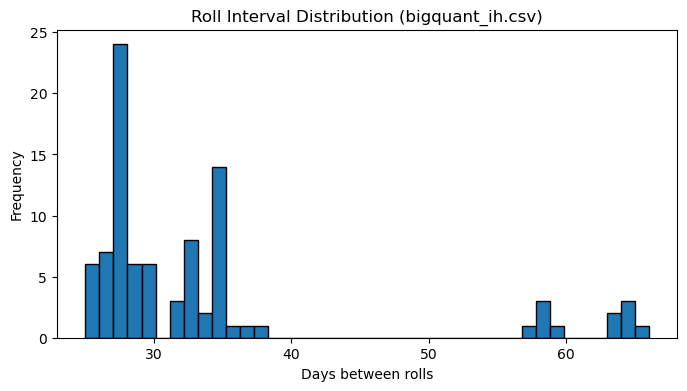

file  n_contracts  avg_contract_len  med_contract_len  \
0  bigquant_ic.csv           86         30.279070              22.0   
1  bigquant_if.csv           98         26.571429              20.5   
2  bigquant_ih.csv          100         26.040000              21.0   

   min_contract_len  max_contract_len  roll_count       mean  median  \
0               9.0              65.0          67  33.626866    29.0   
1               1.0              65.0          85  33.964706    29.0   
2               7.0              66.0          90  34.133333    30.0   

         std   min   q25   q75   max  boundary_load  
0  10.958373  24.0  28.0  35.0  65.0       0.172414  
1  11.464694  21.0  28.0  35.0  66.0       0.172414  
2  10.716154  25.0  28.0  35.0  66.0       0.166667

In [10]:
from factors_robust import contract_roll_structure
ic = contract_roll_structure('bigquant_ic.csv')
if_ = contract_roll_structure('bigquant_if.csv')
ih = contract_roll_structure('bigquant_ih.csv')
pd.DataFrame([ic, if_, ih])

Although IC, IF, and IH differ markedly in liquidity and flow characteristics, their rollover frequencies are statistically indistinguishable. After excluding artifact intervals introduced by contract stitching, all three exhibit rollover spacing concentrated in the 28–35 trading day range, with nearly identical medians and interquartile ranges.

Given this rollover frequency, once the data are segmented by contract, the effective length of each continuous regime is inherently limited. As a result, long rolling windows or multi-span statistics become impractical, regardless of the underlying instrument. 

尽管 IC、IF 和 IH 在流动性与资金流动特征上存在显著差异，但其主力合约换月频率在统计意义上并无明显区别。在剔除由合约拼接机制引入的异常区间后，三者的换月间隔均集中在 28–35 个交易日区间内，中位数与分布范围高度一致。

在这一换月频率水平下，一旦按合约进行分段建模，每个连续样本区间的有效长度本身就受到严格限制。因此，较长的滚动窗口或多跨度统计在分段框架下通常难以实施，且这一约束对所有合约同样存在。

**Evaluations of Factors**

Factor zoo remains a controversial topic of time-series forecasting.

Although tree-based algorithms are often argued to be capable of automatically exploring feature spaces and discarding irrelevant inputs with high efficiency, this does not eliminate deeper structural risks. In practice, the objective of minimizing RMSE is not always aligned with capturing economically meaningful behavior and this misalignment can introduce spurious predictive patterns (a common pattern of flat line with some spikes).

Moreover, when features exhibit extremely high mutual correlation, near-random fluctuations among redundant variables combine with greedy nature of tree algorithm can lead to drastically different tree-growth paths, undermining model stability and interpretability.

Out of these concerns, a robust factor examination framework is necessary to control factor overcrowding, enforce economic consistency, and promote more reliable pattern recognition under time-varying market regimes.

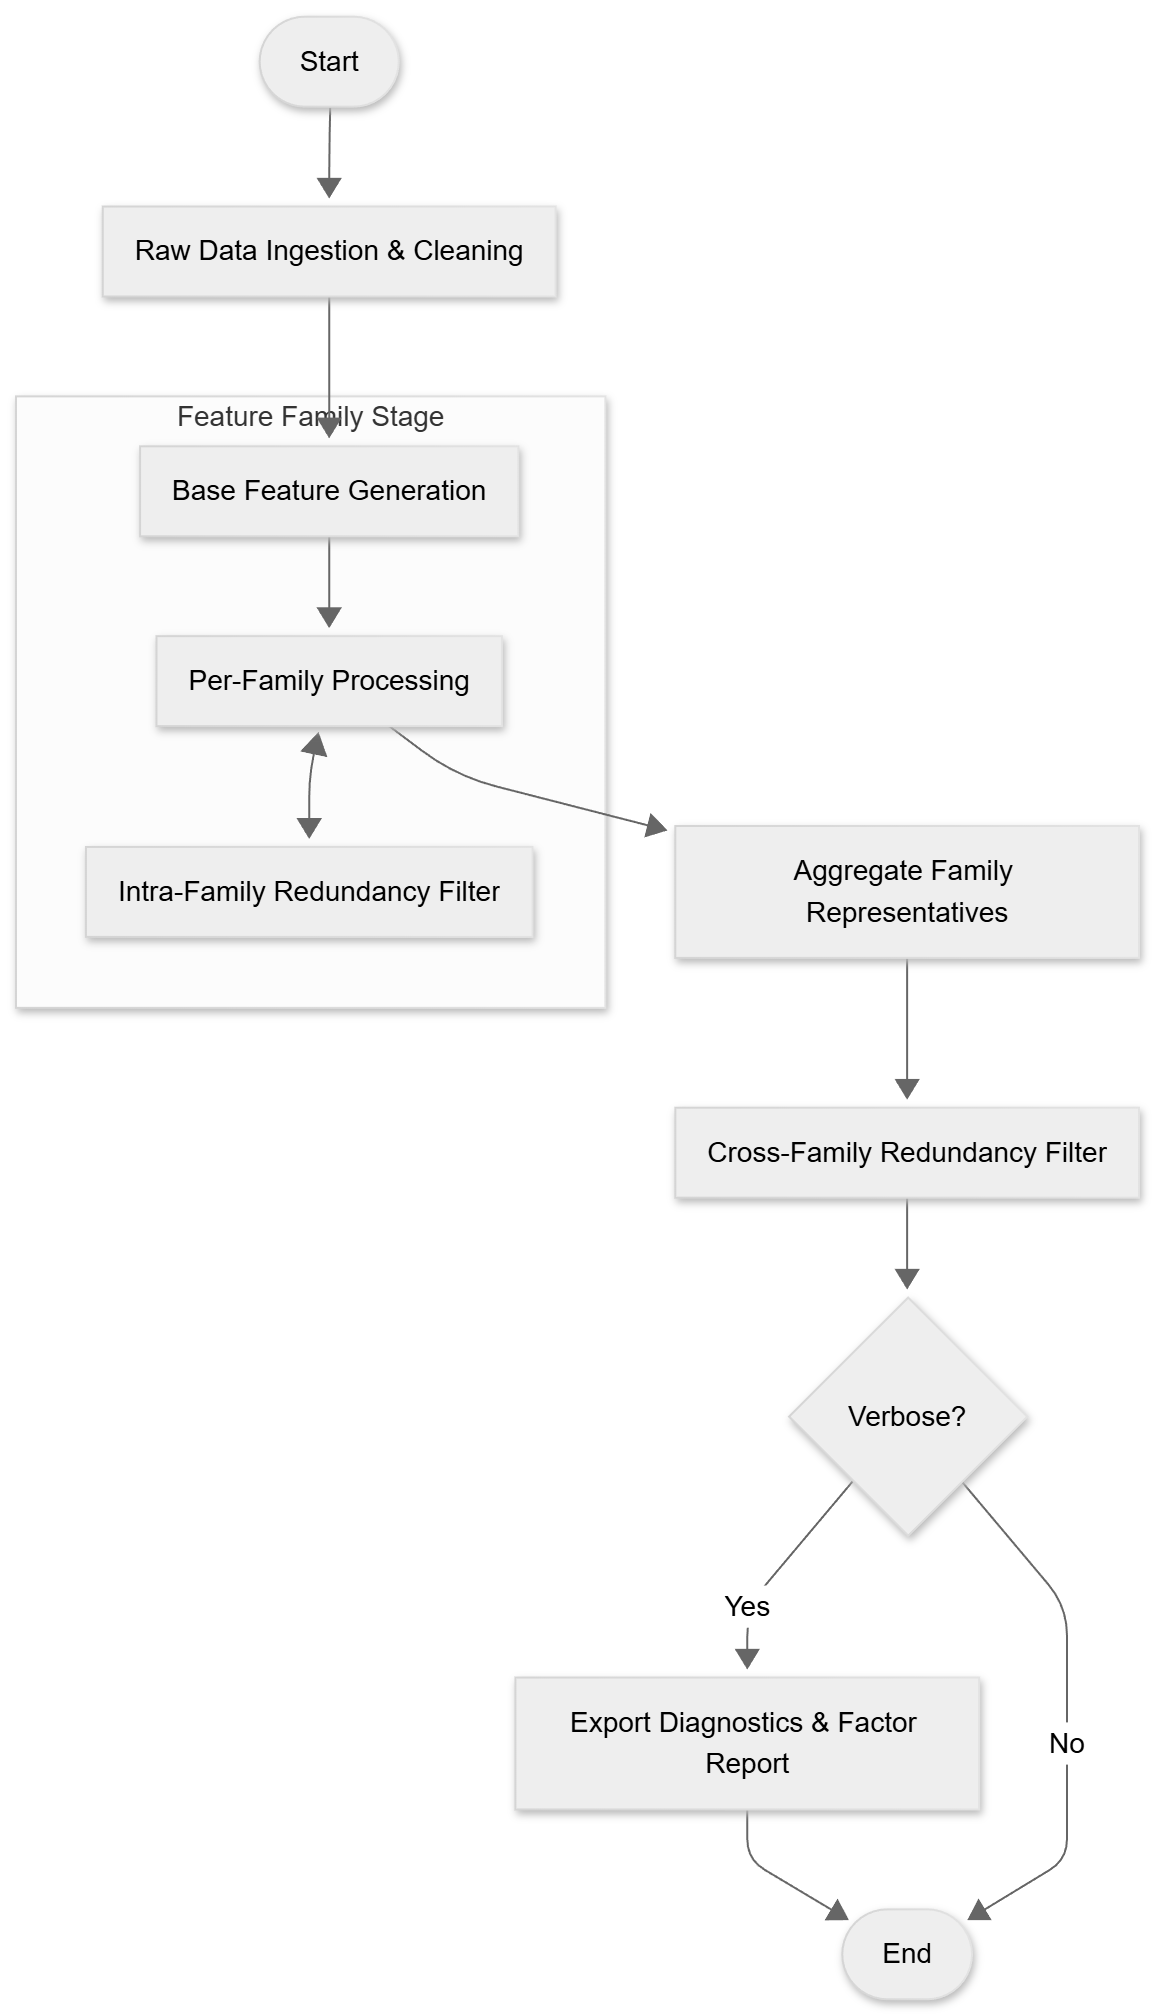


因子堆砌现象（factor zoo）在时间序列预测领域始终是一个存在争议的话题。 尽管树模型算法常被认为能够高效地自动探索特征空间， 并在训练过程中筛除无关输入，但这并不能消除更深层次的结构性风险。

在实际应用中，以最小化 RMSE 为目标的优化过程并不总是与刻画具有经济含义的行为保持一致，这种目标错配往往会引入伪预测结构（典型表现为整体接近水平、仅夹杂少量尖峰的预测形态）。

此外，当特征之间存在极高的相互相关性时，冗余变量之间近似随机的微小波动，与树模型本身的贪婪生长特性相结合，可能导致截然不同的树生长路径，从而削弱模型的稳定性与可解释性。

基于上述考虑，有必要建立一套稳健的因子检验框架，用以控制因子拥挤问题、约束经济一致性，并在市场状态随时间变化的环境中，促进更为可靠的模式识别。

To mitigate factor redundancy and enhance model robustness, we implement a two-stage factor management framework that combines economic intuition with statistical validation.

For factor management and redundancy control, we adopt a factor family framework inspired by common sell-side practices (e.g., UBS-style taxonomy), grouping related signals by their economic intuition and statistical behavior. Within each family, rolling cross-factor correlation is evaluated using up to 90% of the available sample to mitigate lookahead bias.

The 0.9 cutoff is chosen to remain consistent with the subsequent rolling - embargoed cross-validation scheme used in model training. Factors that exhibit persistently high pairwise correlation are treated as functionally redundant and are systematically pruned, in order to control factor overcrowding, reduce instability in tree-based learning, and improve the robustness of pattern extraction.

为降低因子冗余并提升模型的稳健性，我们采用了一套两阶段的因子管理框架，将经济直觉与统计检验相结合。 在因子管理与冗余控制方面，我们借鉴常见卖方研究中的因子家族划分方法（例如 UBS 风格的分类体系），依据因子的经济含义和统计行为，将相关信号归入同一因子家族。

在每个因子家族内部，采用滚动的跨因子相关性评估，并最多使用可用样本的 90%，以降低前窥偏差（look ahead）的风险。选择 0.9 作为截断比例，是为了与模型训练阶段所采用的滚动–禁运（embargoed）交叉验证方案保持一致。对于在时间上持续表现出较高两两相关性的因子，视其在功能上存在冗余，并进行系统性剔除，以控制因子拥挤问题、降低树模型学习过程中的不稳定性，并提升模式提取的稳健性。

To evaluate the overall quality and robustness of each factor, we further construct a composite **QSL (Quality Scoring Level)**  based on the following components:

为评估各因子的整体质量与稳健性，我们进一步构建了一个综合质量评分指标 QSL（Quality Scoring Level），其由以下几个组成部分构成

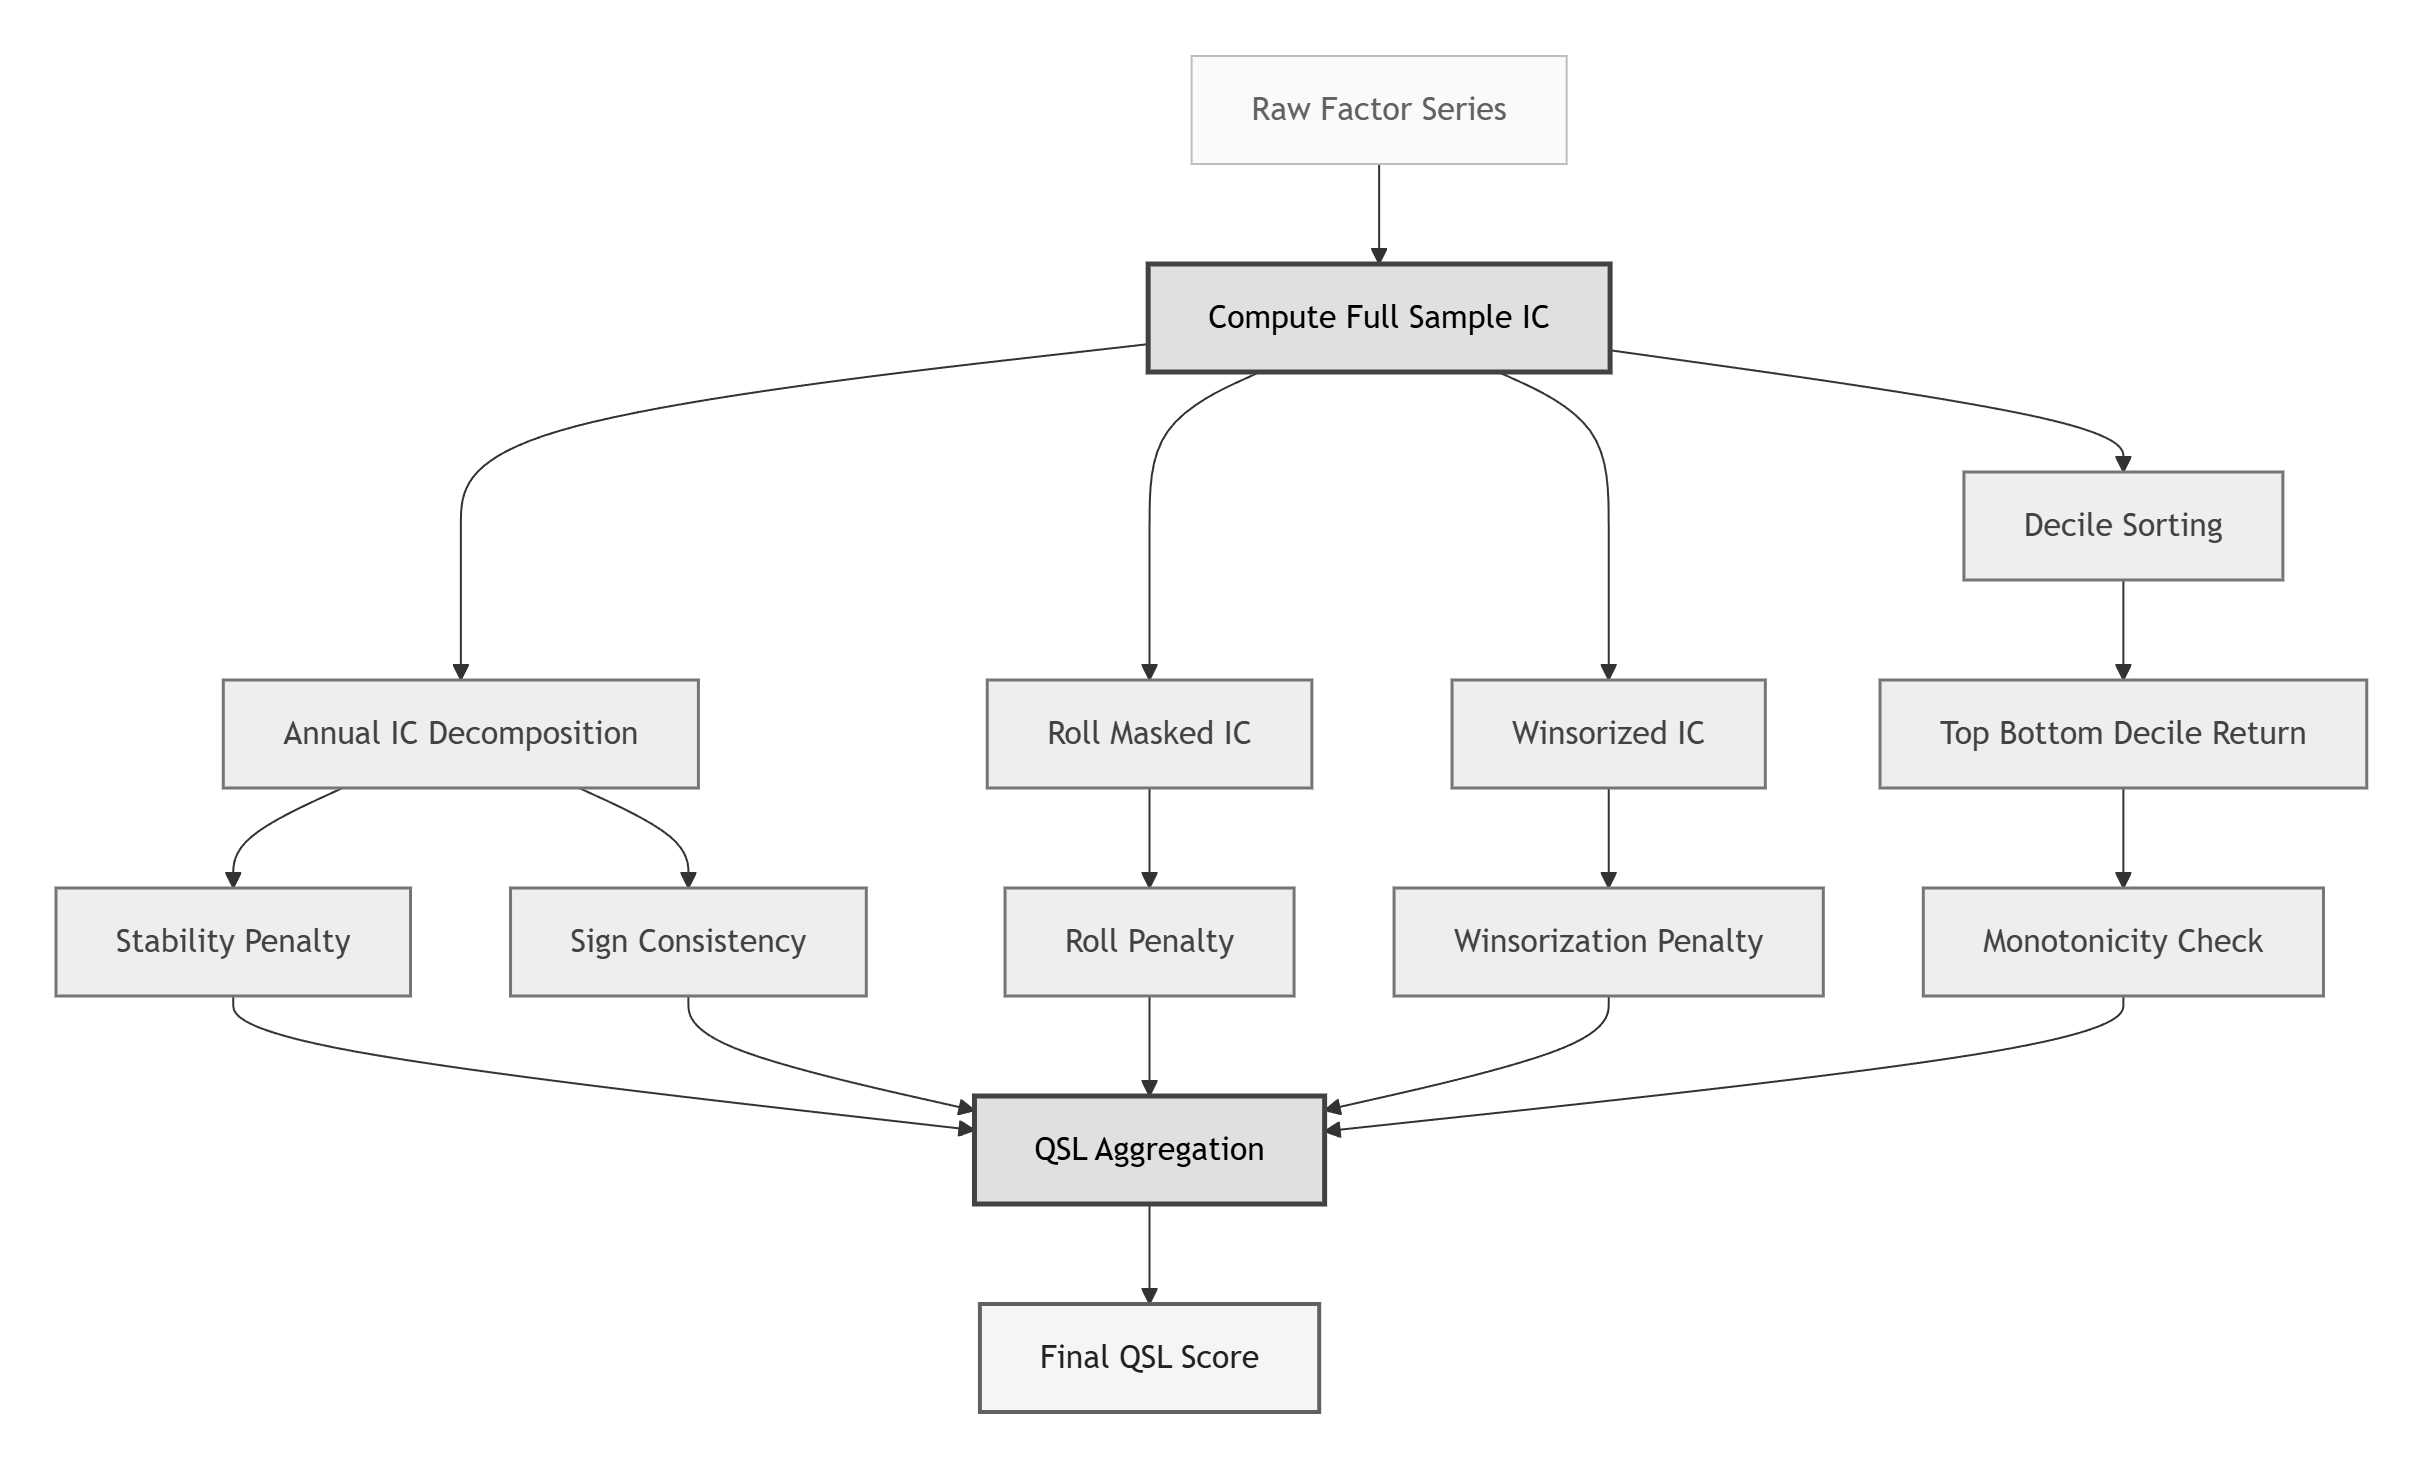

| Component        | Metric                             | Purpose                |
| ---------------- | ---------------------------------- | ---------------------- |
| IC Strength      | Pearson / Spearman / Kendall       | Raw predictability     |
| Stability        | Std of annual Spearman IC          | Time robustness        |
| Roll Penalty     | IC degradation after roll masking  | Roll contamination     |
| Winsor Penalty   | IC degradation after winsorization | Tail dependency        |
| Monotonicity     | Decile long–short return           | Economic validity      |
| Sign Consistency | Share of years with same IC sign   | Directional robustness |
| **QSL**          | Weighted aggregate                 | Fast screening score   |


Although the weighting scheme is partially **heuristic and reflects subjective judgment**, the primary purpose of the QSL is fast **factor screening**. Final selection and allocation decisions are deferred to the downstream algorithmic process.

尽管权重设定在一定程度上具有启发式性质并包含主观判断，但 QSL 的主要用途在于对因子进行快速筛。最终的因子选择与配置决策将交由下游的算法化流程完成。

In [11]:
from factors_technical import treemodel_factors_daily

In [12]:
from factors_robust import treemodel_factors_augment 

#### **Hilbert Transformation**

The Hilbert transformation reflects a modeling view in which asset prices evolve through local cyclical dynamics rather than moving monotonically in a single direction. Even within sustained trends, prices frequently exhibit oscillatory behavior characterized by alternating phases of acceleration, deceleration, drawdown, and rebound. These recurring structures form the basis of what we refer to as market cycles.

The Hilbert transformation is designed to extract key attributes of such cycles, most notably the instantaneous phase and dominant cycle period, which together characterize the market’s local rhythmic state. These quantities provide a compact description of regime transitions and changes in market tempo that are not easily captured by time-domain indicators alone.

In continuous main-contract series construction, earlier contracts are typically back-adjusted to align with later ones. While this procedure ensures price continuity, it introduces time-varying scale distortions: price fluctuations in earlier periods are mechanically rescaled, making absolute price changes non-comparable across time. This effect is particularly problematic for amplitude-sensitive technical indicators and frequency-domain methods.

Applying the Hilbert transformation to log prices partially mitigates this issue. The log transformation converts multiplicative price dynamics into an additive structure, compressing proportional differences introduced by contract stitching into level shifts rather than scale changes. As a result, cycle-related quantities such as phase and instantaneous frequency become more stable and interpretable across contracts.

Finally, this formulation is naturally aligned with our modeling objective, which focuses on predicting log returns rather than raw price changes, ensuring internal consistency between feature construction and target definition.

Hilbert 变换反映了一种建模视角：资产价格并非以单一方向单调演化，而是呈现出局部的周期性动态。即便在持续的趋势行情中，价格也往往表现出振荡结构，交替经历加速、减速、回撤与反弹等阶段。这类反复出现的结构构成了本文所称的“市场周期”。

Hilbert 变换旨在刻画此类周期的关键属性，尤其是瞬时相位（instantaneous phase）与主导周期长度（dominant cycle period）。二者共同描述了市场在局部时间尺度上的节律状态，为刻画市场节奏变化与状态切换提供了一种紧凑而有效的表示方式，这些信息通常难以通过传统时域指标直接捕捉。

在主力合约连续序列的构建过程中，通常会通过向后平移（back-adjustment）的方式将早期合约价格对齐至后续合约，从而保证价格序列的连续性。然而，该处理方式会引入随时间变化的尺度扭曲：早期样本中的价格波动被机械性地重新缩放，导致不同时期的绝对价格变动在经济意义上不再具备可比性。这一问题对依赖幅度信息的技术指标，尤其是频域方法，影响尤为显著。

将 Hilbert 变换应用于对数价格可以在一定程度上缓解上述问题。对数变换将价格的乘性动态转化为**加性结构**，使由合约拼接引入的比例差异表现为水平位移而非尺度变化。由此，诸如相位与瞬时频率等周期相关量在不同合约之间表现得更加稳定且易于解释。

最后，该处理方式与本文的建模目标天然一致。由于模型以对数收益而非原始价格变动作为预测对象，在特征构建阶段采用对数价格能够确保特征空间与目标变量之间在形式与经济含义上的一致性。

**Circular Difference**

For angular data, differences must respect the circular nature of degrees. A naïve subtraction can easily lead to misleading conclusions—for example, treating 358° as being far from 0°, even though they are only 2° apart on the circle.

To address this, we apply a circular difference transformation, mapping all angular changes into a hand-fan–shaped interval from −180° to +180°. This ensures that all degree differences are measured along the shortest arc on the circle, preserving true geometric proximity.

对于角度型数据，其差分计算必须尊重角度的环状特性。若直接进行简单相减，容易产生误导性的结果——例如，将 358° 视为与 0° 相距甚远，尽管二者在圆周上的实际间隔仅为 2°。

为此，我们采用环形差分（circular difference）变换，将所有角度变化映射至 −180° 到 +180° 的扇形区间内。该处理方式确保所有角度差异均沿圆周上的最短弧度进行度量，从而保留真实的几何邻近关系。

**Roll Awareness in Computation**

In feature construction, we adopt a forward-only roll padding scheme: a small number of observations immediately following each contract rollover are excluded from feature computation. This asymmetric design reflects production constraints. While future rollover events are not observable ex ante, post-roll bars can be reliably identified in real time and treated conservatively. As a result, features are never computed using observations that may still be contaminated by transient effects associated with contract switching.

By contrast, the roll-penalty calculation in QSL employs a centered exclusion window around rollover events. This choice is intentional and purely diagnostic in nature. Unlike feature construction, which must strictly respect causal availability, QSL operates as an ex post evaluation tool. Centered masking provides a symmetric stress test of whether a factor’s apparent predictive performance is disproportionately driven by observations in the immediate vicinity of contract rollovers, independent of any production-time information constraints.

All features are further shifted by one bar to eliminate any potential look-ahead bias. The combined effect of roll masking, segmentation, and lagging naturally increases the proportion of missing values, particularly for rolling-window operators. Given the finite lifespan of individual contracts, rolling windows longer than approximately 7–10 bars frequently span roll boundaries or exceed segment length, leading to excessive data attrition. We therefore restrict cycle- and momentum-related indicators to short horizons to preserve statistical reliability and avoid distortions from aggressive imputation.

Importantly, the roll-penalty metric adopted in this study serves a distinct and deliberately limited purpose. It is not intended to determine whether a factor is structurally free of roll effects. Instead, it assesses whether a factor’s measured predictive performance depends on observations in the vicinity of contract rollovers. For diagnostic symmetry, the roll-penalty test applies a centered exclusion window around rollover events when recomputing rank correlations.

By construction, a roll penalty is recorded only when removing roll-adjacent observations leads to a deterioration in global rank correlation. If the exclusion of these samples leaves the correlation unchanged—or improves it—the roll penalty is explicitly defined to be zero. Consequently, a zero roll penalty should not be interpreted as evidence that a factor is unaffected by roll mechanics, but rather that its predictive signal is not materially supported by roll-adjacent observations.

This distinction is particularly relevant for factors such as DC_Period_Slope_5, which are derived from Hilbert-based cycle estimates combined with inter-temporal differencing. Without explicit segmentation, such constructions almost inevitably experience state crossover near contract boundaries. However, if roll-adjacent samples contribute little—or even negatively—to the overall rank correlation, their removal does not weaken predictive performance. In such cases, a zero roll penalty indicates robustness of the signal source, not the absence of structural roll disturbances.

Accordingly, roll penalty is treated as a conservative relative diagnostic, used to identify whether a factor’s apparent predictability relies disproportionately on roll-adjacent observations. **It is interpreted jointly with sign consistency and rank-based correlation measures to assess overall factor quality, rather than as a definitive indicator of absolute roll safety**.

在因子构建阶段，我们采用仅向前的换月填充（forward-only roll padding）策略：在每次主力合约切换之后，主动剔除紧随其后的少量观测点，**不参与因子计算**。这种非对称设计源于实际生产约束——未来的换月事件在事前不可观测，而换月之后的交易日则可以在实时环境中被可靠识别并进行保守处理。因此，所有因子均不会使用可能仍受到合约切换瞬时扰动影响的观测值进行计算。

与此相对，QSL 中的换月惩罚（roll penalty）计算采用了以换月点为中心的对称剔除窗口。这一设计是有意为之，且完全用于事后诊断目的。不同于因子构建阶段必须严格遵守因果可得性的要求，QSL 作为一种事后评估工具，不受实时信息约束。采用居中剔除窗口可以对因子表观预测能力是否过度集中于换月附近样本进行对称性压力测试，从而独立于生产环境的信息限制，评估其对换月效应的敏感性。

此外，所有因子均整体向后滞后一根 K 线，以消除任何潜在的前视偏差。换月掩码、分段处理以及统一滞后操作的叠加效应，必然会提高缺失值（NaN）的比例，尤其对于滚动窗口类算子而言更为明显。鉴于单一合约的生命周期有限，当滚动窗口长度超过约 7–10 根 K 线时，窗口往往会跨越换月边界或超出有效分段长度，导致有效样本大量流失。基于这一考虑，我们将周期类与动量类指标限制在较短的时间尺度内，以维持合理的样本密度，避免因过度插补长窗口统计量而引入统计失真。

需要强调的是，本文采用的换月惩罚指标具有明确且刻意受限的功能定位。该指标并不旨在判断某一因子是否在结构上完全不受换月效应影响，而是用于评估该因子观测到的预测能力是否依赖于换月附近的样本。出于诊断对称性的考虑，换月惩罚在重新计算秩相关系数时，对换月点前后采用居中剔除窗口。

从定义上看，仅当剔除换月相邻样本导致整体秩相关显著下降时，才会记录换月惩罚；若剔除这些样本后相关性保持不变，甚至有所提升，则换月惩罚被显式定义为零。因此，零换月惩罚不应被解读为因子完全不受换月机制影响，而应理解为该因子的预测信号并未实质性地依赖于换月附近的观测值。

这一点对于诸如 DC_Period_Slope_5 这类基于 Hilbert 周期估计并结合时间差分算子的因子尤为重要。在缺乏明确分段处理的情况下，此类构造几乎不可避免地会在合约边界附近产生状态交叉与结构性扰动。然而，如果换月相邻样本对整体秩相关的贡献较小，甚至为负，则剔除这些样本并不会削弱因子的预测能力。在这种情形下，零换月惩罚反映的是信号来源的稳健性，而非结构性换月扰动的不存在。

因此，换月惩罚被视为一种保守的相对诊断指标，用于识别因子的表观可预测性是否过度依赖换月附近样本。**该指标需与方向一致性（sign consistency）以及基于秩的相关性度量共同解读，用于综合评估因子质量，而不应被视为衡量因子绝对“换月安全性”的决定性标准**。

**Comparison Class**

To create a baseline, we build a relatively simple factor class that treats the futures contract as a continuous series and applies TA-Lib directly on it. This is used to check whether our feature-engineering pipeline actually delivers better performance.

Admittedly, the engineered library contains many more factors than this comparison class, so the setup is not “perfectly fair” in terms of factor count. However, evaluating relative proportions (e.g. share of effective signals) against this simple baseline is still a reasonable and informative design choice.

为构建基准模型，我们设计了一个相对简单的因子类，将期货主力合约视为一条连续时间序列，并直接在其上应用 TA-Lib 技术指标。该基准主要用于检验所构建的特征工程流程是否能够在整体层面带来系统性的性能改进。

需要说明的是，与该基准因子类相比，工程化因子库在因子数量和结构复杂度上均显著更高，因此在因子数量维度上并非严格意义上的“完全公平”比较。然而，本研究并不关注绝对因子数量或单因子最优表现，而是通过对比有效信号占比等相对指标，评估不同特征构建范式在信息提取效率上的差异。因此，与简单基准的对照仍然具有明确的诊断意义和参考价值。

**Rotation of time series**

In the Hilbert analytic signal framework, phase rotation is defined in a counterclockwise direction on the complex plane. Under this convention, the cosine component primarily reflects the directional projection of the cycle, while the sine component captures the positional state within the cycle.

Empirically, in many financial time series, the right half of the analytic cycle—corresponding to phases where the cosine component is positive—tends to align with regimes characterized by forward expansion, upward drift, and reduced mean-reversion pressure. Conversely, the left half of the cycle is more frequently associated with deceleration, consolidation, or corrective dynamics.

It should be emphasized that this correspondence is phenomenological rather than structural: the Hilbert phase does not impose economic directionality by construction, but provides a geometric decomposition whose interpretation depends on empirical alignment with price dynamics.

在 Hilbert 解析信号框架下，周期相位在复平面上以逆时针方向旋转。在这一几何约定中，余弦分量（cosine）主要反映周期在方向维度上的投影，而正弦分量（sine）刻画当前所处的周期位置状态。

在大量金融时间序列的经验观察中，解析周期的右半区间（即余弦分量为正的相位区域）往往更容易与价格的扩张性行为相对应，包括向前推进的漂移特征以及相对较弱的均值回复压力；相对地，周期左半区间则更常与减速、盘整或修正性动态相关联。

需要强调的是，这种对应关系是经验性的而非结构性的。Hilbert 相位本身并不在构造上内生任何经济方向含义，而是提供了一种几何分解方式，其经济解释依赖于与实际价格行为的统计一致性。

#### **Featurs Design**

Given a price series, TA-Lib provides the Hilbert Transform tools HT_DCPERIOD, HT_TRENDMODE, and HT_DCPHASE, which respectively estimate the dominant cycle period, classify the state as trending vs cyclic, and give the current phase (in degrees).

Building on these quantities, we design a set of cycle-related factors around the following idea:

给定一条价格序列，TA-Lib 提供了希尔伯特变换相关工具 HT_DCPERIOD、HT_TRENDMODE 和 HT_DCPHASE，分别用于估计主导周期长度、判断当前状态是趋势型还是周期型，以及给出当前所处的相位（以角度表示）。 基于上述量，我们围绕以下核心思想设计了一组与周期相关的因子：

**Large and abrupt changes** in the estimated Hilbert phase indicate instability of the local cycle representation. Such phase instability typically arises when the market departs from a smooth oscillatory regime—commonly around overbought/oversold extremes, trend initiation or termination, and episodes of violent oscillation.
While these conditions reduce the reliability of the instantaneous cycle estimate, they may themselves carry predictive information as indicators of regime transition or structural change

Hilbert 相位的剧烈跳变通常反映的是局部周期假设的不稳定性。 此类相位不稳定往往出现在市场偏离平稳振荡结构的阶段，例如超买超卖区间、趋势启动或终止，以及高振幅快速震荡时期。尽管此时瞬时周期估计的可靠性下降，但相位跳变本身可作为市场状态转换或结构性变化的重要诊断信号。

| Factor | Definition | Measures | Interpretation |
|----------|-----------|----------|----------------|
| Phase Velocity | k-step circular phase difference / k, EMA-smoothed | Cycle rotation speed | How fast the local cycle is evolving |
| Phase Acceleration | k-step difference of phase velocity, EMA-smoothed | Change in rotation speed | Cycle compression / expansion dynamics |
| Phase Velocity Z-Score | Z-score of phase velocity | Instability intensity | Degree of abnormal cycle dynamics |
| Phase Jump Flag | 1-step phase change > 90° or velocity z-score > threshold | Structural break indicator | Regime transition / cycle failure |
| Cycle–Trend Agreement | sign(price_slope₅) × sign(phase_cos) | Behavioral consistency | Whether price action conforms to cycle direction |


**Period Instability**

Similarly, instability in the estimated dominant cycle period may also carry predictive information. Period instability reflects a more severe form of market disruption, in which the underlying cycle itself begins to deform rather than merely oscillate around a stable rhythm.

Large and abrupt changes in the Hilbert-estimated period typically signal shifts in the underlying market structure, such as regime transitions, volatility expansion, or the breakdown of a previously stable cyclic pattern. 

类似地，主导周期长度估计值的不稳定性同样可能蕴含预测信息。周期不稳定性通常反映的是更为剧烈的市场冲击，即基础周期结构本身开始发生形变，而非仅仅围绕既有节奏出现轻微波动。当希尔伯特方法估计得到的周期长度出现大幅且突发的变化时，往往意味着底层市场结构正在发生转变，例如状态切换、波动率扩张，或原本稳定的周期结构发生破裂。

| Factor                      | Definition                                                                                       | Measures                                                 | Interpretation                                                                                                                                                                                                      |
| ----------------------------- | --------------------------------------------------------------------------------------------------- | ---------------------------------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| DC_Period_CV            | Rolling std divided by rolling mean of the Hilbert-estimated dominant cycle period                  | Relative dispersion of the inferred cycle length                 | High values indicate that the estimated cycle length is unstable rather than persistent, signaling fragility in the underlying cyclical structure and reduced reliability of cycle-based signals                             |
| Period_zscore             | First difference of the estimated period, normalized by its rolling standard deviation              | Abrupt stretching or compression of the cycle                    | Large absolute values reflect sudden deformation of the dominant cycle, often associated with volatility regime shifts, trend initiation, or trend termination                                                               |
| Cycle_Structure_Break    | Rolling correlation between instantaneous frequency (inverse period) and absolute phase change rate | Consistency between phase evolution and inferred cycle frequency | A sharp drop in correlation indicates that phase dynamics are no longer aligned with the inferred cycle frequency, signaling a structural breakdown of the cycle model                                                       |
| Multi-Cycle Period Slopes| Differences of the estimated period over short, medium, and long horizons                           | Directional drift of the dominant cycle length                   | Positive slopes indicate gradual cycle stretching (volatility compression, trend exhaustion, range-bound transition); negative slopes indicate cycle compression (volatility expansion, trend ignition, regime reactivation) |


**Regime**

While the phase- and period-based diagnostics characterize where the market is within a Hilbert cycle and how stable that cyclical structure is, they do not directly describe how price is moving through the cycle or what behavioral regime that motion represents. To address this, we introduce a compact set of regime indicators constructed from phase velocity, trend sign, and their interaction. These features translate abstract cycle geometry into economically interpretable market states, such as directional expansion, deceleration, or reversal-prone regimes.

相位与周期相关的诊断指标刻画了市场在希尔伯特周期中的位置以及该周期结构本身的稳定性，但它们并不能直接反映价格是如何沿着该周期运行的，也难以明确描述这种运行方式所对应的行为状态或市场机制。为此，我们进一步构建了一组简洁的状态因子，基于相位速度、趋势方向及其交互关系，将抽象的周期几何信息转化为具有经济含义的市场状态刻画，例如方向性扩张、减速运行或易于反转的阶段。

| Factor                       | Definition                                            | Activated When                   | Interpretation                                                                                                                                                                                                                                                                                                                                           |
| ---------------------------- | ----------------------------------------------------- | -------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Cycle_Regime (Alignment) | trend_signed × sign(Phase_Cos)                  | {+1, −1, NaN}                    | **Cycle–regime alignment indicator.** +1 indicates that the Hilbert-inferred regime (trend vs. cycle) is internally consistent with phase geometry (e.g., trend mode in right half-cycle, or cycle mode in left half-cycle). −1 indicates tension or mismatch between regime classification and phase position. NaN reflects unreliable phase estimates. |
| Cycle_Fast_Up            | Phase_Velocity > 0 & vel_strength_norm > 1.5     | Fast forward rotation            | Impulsive upward phase rotation, typically associated with breakout attempts, short-covering rallies, or upside volatility expansion.                                                                                                                                                                                                                    |
| Cycle_Fast_Down          | Phase_Velocity < 0 & vel_strength_norm > 1.5     | Fast backward rotation           | Aggressive downside phase rotation, often observed during liquidation waves, stop cascades, or downside volatility spikes.                                                                                                                                                                                                                               |
| Cycle_Slow              | vel_strength_norm < 0.5                             | Slow rotation                    | Low-energy, grinding cycle evolution; the cycle is present but evolves too slowly to act as a primary trading driver.                                                                                                                                                                                                                                    |
| Cycle_Turning_Point      | sign(Phase_Velocity_t) ≠ sign(Phase_Velocity_{t−1}) | Velocity sign flip               | Local rotational inflection of the analytic cycle; frequently occurs near micro-tops, micro-bottoms, or regions of high curvature where phase rotation stalls and reverses.                                                                                                                                                                              |
| Cycle_Enhanced_Reversal  | Phase_Cos > 0.8 & Phase_Velocity < 0              | High phase + backward rotation   | Elevated cycle position undergoing mechanical deceleration or folding, commonly associated with momentum exhaustion and the early emergence of mean-reversion pressure.                                                                                                                                                                                  |
| Cycle_Enhanced_Momentum  | Phase_Cos < 0 & Phase_Velocity > 0               | Low phase + forward acceleration | Early momentum ignition emerging from compression; phase geometry supports expansion and sustained directional follow-through.                                                                                                                                                                                                                           |





**CSI 500 Index Futures**

In [13]:
from factors_robust import plot_ic_compare_two_panel, plot_roll_penalty_compare_two_panel

In [14]:
from factors_utilities import corr_check, factor_summary
print('Robust Version: Modeling on Log Close')
corr_check(family = 'cycle', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 25/26 features (≥ 55%, n_eff ≥ 200); median coverage=87.28%, median n_eff=2045
[coverage] removed 1 by coverage/n_eff. e.g., DC_Period_Slope_LongCycle
Pearson Effective 40.00%
Spearman Effective 48.00%
Kendall Effective 28.00%
[selection] kept 8/25 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=25): 44.00%
roll_penalty     > 0.10 (all features, n=25): 0.00%


pearson  spearman   kendall  effective_pct  \
DC_Period_CV               -0.058218 -0.047937 -0.031930       1.000000   
Phase_Sin                  -0.018839 -0.028466 -0.019006       1.000000   
Phase_Velocity             -0.058453 -0.034226 -0.023352       1.000000   
Phase_Acceleration         -0.047248 -0.041205 -0.027914       1.000000   
Phase_zscore               -0.021506 -0.020087 -0.013338       0.666667   
Price_Phase_Same_Direction  0.000832 -0.020470 -0.016718       0.666667   
Cycle_Trend_Agreement      -0.029418 -0.027652 -0.022570       1.000000   
Phase_Signal_Reliable       0.014010  0.027640  0.022573       0.666667   

                            year_spearman_min  year_spearman_max  \
DC_Period_CV                        -0.189364           0.033451   
Phase_Sin                           -0.117021           0.083651   
Phase_Velocity                      -0.092037           0.011375   
Phase_Acceleration                  -0.186645           0.060577   
Phase_zscore                        -0.189420           0.058140   
Price_Phase_Same_Direction          -0.094597           0.113655   
Cycle_Trend_Agreement               -0.131693           0.029007   
Phase_Signal_Reliable               -0.028479           0.116488   

                            sign_consistency  roll_penalty  winsor_penalty  \
DC_Period_CV                             0.7           0.0        0.002359   
Phase_Sin                                0.8           0.0        0.000000   
Phase_Velocity                           0.8           0.0        0.000000   
Phase_Acceleration                       0.7           0.0        0.000000   
Phase_zscore                             0.6           0.0        0.000102   
Price_Phase_Same_Direction               0.7           0.0        0.000000   
Cycle_Trend_Agreement                    0.7           0.0        0.000000   
Phase_Signal_Reliable                    0.6           0.0        0.000000   

                            decile_LS_signed  decile_long_return  \
DC_Period_CV                        0.004706           -0.003297   
Phase_Sin                           0.002228           -0.000801   
Phase_Velocity                      0.004141           -0.002394   
Phase_Acceleration                  0.005048           -0.002455   
Phase_zscore                        0.000755            0.000026   
Price_Phase_Same_Direction               NaN                 NaN   
Cycle_Trend_Agreement                    NaN                 NaN   
Phase_Signal_Reliable                    NaN                 NaN   

                            decile_short_return       QSL  
DC_Period_CV                           0.001409  0.468589  
Phase_Sin                              0.001428  0.458912  
Phase_Velocity                         0.001747  0.556776  
Phase_Acceleration                     0.002593  0.470193  
Phase_zscore                           0.000781  0.453008  
Price_Phase_Same_Direction                  NaN  0.450000  
Cycle_Trend_Agreement                       NaN  0.450000  
Phase_Signal_Reliable                       NaN  0.450000

In [15]:
corr_check(family = 'cycle', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=208, cols=11)
target 1 period next return created
[coverage] kept 8/8 features (≥ 55%, n_eff ≥ 200); median coverage=97.31%, median n_eff=2279
Pearson Effective 12.50%
Spearman Effective 12.50%
Kendall Effective 12.50%
[selection] kept 0/8 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=8): 62.50%
roll_penalty     > 0.10 (all features, n=8): 50.00%


Empty DataFrame
Columns: [pearson, spearman, kendall, effective_pct, year_spearman_min, year_spearman_max, sign_consistency, roll_penalty, winsor_penalty, decile_LS_signed, decile_long_return, decile_short_return, QSL]
Index: []

Compared with the raw TA-Lib baseline, the roll-aware segmented Hilbert factor library exhibits a clear and systematic improvement in signal quality. The distribution of absolute Spearman information coefficient (IC) shifts materially, with the proportion of factors exceeding 
∣IC∣>0.02 increasing from 25% to 40%. This improvement is broad-based rather than driven by a small number of outliers, and is consistently observed across period, phase-velocity, and phase-acceleration feature families.

The underlying mechanism is segmentation-aware phase modeling. By enforcing segmentation at contract roll boundaries, the sign of factors mostly remain consistent within each segment. On top of this stabilized phase representation, all phase-difference features are computed using circular differences that respect the angular geometry of the Hilbert phase. This avoids artificial discontinuities at the 0∘/360∘ boundary and allows phase velocity and acceleration—constructed from first- and second-order phase differences—to exhibit improved temporal coherence and statistical stability.

To improve generalization, the regime state space is further expanded to capture multi-cycle, geometry-driven behaviors, including phase–regime alignment, fast and slow rotational states, turning points, and enhanced momentum or reversal configurations derived from phase and phase velocity. These regime states are designed to describe structural cycle dynamics rather than optimize short-horizon return predictability. 

As a result, they naturally exhibit weaker marginal Spearman IC and impose a structural headwind in markets such as the CSI 500 (IC) index, which tends to favor faster-moving signals. 

Nevertheless, retaining these structurally informative states does not increase roll sensitivity: even under this richer and more expressive regime decomposition, the proportion of factors exhibiting non-zero roll penalty remains at 0% (a relative figure than absolute see result section for more), while the effective Spearman IC ratio is maintained at 40%. In this context, the observed IC performance is particularly notable, confirming that the redesign of the cycle-based factor library represents a substantive structural improvement driven by roll-aware, geometrically consistent, multi-cycle modeling rather than IC-driven pruning or over-optimization.

与原始 TA-Lib 基线相比，具备换月感知的分段 Hilbert 因子库在信号质量上表现出清晰且系统性的提升。绝对 Spearman 信息系数（IC）的分布整体上移，
∣IC∣> 0.02  的因子占比由 25% 提升至 40%。这一提升并非由少数极端因子驱动，而是稳定地体现在相位周期、相位速度与相位加速度等特征族中。

其核心机制在于分段感知的相位建模。通过在合约换月处强制分段，因子的正负符号在各自分段内基本保持一致性。在此稳定的相位表示基础上，所有相位差特征均采用圆周差分（circular difference）计算，显式遵循相位的角度几何结构，避免 0∘/360∘ 边界处的人为跳变，使由一阶与二阶相位差构造的相位速度与相位加速度在时间上更加连续、统计上更加稳定。

为提升泛化能力，状态空间进一步扩展，以刻画多周期、几何结构衍生的行为模式。 这些状态均由相位与相位速度构造而成旨在描述周期结构本身，而非针对短周期收益预测进行优化，因此在设计上天然呈现较弱的边际 Spearman IC，并在以中证500（IC）为代表、偏好快速变化信号的市场环境中形成结构性不利因素。

即便如此，在更丰富、更具表达力的状态分解下，其引入并未放大换月敏感性：非零 roll penalty 的因子占比仍保持为 0% (相对而非绝对指标见 result section），同时有效 Spearman IC 比例稳定在 40%。在这一背景下，该结果本身即具有显著意义，表明周期因子体系的重构属于实质性的结构改进，其优势来源于换月感知、符合相位几何结构的多周期建模，而非基于 IC 指标的过度筛选或优化。

target 1 period next return created


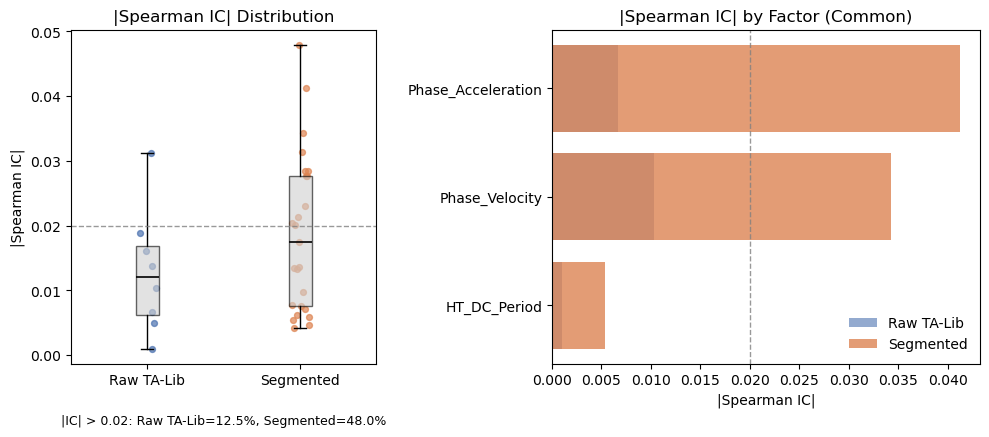

In [16]:
s_raw = (corr_check(family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


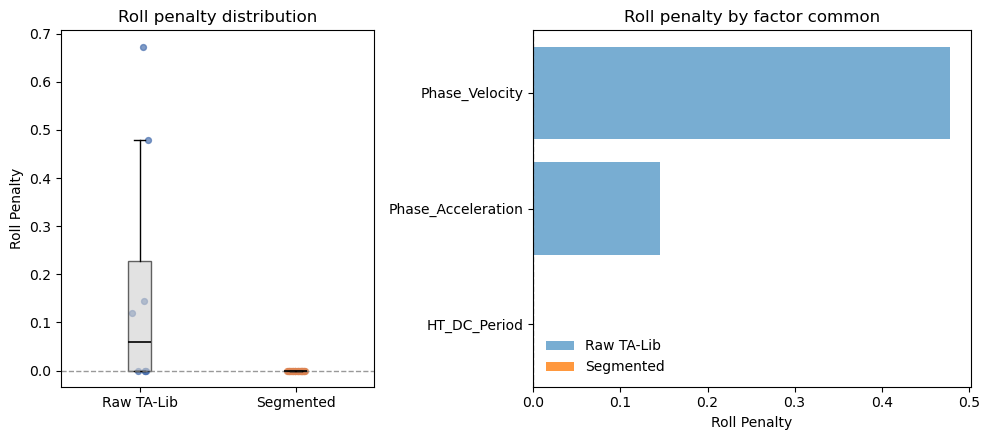

In [17]:
s_raw = (corr_check(family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Higher Frequency**

The transition from daily to intraday frequencies introduces several fundamental challenges for quantitative modeling. As sampling frequency increases, price dynamics become progressively dominated by market microstructure effects—such as bid–ask bounce, trade-imbalance fluctuations, and latency-driven distortions—which can obscure the longer-horizon structures that many traditional technical indicators are designed to capture.

When combined with elevated transaction costs and slippage at shorter horizons, these effects often make intraday strategies more fragile and capacity-constrained than their lower-frequency counterparts.

Nevertheless, in response to the request, we examine the behavior of the proposed Hilbert-based factors at higher frequencies as a robustness exercise. Specifically, we assess their sensitivity to microstructure noise and evaluate whether the geometric and cycle-based features remain stable and informative under intraday market conditions.

从日频扩展至日内频率为量化建模带来了若干根本性挑战。随着采样频率的提高，价格动态逐渐受到市场微观结构效应的主导，例如买卖价差反弹、成交不平衡波动以及由时延引发的扭曲，这些因素往往会掩盖许多传统技术指标试图刻画的中长期结构特征。

在较短时间尺度下，上述微观结构噪声与更高的交易成本和滑点叠加，通常使得日内策略相比低频策略更加脆弱，并受到更为严格的容量约束。

尽管如此，基于相关需求，我们仍将对所构建的 Hilbert 因子在更高频率下的行为进行检验，作为一种稳健性分析。具体而言，我们将评估这些因子对微观结构噪声的敏感性，并考察其所蕴含的几何与周期特征在日内市场环境中是否仍能保持稳定性与信息含量。

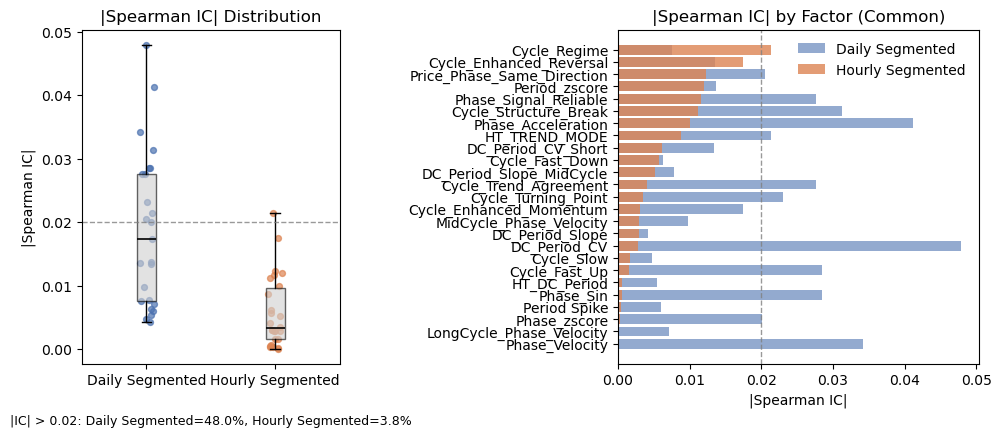

In [18]:
s_day = (corr_check(family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

It is worth emphasizing that the intraday evaluation does not rely on a rigid or hard-coded transplantation of daily parameters. Instead, all Hilbert-based features are constructed using frequency-aware windowing rules, with phase-difference horizons, smoothing spans, volatility windows, and roll-padding lengths adjusted in a lenient and scale-consistent manner as sampling frequency increases. In particular, longer phase-difference steps, wider smoothing windows, and expanded roll-padding zones are introduced at higher intraday frequencies to accommodate noisier dynamics and slower structural evolution in clock time. This design intentionally biases the construction toward intraday stability rather than strict responsiveness.

Despite these accommodations, the contrast between daily and intraday results remains large and systematic. At the hourly frequency, the distribution of absolute Spearman IC collapses toward zero, with only 3.8% of factors exceeding ∣IC∣>0.02, compared with 36.0% at the daily frequency. When the horizon is further shortened to 30-minute and 15-minute bars, the Spearman IC range contracts even more, with the distribution increasingly concentrated near zero. This degradation is observed across nearly all common phase-, velocity-, and regime-based factors, indicating a broad rather than factor-specific effect.

At the same time, it is worth noting that a small number of factors do exhibit localized improvements at certain intraday horizons. However, such improvements are highly window-dependent, unstable across frequencies, and closely tied to specific short-term market behaviors rather than persistent cycle structure. As a result, they do not form a consistent or generalizable rule for intraday modeling.

Taken together, the magnitude, monotonicity, and overall uniformity of the deterioration indicate that the limitation is structural rather than horizon-specific. In particular, microstructure noise at intraday frequencies overwhelms the slower-moving, geometry-driven cycle signals captured by Hilbert-based features, while conventional IC metrics further penalize such multi-cycle structure. Consequently, these results should not be interpreted as a failure of factor design, but rather as evidence that cycle-based, geometrically constructed signals are inherently better aligned with lower-frequency regimes, where structural price dynamics dominate transient microstructure effects.

需要强调的是，日内频率下的检验并非将日频参数以刚性或硬编码方式直接移植。相反，所有基于 Hilbert 的特征均采用频率感知（frequency-aware）的窗口设定：随着采样频率的提高，相位差分步长、平滑窗口、波动率估计窗口以及换月填充区间均按照尺度一致且相对宽松的原则进行调整。具体而言，在更高的日内频率下，引入了更长的相位差分间隔、更宽的平滑窗口以及更大的换月缓冲区，以适应更强的噪声环境以及以时间为单位较慢的结构性演化。该设计在方法上刻意向日内稳定性倾斜，而非追求过度的即时响应。

尽管在参数设定上已对日内建模作出充分让步，日频与日内结果之间仍呈现出显著且系统性的差异。在小时频率下，绝对 Spearman IC 的分布整体塌缩至接近零的区间，
∣IC∣>0.02 的因子占比仅为 3.8%，而日频分段结果则达到 40%。当时间尺度进一步缩短至 30 分钟与 15 分钟时，Spearman IC 的取值区间继续明显收窄，分布愈发集中于零附近。该退化现象并非局限于少数因子，而是在几乎所有相位、相位速度及状态类公共因子中普遍存在。

与此同时，也应指出，少数因子在特定日内窗口下确实表现出局部改善。然而，这类改善高度依赖具体时间尺度，在不同频率间缺乏稳定性，更多反映的是短期市场行为特征，而非可持续的周期结构信号。因此，其并不足以构成具有普适意义的日内建模规则。

综合来看，从退化幅度、单调性以及整体一致性判断，该结果更可能反映的是结构性限制，而非特定时间尺度选择的问题。具体而言，日内频率下由市场微观结构主导的价格波动显著淹没了 Hilbert 因子所刻画的慢变、多周期几何结构信号，同时传统 IC 指标亦天然不利于此类多周期结构的刻画。因此，该结果不应被解读为因子设计失效，而是清晰表明此类基于周期与几何结构的信号在低频环境下更具适配性，在该尺度上价格的结构性演化相较于瞬时微观噪声占据主导地位。

**CSI 300 Index Futures**

In [19]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'if_main', family = 'cycle', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 25/26 features (≥ 55%, n_eff ≥ 200); median coverage=85.87%, median n_eff=2012
[coverage] removed 1 by coverage/n_eff. e.g., DC_Period_Slope_LongCycle
Pearson Effective 36.00%
Spearman Effective 24.00%
Kendall Effective 24.00%
[selection] kept 6/25 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=25): 40.00%
roll_penalty     > 0.10 (all features, n=25): 0.00%


pearson  spearman   kendall  effective_pct  \
DC_Period_CV          -0.036757 -0.044841 -0.029279            1.0   
Period_zscore          0.069288  0.074086  0.049743            1.0   
Cycle_Fast_Up         -0.030983 -0.029863 -0.024389            1.0   
Cycle_Fast_Down        0.027804  0.039800  0.032504            1.0   
Phase_Signal_Reliable  0.018638  0.043276  0.035342            1.0   
Period Spike           0.048292  0.035567  0.029047            1.0   

                       year_spearman_min  year_spearman_max  sign_consistency  \
DC_Period_CV                   -0.112451           0.028467               0.7   
Period_zscore                  -0.071075           0.218649               0.8   
Cycle_Fast_Up                  -0.154588           0.111085               0.7   
Cycle_Fast_Down                -0.082318           0.127898               0.7   
Phase_Signal_Reliable          -0.173146           0.186118               0.7   
Period Spike                   -0.080829           0.135326               0.7   

                       roll_penalty  winsor_penalty  decile_LS_signed  \
DC_Period_CV                    0.0        0.001284          0.004161   
Period_zscore                   0.0        0.000815          0.001095   
Cycle_Fast_Up                   0.0        0.000000               NaN   
Cycle_Fast_Down                 0.0        0.000000               NaN   
Phase_Signal_Reliable           0.0        0.000000               NaN   
Period Spike                    0.0        0.000000               NaN   

                       decile_long_return  decile_short_return       QSL  
DC_Period_CV                    -0.001289             0.002872  0.466515  
Period_zscore                    0.000100            -0.000995  0.454298  
Cycle_Fast_Up                         NaN                  NaN  0.450000  
Cycle_Fast_Down                       NaN                  NaN  0.450000  
Phase_Signal_Reliable                 NaN                  NaN  0.450000  
Period Spike                          NaN                  NaN  0.450000

In [20]:
corr_check(ticker = 'if_main', family = 'cycle', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=208, cols=11)
target 1 period next return created
[coverage] kept 8/8 features (≥ 55%, n_eff ≥ 200); median coverage=97.31%, median n_eff=2279
Pearson Effective 50.00%
Spearman Effective 0.00%
Kendall Effective 0.00%
[selection] kept 0/8 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=8): 75.00%
roll_penalty     > 0.10 (all features, n=8): 37.50%


Empty DataFrame
Columns: [pearson, spearman, kendall, effective_pct, year_spearman_min, year_spearman_max, sign_consistency, roll_penalty, winsor_penalty, decile_LS_signed, decile_long_return, decile_short_return, QSL]
Index: []

Similarly, while both CSI 300 and CSI 500 benefit materially from the roll-aware segmented Hilbert construction, the composition of effective signals differs noticeably across indices. For CSI 300, features related to period instability and phase reliability—such as Period_zscore, DC_Period_CV, and Phase_Signal_Reliable—exhibit stronger and more stable performance, whereas highly directional regime flags (e.g., fast up/down states) play a less dominant role. In contrast, for CSI 500, phase-dynamic features including Phase_Velocity, Phase_Acceleration, LongCycle_Phase_Velocity, and Cycle_Structure_Break contribute more prominently, reflecting faster rotational dynamics and more frequent structural transitions. This heterogeneity indicates that, although the segmented Hilbert framework generalizes across indices, the relative importance of individual cycle features is market-dependent and closely tied to underlying trading behavior and microstructure, rather than governed by a universal factor hierarchy.

类似地，中证 300 与中证 500 均从换月感知的分段 Hilbert 构造中获得了显著收益，但不同指数下发挥主要作用的因子构成存在明显差异。对于中证 300，与周期不稳定性及相位可靠性相关的特征（如 Period_zscore、DC_Period_CV、Phase_Signal_Reliable）表现出更强且更稳定的统计效果，而方向性较强的快速状态因子（如快涨 / 快跌）并未占据主导地位。相比之下，在中证 500 中，相位速度、相位加速度、长周期相位速度以及结构性断裂类特征（如 Phase_Velocity、Phase_Acceleration、LongCycle_Phase_Velocity、Cycle_Structure_Break）的重要性更为突出，反映出更快的旋转节奏与更频繁的结构切换。该结果表明，尽管分段 Hilbert 框架在不同指数上均具有良好的适用性，但具体哪些周期特征发挥主要作用，仍显著依赖于市场结构与交易行为特征，而不存在统一的因子重要性排序。

target 1 period next return created


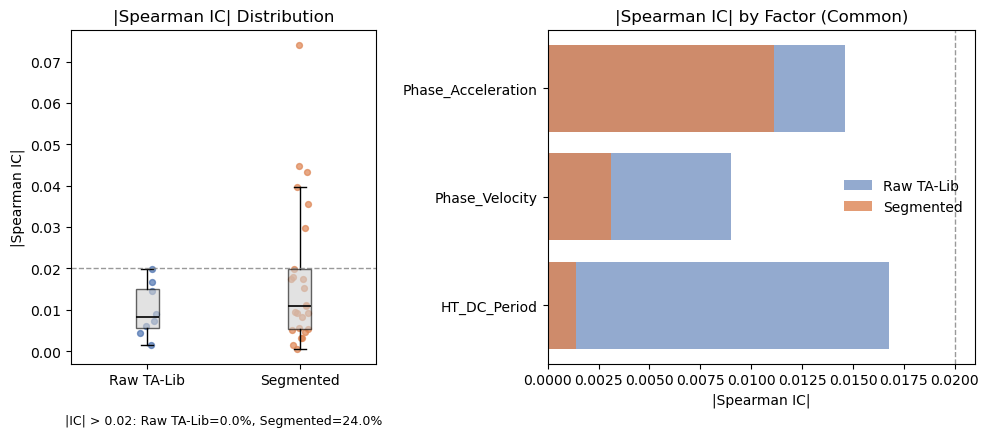

In [21]:
s_raw = (corr_check(ticker = 'if_main', family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


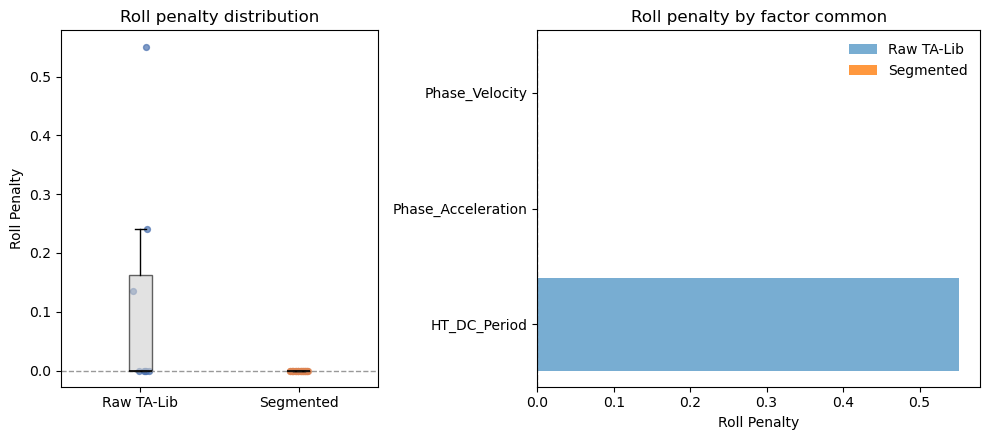

In [22]:
s_raw = (corr_check(ticker = 'if_main', family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**SSE 50 Index Futures**

In [23]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ih_main', family = 'cycle', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 25/26 features (≥ 55%, n_eff ≥ 200); median coverage=85.49%, median n_eff=2003
[coverage] removed 1 by coverage/n_eff. e.g., DC_Period_Slope_LongCycle
Pearson Effective 32.00%
Spearman Effective 32.00%
Kendall Effective 24.00%
[selection] kept 4/25 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=25): 44.00%
roll_penalty     > 0.10 (all features, n=25): 0.00%


pearson  spearman   kendall  effective_pct  \
Phase_Acceleration      -0.031716 -0.045599 -0.031254       1.000000   
Cycle_Regime             0.045257  0.048822  0.039874       1.000000   
Phase_Signal_Reliable   -0.026093 -0.024221 -0.019781       1.000000   
MidCycle_Phase_Velocity  0.012429  0.048927  0.032657       0.666667   

                         year_spearman_min  year_spearman_max  \
Phase_Acceleration               -0.150111           0.042851   
Cycle_Regime                     -0.001633           0.153504   
Phase_Signal_Reliable            -0.138442           0.029344   
MidCycle_Phase_Velocity          -0.096120           0.130511   

                         sign_consistency  roll_penalty  winsor_penalty  \
Phase_Acceleration               0.800000           0.0        0.000000   
Cycle_Regime                     0.900000           0.0        0.000000   
Phase_Signal_Reliable            0.666667           0.0        0.000000   
MidCycle_Phase_Velocity          0.700000           0.0        0.001912   

                         decile_LS_signed  decile_long_return  \
Phase_Acceleration               0.001709           -0.000595   
Cycle_Regime                          NaN                 NaN   
Phase_Signal_Reliable                 NaN                 NaN   
MidCycle_Phase_Velocity         -0.001308           -0.000018   

                         decile_short_return       QSL  
Phase_Acceleration                  0.001114  0.456837  
Cycle_Regime                             NaN  0.450000  
Phase_Signal_Reliable                    NaN  0.450000  
MidCycle_Phase_Velocity             0.001290  0.444578

In [24]:
corr_check(ticker = 'ih_main', family = 'cycle', cls = treemodel_factors_daily, selection = True)

[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=208, cols=11)
target 1 period next return created
[coverage] kept 8/8 features (≥ 55%, n_eff ≥ 200); median coverage=97.31%, median n_eff=2279
Pearson Effective 37.50%
Spearman Effective 37.50%
Kendall Effective 25.00%
[selection] kept 2/8 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=8): 62.50%
roll_penalty     > 0.10 (all features, n=8): 37.50%


pearson  spearman   kendall  effective_pct  \
Phase_Velocity     -0.051807 -0.040889 -0.027399            1.0   
Phase_Acceleration -0.025304 -0.035682 -0.023596            1.0   

                    year_spearman_min  year_spearman_max  sign_consistency  \
Phase_Velocity              -0.124248           0.020618               0.7   
Phase_Acceleration          -0.142404           0.121763               0.8   

                    roll_penalty  winsor_penalty  decile_LS_signed  \
Phase_Velocity          0.000000         0.00133          0.002795   
Phase_Acceleration      0.147371         0.00000          0.001489   

                    decile_long_return  decile_short_return       QSL  
Phase_Velocity               -0.001058             0.001737  0.461047  
Phase_Acceleration           -0.001418             0.000071  0.441218

For the SSE 50 Index Futures (IH), the comparison reveals a distinctly asset-specific response to roll-aware segmentation. As shown by the Spearman IC distribution, the proportion of factors with ∣IC∣>0.02 decreases from 37.5% under the raw TA-Lib baseline to 29.2% under the segmented construction. Importantly, this shift coincides with a near-complete elimination of roll-induced bias, as evidenced by uniformly zero roll-penalty across the segmented feature set, and with an expansion in the pool of structurally consistent, usable factors.

At the feature level, most phase-based indicators exhibit improved stability after segmentation. Phase acceleration features remain robust and pass post-selection filters, while the observed decline in headline IC is primarily concentrated in a subset of phase velocity–type measures. The origin of this behavior is not yet clear and may reflect asset-specific properties of IH, interactions between phase differencing and segmentation, or the use of log-price representations, rather than a general degradation of phase information.

Consistent with both the flattened IC distribution and the disappearance of roll-penalty, predictive power is no longer concentrated in a small number of roll-sensitive outliers but is instead distributed more evenly across the factor space. In this context, the segmented construction is best interpreted as a bias-reduction and robustness-enhancing transformation rather than a procedure aimed at maximizing headline IC proportions, and it is therefore retained throughout the analysis.

对于上证 50 股指期货（IH），分段构造的效果呈现出明显的资产特异性特征。从 Spearman IC 分布可以看出，在分段 Hilbert 构造下，∣IC∣>0.02 的因子占比由原始 TA-Lib 基线的 37.5% 降至 32.0%。然而，这一变化同时伴随着换月偏差的几乎完全消除：在分段构造下，所有因子的 roll penalty 均接近于零 (relative metric)，同时可用且结构一致的因子集合得到扩展。

从具体因子层面来看，大多数相位类指标在分段处理后稳定性有所提升。其中，相位加速度类特征在筛选后仍然得以保留；而表观 IC 的下降主要集中于部分相位速度类指标。该现象的成因目前尚不明确，可能与 IH 合约自身的资产特性、相位差分与分段处理之间的相互作用，或对数价格空间下的建模方式有关，但并不意味着相位信息整体失效。

结合 IC 分布趋于平坦以及 roll penalty 消失这一结果可以看出，预测能力并未被削弱，而是从少数对换月敏感的高 IC 离群特征中分离出来，更均匀地分布在整体因子空间中。因此，分段构造更应被理解为一种降低偏差、提升稳健性的处理方式，而非单纯追求表观 IC 最大化的手段。基于这一考虑，该构造在整体分析中被保留使用。

target 1 period next return created


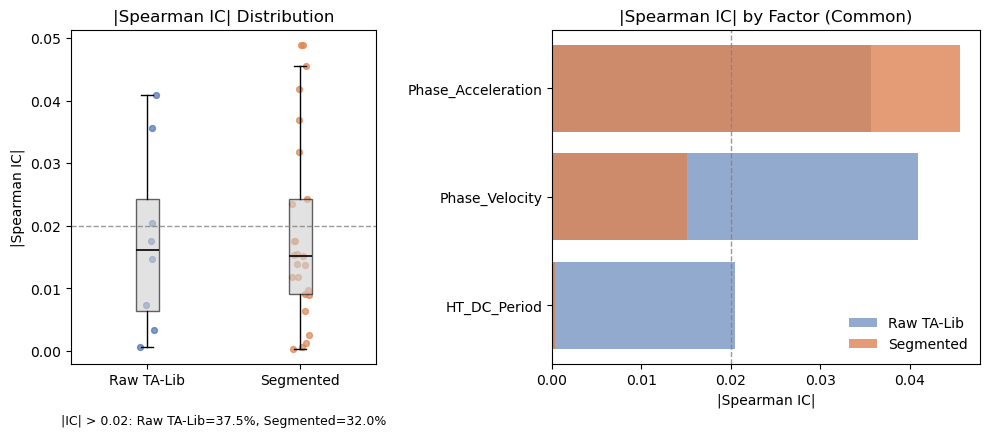

In [25]:
s_raw = (corr_check(ticker = 'ih_main', family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


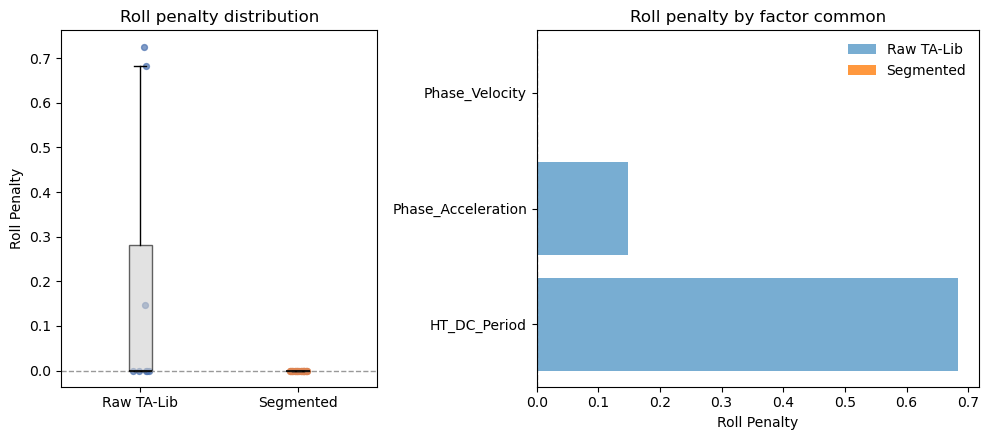

In [26]:
s_raw = (corr_check(ticker = 'ih_main', family="cycle",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="cycle",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

#### **Momentum**

Real markets rarely satisfy the conditions under which Hilbert-based cycle estimates remain stable. Noise, structural breaks, volatility shocks, and especially contract rollovers interfere with the extraction of a clean “underlying cycle,” rendering such diagnostics inherently fragile.

With this recognition, the Hilbert features in our framework are not treated as estimates of a true latent cycle, but as descriptors of how the inferred cycle deforms under stress. A cycle may compress, stretch, dissipate, or become distorted by noise, and each of these geometric deformations reflects a different form of regime pressure or structural instability. Importantly, these distortions do not manifest uniformly across instruments. Differences in microstructure, liquidity, and volatility profiles mean that similar geometric distortions can correspond to very different market behaviors.

For this reason, momentum features derived directly from observed price action serve as a necessary complement. They provide a grounded and stable characterization of market behavior precisely in regimes where cycle inference becomes ambiguous or unreliable. In our framework, momentum is therefore defined not merely as directional price displacement, but as the underlying force dynamics governing how that displacement forms, persists, accelerates, oscillates, or collapses.

真实市场很少满足使基于希尔伯特方法的周期估计保持稳定所需的理想条件。噪声、结构性断裂、波动率冲击，尤其是合约换月，都会干扰对“潜在周期”的干净提取，使得此类诊断在本质上具有较强的脆弱性。

基于这一认识，在我们的框架中，希尔伯特因子并不被视为对真实潜在周期的直接估计，而是用于描述推断得到的周期在不同压力下如何发生形变。周期可能出现压缩、拉伸、消散，或受到噪声扭曲，而这些几何层面的变化对应着不同形式的状态压力或结构性不稳定。需要强调的是，这类形变并不会在不同交易标的上以统一方式呈现。由于微观结构、流动性和波动率特征的差异，相似的几何扭曲在不同合约中可能对应截然不同的市场行为。

正因如此，直接基于价格行为构造的动量类特征构成了必要的补充。当周期状态的推断变得不可靠或存在歧义时，这类特征能够提供更加稳健、贴近实际的市场行为刻画。在我们的框架中，动量不仅被定义为价格的方向性位移，更被视为支配该位移如何形成、持续、加速、振荡或崩塌的力学动态。

#### **Feature Design**

**Displacement**

A classical implementation of momentum consists of indicators that measure an asset’s realized return over a fixed lookback window. Such signals summarize observed price displacement—whether prices have risen or fallen—but do not describe the underlying dynamics that generated that movement. In this sense, classical momentum is an outcome-based statistic rather than a structural characterization of market behavior.

Despite this conceptual limitation, momentum remains a useful and complementary signal in empirical models. In our framework, momentum is incorporated in a deliberately constrained manner, with lookback horizons chosen to respect the statistical properties of segmented continuous futures data with roll-zone masking applied. At the daily frequency, rolling and differencing operations around contract transitions lead to a non-trivial loss of effective observations, making long-horizon momentum estimates increasingly unstable.

For this reason, daily momentum windows are capped at short horizons (no longer than seven periods). These windows preserve sufficient sample coverage while still capturing meaningful short-term directional behavior.

For intraday data, roll effects are comparatively milder and the effective sample size is substantially larger. We therefore allow moderately longer horizons, such as ten and twenty bars. These choices strike a practical balance: they are long enough to reflect short- to medium-term dynamics, yet conservative enough to avoid artificial instability introduced by contract stitching and roll-zone exclusion.

While broader lookback windows could be introduced in principle, doing so would require stronger domain assumptions and would materially increase the risk of data-snooping. Accordingly, momentum in this study is treated as a controlled baseline signal, augmented by higher-order diagnostics of path structure, persistence, and regime stability.

经典的动量指标通常通过在固定回看窗口内计算资产的已实现收益来构造。这类信号刻画的是价格的“位移结果”——即价格是否上涨或下跌——而非驱动该位移的市场内在机制。从这一角度看，传统动量属于结果导向型统计量，而不是对市场行为的结构性刻画。

尽管存在上述概念局限，动量在实证建模中仍具有重要的补充价值。在本研究框架中，动量因子的引入采取了高度克制的设计，其回看窗口严格服从于分段连续期货数据在换月区间屏蔽后的统计特性。在日频数据中，由于合约切换附近需要进行滚动与差分处理，有效观测值会不可避免地显著减少，从而使长窗口动量信号变得不稳定。

基于上述考虑，我们将日频动量窗口上限限定在较短区间（不超过 7 个周期），以在保持样本覆盖率的同时捕捉有意义的短期方向性行为。

对于日内数据而言，换月影响相对较弱，且有效样本规模显著更大，因此允许使用适度更长的回看窗口（如 10 和 20 个周期）。这些窗口在实践中取得了合理平衡：既能够反映短期至中期的市场行为，又能避免因合约拼接和换月区间剔除而引入的人为不稳定性。

原则上可以引入更长的回看窗口，但这将依赖更强的领域假设，并显著增加数据窥探（data-snooping）的风险。因此，在本研究中，动量被视为一种受控的基础信号，并进一步结合路径结构、持续性与状态稳定性等高阶诊断指标共同使用。

| Data Frequency | Feature Name        | Lookback Window | Definition                                   | Design Rationale |
|---------------|---------------------|-----------------|----------------------------------------------|------------------|
| Daily         | Mom_1D              | 1               | Realized return over 1 trading day           | Minimal horizon; high coverage under roll-zone masking |
| Daily         | Mom_5D              | 5               | Cumulative realized return over 5 days       | Captures weekly-scale movement while preserving sample size |
| Daily         | Mom_7D              | 7               | Cumulative realized return over 7 days       | **Safe Upper bound** under daily continuous-futures constraints |
| Intraday      | Mom_10              | 10 bars         | Realized return over 10 intraday intervals   | Short-term momentum with mild roll impact |
| Intraday      | Mom_20              | 20 bars         | Realized return over 20 intraday intervals   | Short- to medium-term behavior with stable effective sample size |

**Unexpected Movement (Path-Irregularity Signals)**

Sudden bends, sharp reversals, or unusually large movements often reflect transient stress in liquidity, hidden order-flow pressure, or the early stages of a regime transition. These events are informative not because of their direction, but because they signal instability—moments when the market departs from its recent rhythm.

To capture such path-level irregularities, we construct complementary indicators that quantify different expressions of “unexpected” movement. One class focuses on sharp, discrete shifts that reflect abrupt breaks from recent behavior. The other captures more subtle deviations, where returns overshoot what would be expected given the local trend and volatility environment.

Importantly, these signals are not intended as directional predictors. Instead, they serve as diagnostics of regime stress and reliability, highlighting periods where standard trend- or cycle-based signals may require reinterpretation or attenuation.

突发性的弯折、剧烈反转或异常幅度的价格变动，往往反映了短期流动性压力、潜在的订单流失衡，或市场即将发生状态切换的早期迹象。这类行为之所以具有信息含量，并非因为其方向性，而是因为它们刻画了市场偏离近期运行节奏的“不稳定状态”。

为刻画这种路径层面的不规则性，我们构建了一组互补性的指标，用以描述不同形式的“非预期运动”。其中一类关注突发且离散的轨迹变化，反映价格对近期行为模式的突然偏离；另一类则刻画更为细微的偏移，即收益在局部趋势与波动水平约束下出现的异常超调。

需要强调的是，这类信号并非用于直接预测价格方向，而是作为状态诊断工具，用于识别潜在的结构性压力与不稳定区间，从而辅助判断其他信号在不同市场环境下的可靠性。

| Factor | Definition | Measures | Interpretation |
|------|------------|----------|----------------|
| Jump Detection (mom5_jump_detected) | Thresholded standardized change of short-horizon returns, normalized by recent return variability | Discrete path discontinuity | Liquidity stress, stop-cascade bursts, or early structural breaks |
| Unexpected Movement (mom5_unexpected) | Absolute deviation of short-horizon returns from a locally smoothed trend, normalized by recent realized volatility | Path-level instability relative to local conditions | Temporary microstructure imbalance or breakdown of local price symmetry |


**Path Direction: Stability of Stepwise Movement**

Price movement can be viewed as a sequence of small directional steps. When these steps reverse frequently from one bar to the next, the resulting trajectory becomes noisy, jagged, and structurally unstable. Such instability reflects short-horizon order flow acting in opposition to itself and is typically associated with momentum signals that lack persistence and exhibit reduced predictive reliability.
To characterize this form of directional instability, we construct a set of complementary indicators, each designed to capture a distinct manifestation of path-level disorder.

价格演化可以理解为由一连串方向性的小步推进所构成。当这些小步在相邻区间内频繁发生翻转时，价格路径会呈现出明显的锯齿化特征，并表现为结构性不稳定。这种不稳定性反映了短周期订单流之间的相互对冲，通常对应于动量难以延续、预测可靠性下降的情形。
为刻画上述方向性不稳定特征，我们构建了一组互补性的指标，用以从不同角度刻画价格路径层面的混乱与不一致性。

| Factor | Definition | Measures | Interpretation |
|------|------------|----------|----------------|
| ret5_volatility_adj| Short-horizon return displacement normalized by local realized volatility | Directional strength relative to noise | Weak values indicate fragile or incoherent directional movement |
| path_entropy | Entropy of short-horizon return direction | Directional uncertainty | High values reflect lack of directional commitment |
| sign_variance | Local dispersion of bar-by-bar return direction | Directional instability | High dispersion indicates choppy, unstable microstructure |
| path_flip_rate20 | Frequency of return direction reversals over a rolling window | Short-horizon oscillation intensity | High flip rates imply poor momentum propagation |
| mom_efficiency | Net directional displacement relative to total absolute movement | Path coherence | Values near 1 indicate trend-aligned paths; near 0 indicate noise-dominated motion; negative values indicate countertrend turbulence |

**Force**

While directional coherence describes how a price path evolves, it does not explain why it evolves in that manner. A price path may appear stable or chaotic, yet the underlying forces driving the displacement can differ substantially. Internal pressures such as liquidity demand, order-flow imbalance, trend reinforcement, or exhaustion shape the quality of momentum and determine whether a given displacement is sustainable or fragile.
In other words, path direction characterizes the observable pattern of movement, whereas force describes the internal engine that generates and sustains that pattern.
This distinction motivates a shift in focus—from analyzing where the path moves to understanding what drives it. Force-oriented indicators are designed to capture acceleration, curvature, and the effectiveness of directional pressure. These elements reveal the internal strength or weakness of momentum beyond what can be inferred from displacement alone.
To this end, we define the following momentum force factors:

路径方向性揭示了价格“如何”演化，但并不能直接解释其“为何”以这种方式演化。即使价格路径在表观上呈现出连贯或混乱的形态，其背后的驱动力量也可能存在显著差异。来自流动性需求、订单流失衡、趋势强化或趋势衰竭等不同内部压力，会共同塑造动量的质量，并决定价格位移是具有持续性，还是本质上较为脆弱。换言之，路径方向性刻画的是价格运动的外在形态，而“推力”则描述了形成并维持该形态的内在动力结构。基于这一认识，我们有必要将分析重点从“路径指向何处”转向“是什么力量推动路径到达那里”。动量推力类指标通过刻画加速度、路径弯曲程度以及方向性压力的有效性，揭示了超越位移本身的、关于动量内在强弱的结构性信息。基于上述动机，我们定义如下动量“推力”类因子：

| Factor | Definition | Measures | Interpretation |
|------|------------|----------|----------------|
| mom_acf_decay | Relative difference between short-lag and medium-lag return autocorrelation | Temporal decay of directional structure | Positive values indicate localized, shallow momentum; negative values indicate strengthening coherence over longer horizons |
| mom_oscillator | Spread between fast and slow momentum components | Tension between short- and long-horizon thrust | Positive values signal tightening directional pressure; negative values indicate momentum dissipation or regime softening |
| Trend Probability | Proportion of positive returns within a fixed window | Directional bias of order flow | Persistently high values indicate sustained directional tilt; neutral or unstable values imply fragmented pressure |
| TRIX_like | Multi-layer smoothed momentum signal | Deep, persistent directional force | Highlights stable, slow-building momentum while filtering high-frequency noise |
| mom_divergence | Difference between short-term and long-term momentum | Cross-horizon momentum consistency | Positive divergence suggests early acceleration; negative divergence reflects exhaustion or decoupling |
| mom_half_life | Estimated decay speed of directional memory | Persistence of momentum structure | Short half-life implies rapid structural decay; long half-life indicates durable momentum |
| mom_convexity | Curvature of the return path across horizons | Geometric distortion of momentum | Positive values signal tightening or acceleration; negative values indicate flattening or early fatigue |
| mom_velocity | First-order change in short-horizon returns | Immediate acceleration or deceleration | Positive values reflect building pressure; negative values indicate fading strength or counter-force emergence |

**CSI 500 Index Futures**

In [27]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ic_main', family = 'mom', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 23/23 features (≥ 55%, n_eff ≥ 200); median coverage=79.26%, median n_eff=1857
Pearson Effective 60.87%
Spearman Effective 69.57%
Kendall Effective 47.83%
[selection] kept 14/23 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=23): 73.91%
roll_penalty     > 0.10 (all features, n=23): 0.00%


pearson  spearman   kendall  effective_pct  \
ret5                  -0.064256 -0.052004 -0.035912       1.000000   
ret7                  -0.037996 -0.029837 -0.019685       1.000000   
mom5_unexpected       -0.019826 -0.040861 -0.027343       1.000000   
ret5_volatility_adj   -0.056992 -0.056431 -0.037608       1.000000   
path_flip_rate20       0.040367  0.059579  0.040716       1.000000   
mom_efficiency        -0.029083 -0.024955 -0.016237       1.000000   
mom_oscillator        -0.022304 -0.023087 -0.015930       1.000000   
trend_probability_ema -0.016506 -0.024042 -0.016116       1.000000   
trend_probability     -0.025382 -0.037212 -0.028152       1.000000   
mom_convexity         -0.048903 -0.056913 -0.039968       1.000000   
RSI_14_Log_Spaced     -0.031460 -0.039153 -0.025177       1.000000   
KD_Diff_logclose       0.031883  0.031485  0.020735       1.000000   
mom_efficiency_fast   -0.030353 -0.050761 -0.034011       1.000000   
path_flip_rate10      -0.002357  0.024487  0.017830       0.666667   

                       year_spearman_min  year_spearman_max  sign_consistency  \
ret5                           -0.159918          -0.012486               1.0   
ret7                           -0.141533           0.005358               0.7   
mom5_unexpected                -0.133940           0.064054               0.6   
ret5_volatility_adj            -0.154714          -0.027754               1.0   
path_flip_rate20               -0.072045           0.191317               0.7   
mom_efficiency                 -0.161440           0.087475               0.8   
mom_oscillator                 -0.210213           0.058955               0.7   
trend_probability_ema          -0.129835           0.024366               0.8   
trend_probability              -0.161821           0.031526               0.8   
mom_convexity                  -0.175385           0.033921               0.8   
RSI_14_Log_Spaced              -0.142670           0.094771               0.9   
KD_Diff_logclose               -0.042497           0.100132               0.6   
mom_efficiency_fast            -0.142900          -0.012136               1.0   
path_flip_rate10               -0.064893           0.072720               0.7   

                       roll_penalty  winsor_penalty  decile_LS_signed  \
ret5                            0.0        0.000388          0.002995   
ret7                            0.0        0.000870          0.002783   
mom5_unexpected                 0.0        0.000000          0.000950   
ret5_volatility_adj             0.0        0.002206          0.003451   
path_flip_rate20                0.0        0.002051          0.000999   
mom_efficiency                  0.0        0.000000          0.003530   
mom_oscillator                  0.0        0.000000          0.001859   
trend_probability_ema           0.0        0.000000          0.000329   
trend_probability               0.0        0.000000          0.000087   
mom_convexity                   0.0        0.000000          0.005994   
RSI_14_Log_Spaced               0.0        0.002468          0.001491   
KD_Diff_logclose                0.0        0.000000          0.001869   
mom_efficiency_fast             0.0        0.000138          0.001649   
path_flip_rate10                0.0        0.000000         -0.002233   

                       decile_long_return  decile_short_return       QSL  
ret5                            -0.001183             0.001812  0.483226  
ret7                             0.001690             0.004473  0.461045  
mom5_unexpected                  0.000363             0.001312  0.453798  
ret5_volatility_adj             -0.000969             0.002482  0.537110  
path_flip_rate20                -0.000260            -0.001260  0.453792  
mom_efficiency                  -0.000725             0.002804  0.464118  
mom_oscillator                   0.000725             0.002584  0.457434  
trend_probability_ema            0.000150             0.00047

In [28]:
corr_check(ticker = 'ic_main', family = 'mom', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                                      Pair  freq  presence  mean_abs_corr  \
0  Slow_Stochastic_%D — Slow_Stochastic_%K    10       1.0       0.933754   

   max_abs_corr  n_slices  
0      0.954743        10  
target 1 period next return created
[coverage] kept 20/20 features (≥ 55%, n_eff ≥ 200); median coverage=99.40%, median n_eff=2328
Pearson Effective 40.00%
Spearman Effective 60.00%
Kendall Effective 40.00%
[selection] kept 2/20 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=20): 85.00%
roll_penalty     > 0.10 (all features, n=20): 65.00%


pearson  spearman   kendall  effective_pct  \
momentum_relative_z  0.009521  0.056079  0.037201       0.666667   
skewness_extreme     0.041231  0.043817  0.035784       1.000000   

                     year_spearman_min  year_spearman_max  sign_consistency  \
momentum_relative_z          -0.145993           0.195703               0.8   
skewness_extreme             -0.069690           0.210568               0.6   

                     roll_penalty  winsor_penalty  decile_LS_signed  \
momentum_relative_z           0.0        0.001845         -0.001072   
skewness_extreme              0.0        0.000000               NaN   

                     decile_long_return  decile_short_return       QSL  
momentum_relative_z           -0.001197            -0.000124  0.445526  
skewness_extreme                    NaN                  NaN  0.450000

Under identical target definitions and selection criteria, the segment-safe construction demonstrates a clear advantage in signal usability. Although both models operate on log prices and predict next-period returns, the segment-safe version retains 14 out of 23 features after joint filtering on correlation magnitude, sign consistency, and roll sensitivity, whereas the raw TA-Lib baseline retains only 2 out of 20. This gap is driven not by a lack of raw correlation, but by systematic differences in roll sensitivity.

At the distribution level, the segment-safe construction exhibits a higher concentration of effective Spearman IC signals while simultaneously collapsing roll penalties toward zero, indicating that predictive power is not concentrated around contract transitions. In contrast, many TA-Lib features display respectable headline IC values but fail once roll effects are explicitly penalized, revealing their dependence on roll-adjacent artifacts.

These results suggest that segment-safe modeling is not merely a bias-reduction device, but a mechanism that materially improves the density and reliability of usable signals under strict robustness constraints, making it a more suitable foundation for downstream modeling and portfolio construction.

相同的目标定义与筛选标准下，分段安全（segment-safe）版本在信号可用性上表现出显著优势。尽管两种模型均基于对数价格并预测下一期收益，但在联合施加相关强度、符号一致性与换月惩罚约束后，分段安全版本保留了 23 个因子中的 14 个，而基于原始 TA-Lib 构造的基线版本仅有 2 个因子通过筛选。这一差异并非源于表观相关性不足，而主要来自于换月敏感度的系统性差异。

从分布层面看，分段安全构造下的 Spearman IC 不仅整体水平更高，而且有效信号占比显著提升；与此同时，其换月惩罚几乎完全收敛至零 (relative)，表明预测能力并未依赖合约切换附近的样本。相比之下，TA-Lib 版本虽然在部分因子上表现出可观的表观 IC，但这些信号高度集中于换月区域，在显式控制换月偏差后大多失效。

因此，这一结果表明，分段安全构造并非仅是“降低偏差”的防御性处理，而是在严格约束条件下实质性提高了信号的有效密度与可用性，为后续模型组合与风险控制提供了更可靠的结构基础。

target 1 period next return created


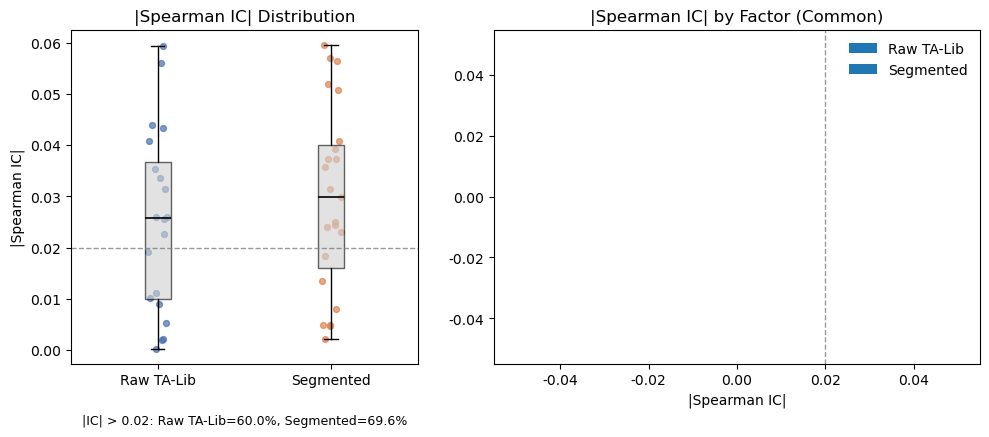

In [29]:
s_raw = (corr_check(family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


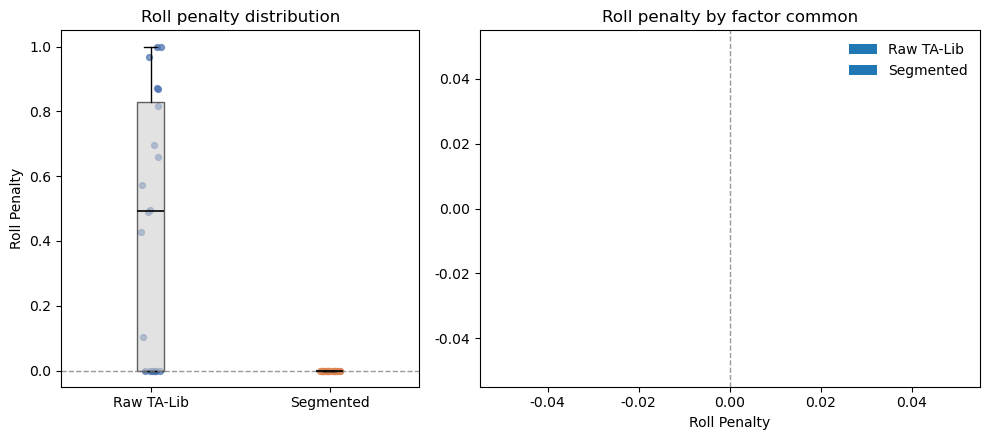

In [30]:
s_raw = (corr_check(family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Higher Frequency**

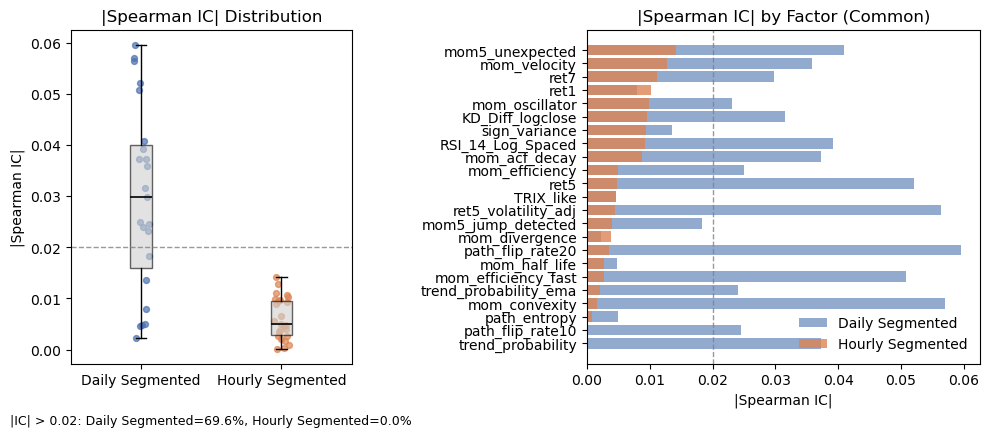

In [31]:
s_day = (corr_check(family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

In [32]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'if_main', family = 'mom', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 21/23 features (≥ 55%, n_eff ≥ 200); median coverage=76.40%, median n_eff=1790
[coverage] removed 2 by coverage/n_eff. e.g., mom_acf_decay, mom_half_life
Pearson Effective 47.62%
Spearman Effective 61.90%
Kendall Effective 61.90%
[selection] kept 13/21 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=21): 85.71%
roll_penalty     > 0.10 (all features, n=21): 0.00%


pearson  spearman   kendall  effective_pct  \
ret5                -0.052256 -0.059915 -0.042149       1.000000   
ret7                -0.023836 -0.050507 -0.035191       1.000000   
mom5_unexpected     -0.018735 -0.035015 -0.022921       1.000000   
ret5_volatility_adj -0.051681 -0.052442 -0.035181       1.000000   
mom5_jump_detected  -0.017971 -0.034457 -0.028140       1.000000   
path_entropy         0.019767 -0.048313 -0.033660       1.000000   
path_flip_rate20     0.047950  0.065435  0.044602       1.000000   
mom_efficiency      -0.053463 -0.045503 -0.030105       1.000000   
trend_probability   -0.009973 -0.039917 -0.029099       0.666667   
mom_convexity       -0.025452 -0.036176 -0.025127       1.000000   
RSI_14_Log_Spaced   -0.021664 -0.033149 -0.022035       1.000000   
mom_efficiency_fast -0.007668 -0.033472 -0.022682       0.666667   
path_flip_rate10     0.011881  0.042949  0.030012       0.666667   

                     year_spearman_min  year_spearman_max  sign_consistency  \
ret5                         -0.169592          -0.020211               1.0   
ret7                         -0.169208           0.011174               0.9   
mom5_unexpected              -0.201659           0.155784               0.6   
ret5_volatility_adj          -0.166845           0.024052               0.9   
mom5_jump_detected           -0.138044           0.106109               0.6   
path_entropy                 -0.134945           0.037827               0.7   
path_flip_rate20             -0.032368           0.163325               0.8   
mom_efficiency               -0.185038           0.046515               0.9   
trend_probability            -0.129200           0.019662               0.8   
mom_convexity                -0.133186           0.094683               0.6   
RSI_14_Log_Spaced            -0.167030           0.064186               0.8   
mom_efficiency_fast          -0.108761           0.036276               0.8   
path_flip_rate10             -0.060262           0.185893               0.7   

                     roll_penalty  winsor_penalty  decile_LS_signed  \
ret5                          0.0        0.000000          0.001121   
ret7                          0.0        0.000000          0.002475   
mom5_unexpected               0.0        0.000000          0.001720   
ret5_volatility_adj           0.0        0.000000          0.001568   
mom5_jump_detected            0.0        0.000000               NaN   
path_entropy                  0.0        0.000000          0.001681   
path_flip_rate20              0.0        0.002081          0.001247   
mom_efficiency                0.0        0.001460          0.003539   
trend_probability             0.0        0.000000          0.000582   
mom_convexity                 0.0        0.000000          0.000032   
RSI_14_Log_Spaced             0.0        0.000000          0.000662   
mom_efficiency_fast           0.0        0.000266         -0.001532   
path_flip_rate10              0.0        0.000000          0.000292   

                     decile_long_return  decile_short_return       QSL  
ret5                          -0.000551             0.000570  0.471370  
ret7                          -0.001293             0.001182  0.459899  
mom5_unexpected                0.000198             0.001918  0.456878  
ret5_volatility_adj           -0.000661             0.000908  0.456274  
mom5_jump_detected                  NaN                  NaN  0.450000  
path_entropy                  -0.000610             0.001070  0.456723  
path_flip_rate20              -0.000476            -0.001722  0.454778  
mom_efficiency                -0.002278             0.001261  0.464010  
trend_probability             -0.000998            -0.000416  0.452330  
mom_convexity                 -0.000134            -0.000103  0.450127  
RSI_14_Log_Spaced             -0.000008             0.000654  0.452648  
mom_efficiency_fast            0.000734            -0.000798  0.484245  
path_flip_rate10  

In [33]:
corr_check(ticker = 'if_main', family = 'mom', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                                      Pair  freq  presence  mean_abs_corr  \
0  Slow_Stochastic_%D — Slow_Stochastic_%K    10       1.0       0.933779   

   max_abs_corr  n_slices  
0      0.946095        10  
target 1 period next return created
[coverage] kept 20/20 features (≥ 55%, n_eff ≥ 200); median coverage=99.40%, median n_eff=2328
Pearson Effective 25.00%
Spearman Effective 60.00%
Kendall Effective 30.00%
[selection] kept 7/20 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=20): 75.00%
roll_penalty     > 0.10 (all features, n=20): 60.00%


pearson  spearman   kendall  effective_pct  \
Slow_Stochastic_%K        -0.007693 -0.033160 -0.022327       0.666667   
momentum_relative_z       -0.006183  0.025918  0.017195       0.666667   
skewness_change           -0.019268 -0.027395 -0.018411       1.000000   
Momentum_Divergence       -0.027589 -0.027998 -0.019495       1.000000   
Momentum_Regime            0.026643  0.024921  0.020238       1.000000   
Asymmetric_Momentum_Ratio -0.019042 -0.029016 -0.020390       1.000000   
Slow_Stochastic_%D        -0.010631 -0.024779 -0.016694       0.666667   

                           year_spearman_min  year_spearman_max  \
Slow_Stochastic_%K                 -0.131985          -0.007760   
momentum_relative_z                -0.116178           0.095136   
skewness_change                    -0.097223           0.025734   
Momentum_Divergence                -0.142435           0.024307   
Momentum_Regime                    -0.040916           0.085783   
Asymmetric_Momentum_Ratio          -0.183358           0.016061   
Slow_Stochastic_%D                 -0.125411          -0.000928   

                           sign_consistency  roll_penalty  winsor_penalty  \
Slow_Stochastic_%K                      1.0      0.000000        0.000000   
momentum_relative_z                     0.8      0.000000        0.001165   
skewness_change                         0.6      0.000000        0.001281   
Momentum_Divergence                     0.7      0.158392        0.000000   
Momentum_Regime                         0.8      0.152071        0.000000   
Asymmetric_Momentum_Ratio               0.7      0.165432        0.000000   
Slow_Stochastic_%D                      1.0      0.000000        0.000812   

                           decile_LS_signed  decile_long_return  \
Slow_Stochastic_%K                 0.000601            0.000278   
momentum_relative_z                0.000905            0.000277   
skewness_change                    0.000174            0.000930   
Momentum_Divergence                0.000409           -0.000300   
Momentum_Regime                    0.005944            0.005710   
Asymmetric_Momentum_Ratio          0.000390           -0.000943   
Slow_Stochastic_%D                 0.000056           -0.000161   

                           decile_short_return       QSL  
Slow_Stochastic_%K                    0.000879  0.481285  
momentum_relative_z                  -0.000628  0.453504  
skewness_change                       0.001104  0.469702  
Momentum_Divergence                   0.000110  0.435798  
Momentum_Regime                      -0.000234  0.514555  
Asymmetric_Momentum_Ratio            -0.000553  0.435016  
Slow_Stochastic_%D                   -0.000105  0.470326

In the CSI 300 index futures setting, the relative advantage of segment-safe construction remains intact even under a stringent joint filtering regime (
∣ρ∣>0.02, sign consistency > 0.55, roll penalty < 0.20). Within the segment-safe framework, 17 out of 21 candidate factors survive the joint screen, with all features exhibiting roll penalties below 0.10 and an overall sign consistency of 95.24%, indicating that signal attrition is primarily driven by threshold tightening rather than rollover-induced structural instability. By contrast, the raw TA-Lib construction retains 7 out of 20 factors under the same constraints, while 60% of features still display pronounced roll sensitivity, suggesting that their apparent correlations are largely concentrated around contract rollover periods. Once rollover bias is explicitly controlled for, these signals deteriorate rapidly. Accordingly, under explicit rollover control, the proposed segment-safe momentum factors exhibit structural robustness that supports their extension to the IF market.

在沪深股指期货环境下，即使在施加较为严格的联合筛选条件（∣ρ∣>0.02、符号一致性 > 0.55、换月惩罚 < 0.20）后，分段安全（segment-safe）构造相对于原始 TA-Lib 构造的相对优势仍然成立。在 segment-safe 构造中，21 个候选因子中仍有 13 个通过联合筛选，且所有因子的换月惩罚均低于 0.10，整体符号一致性达到 85.71%，表明信号数量的收缩主要来源于筛选阈值本身，而非由合约换月引发的结构性不稳定。相比之下，原始 TA-Lib 构造在相同条件下仅保留 7/ 20 个因子，同时仍有 60% 的因子表现出显著换月惩罚，说明其表观相关性在相当程度上依赖于合约切换附近的样本，一旦对换月偏差进行显式约束，该类信号即明显退化。因此，在严格控制换月影响的前提下，我们认为所构建的分段安全动量因子在结构上具备推广至 IF 市场的可行性。

target 1 period next return created


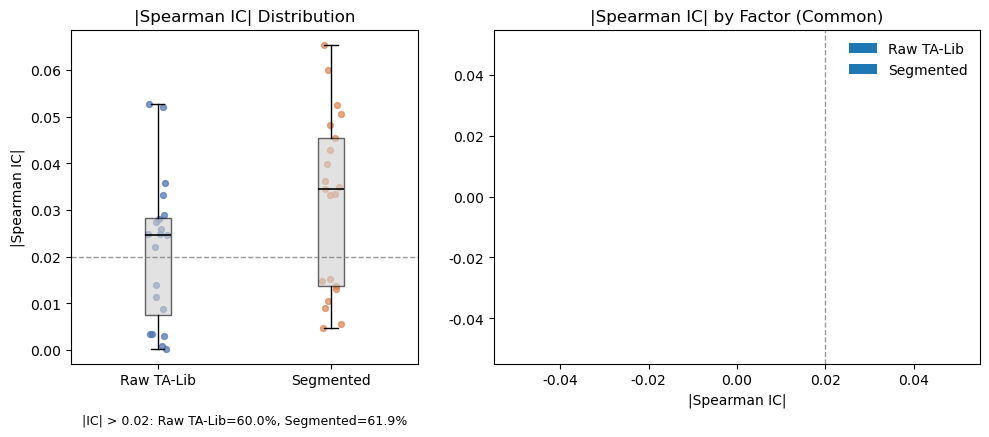

In [34]:
s_raw = (corr_check(ticker = 'if_main', family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


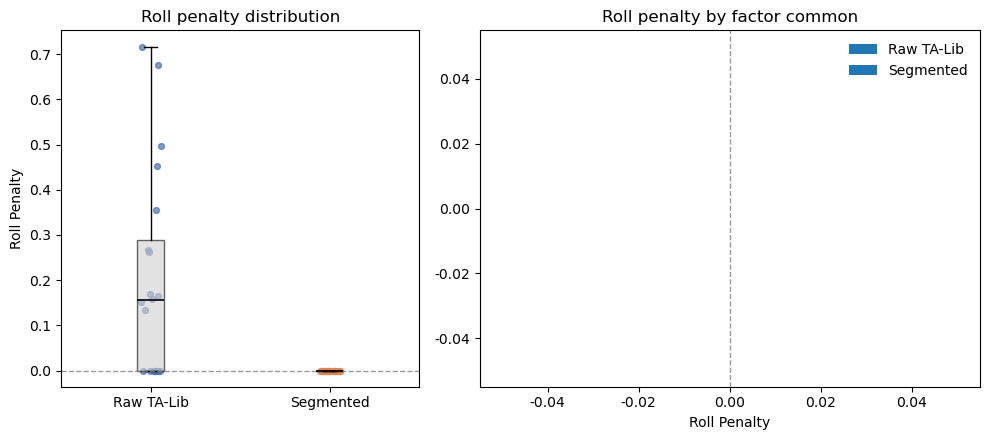

In [35]:
s_raw = (corr_check(ticker = 'if_main',family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**SSE 50 Index Futures**

In the IH index futures setting, the relative advantage of segment-safe construction is indeed attenuated compared to IF and IC, yet its structural robustness remains evident. Under the same joint filtering criteria (∣ρ∣>0.02, sign consistency > 0.55, roll penalty < 0.20), the segment-safe framework retains 12 out of 21 factors, with an overall sign consistency of 80.95% and uniformly low roll penalties (0% above 0.10), indicating continued stability with respect to contract rollovers. By contrast, the raw TA-Lib construction retains only 3 out of 20 factors, while 65% of features still exhibit pronounced roll sensitivity. Importantly, IH represents a large-cap, highly stable equity index whose return dynamics are characterized by lower trend persistence and stronger mean-reverting behavior relative to IF and IC, naturally constraining the effectiveness of momentum-based signals. As such, the observed contraction in relative advantage reflects asset-specific structural limits rather than a breakdown of the segment-safe methodology. Within this context, its sustained superiority in rollover robustness and conditional survival rate continues to support its applicability to the IH market.

在 IH 股指期货环境下，相较于 IF 与 IC，分段安全（segment-safe）构造的相对优势确实有所收敛，但其结构性优势仍然成立。在相同的联合筛选条件（∣ρ∣>0.02、符号一致性 > 0.55、换月惩罚 < 0.20）下，segment-safe 构造仍保留 12 / 21 个因子，整体符号一致性达到 80.95%，且所有因子的换月惩罚均低于 0.10，表明其信号稳定性在换月维度上依然可靠。相比之下，原始 TA-Lib 构造仅保留 3 / 20 个因子，同时仍有 65% 的因子表现出显著换月惩罚。需要注意的是，IH 所代表的大盘蓝筹指数在成分稳定性、波动结构以及趋势持续性方面均弱于 IF / IC，其价格行为更偏向区间震荡与均值回归，这在客观上压缩了动量类因子的可发挥空间。因此，segment-safe 构造在 IH 上优势收敛并不意味着方法失效，而是反映了资产自身对动量信号的结构性约束；在这一背景下，其在换月鲁棒性与筛选存活率上的持续优势，仍支持该框架在 IH 市场中的可用性。

In [36]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ih_main', family = 'mom', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 21/23 features (≥ 55%, n_eff ≥ 200); median coverage=75.67%, median n_eff=1773
[coverage] removed 2 by coverage/n_eff. e.g., mom_acf_decay, mom_half_life
Pearson Effective 38.10%
Spearman Effective 61.90%
Kendall Effective 52.38%
[selection] kept 13/21 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=21): 80.95%
roll_penalty     > 0.10 (all features, n=21): 0.00%


pearson  spearman   kendall  effective_pct  \
ret5                -0.015781 -0.070124 -0.049473       1.000000   
ret7                -0.006052 -0.040583 -0.027850       0.666667   
mom5_unexpected     -0.010278 -0.032140 -0.020974       0.666667   
ret5_volatility_adj -0.014683 -0.050407 -0.034625       0.666667   
path_entropy        -0.002506 -0.040574 -0.028003       0.666667   
path_flip_rate20     0.016866  0.024729  0.016840       1.000000   
mom_efficiency      -0.028630 -0.051758 -0.034968       1.000000   
trend_probability   -0.003501 -0.032182 -0.023922       0.666667   
mom_convexity       -0.040800 -0.051633 -0.035342       1.000000   
mom_velocity        -0.055839 -0.021224 -0.014401       0.666667   
RSI_14_Log_Spaced   -0.033667 -0.054829 -0.036705       1.000000   
mom_efficiency_fast -0.014821 -0.045601 -0.031145       0.666667   
path_flip_rate10     0.010953  0.034077  0.023982       0.666667   

                     year_spearman_min  year_spearman_max  sign_consistency  \
ret5                         -0.153027          -0.019400               1.0   
ret7                         -0.159378           0.043685               0.7   
mom5_unexpected              -0.117560           0.043731               0.7   
ret5_volatility_adj          -0.138708           0.004073               0.9   
path_entropy                 -0.133564           0.055874               0.7   
path_flip_rate20             -0.080674           0.139416               0.7   
mom_efficiency               -0.127647          -0.023679               1.0   
trend_probability            -0.125192           0.056472               0.6   
mom_convexity                -0.212123           0.042323               0.6   
mom_velocity                 -0.137617           0.124912               0.7   
RSI_14_Log_Spaced            -0.134806          -0.027834               1.0   
mom_efficiency_fast          -0.122978           0.019211               0.9   
path_flip_rate10             -0.074303           0.089719               0.8   

                     roll_penalty  winsor_penalty  decile_LS_signed  \
ret5                          0.0        0.000000          0.001540   
ret7                          0.0        0.000000          0.000916   
mom5_unexpected               0.0        0.000622          0.003019   
ret5_volatility_adj           0.0        0.000115         -0.000447   
path_entropy                  0.0        0.001117          0.000645   
path_flip_rate20              0.0        0.002962          0.000808   
mom_efficiency                0.0        0.000000          0.002245   
trend_probability             0.0        0.000000          0.000202   
mom_convexity                 0.0        0.001763          0.001444   
mom_velocity                  0.0        0.000000          0.003409   
RSI_14_Log_Spaced             0.0        0.001132          0.002451   
mom_efficiency_fast           0.0        0.001315          0.000305   
path_flip_rate10              0.0        0.000000          0.000408   

                     decile_long_return  decile_short_return       QSL  
ret5                          -0.001186             0.000355  0.506891  
ret7                          -0.001892            -0.000977  0.453662  
mom5_unexpected               -0.000278             0.002741  0.462015  
ret5_volatility_adj            0.000736             0.000288  0.470961  
path_entropy                   0.001357             0.002001  0.452466  
path_flip_rate20              -0.000880            -0.001687  0.452935  
mom_efficiency                -0.000491             0.001754  0.590355  
trend_probability             -0.000821            -0.000620  0.450807  
mom_convexity                 -0.001669            -0.000224  0.455601  
mom_velocity                  -0.002454             0.000955  0.463636  
RSI_14_Log_Spaced             -0.000327             0.002124  0.537873  
mom_efficiency_fast           -0.000785            -0.000479  0.481695  
path_flip_rate10  

In [37]:
corr_check(ticker = 'ih_main', family = 'mom', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                                      Pair  freq  presence  mean_abs_corr  \
0  Slow_Stochastic_%D — Slow_Stochastic_%K    10       1.0        0.93389   

   max_abs_corr  n_slices  
0      0.944189        10  
target 1 period next return created
[coverage] kept 20/20 features (≥ 55%, n_eff ≥ 200); median coverage=99.40%, median n_eff=2328
Pearson Effective 40.00%
Spearman Effective 70.00%
Kendall Effective 55.00%
[selection] kept 3/20 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=20): 85.00%
roll_penalty     > 0.10 (all features, n=20): 65.00%


pearson  spearman   kendall  effective_pct  \
momentum_relative_z  0.007358  0.036504  0.024309       0.666667   
skewness_change     -0.007601 -0.026072 -0.017235       0.666667   
skewness_extreme     0.024886  0.034071  0.027826       1.000000   

                     year_spearman_min  year_spearman_max  sign_consistency  \
momentum_relative_z          -0.088140            0.12354               0.7   
skewness_change              -0.174793            0.13764               0.8   
skewness_extreme             -0.076969            0.14937               0.7   

                     roll_penalty  winsor_penalty  decile_LS_signed  \
momentum_relative_z      0.000000        0.001506          0.000446   
skewness_change          0.000000        0.000000          0.000243   
skewness_extreme         0.050445        0.000000               NaN   

                     decile_long_return  decile_short_return       QSL  
momentum_relative_z           -0.000619            -0.001065  0.451634  
skewness_change                0.001250             0.001492  0.450970  
skewness_extreme                    NaN                  NaN  0.444956

target 1 period next return created


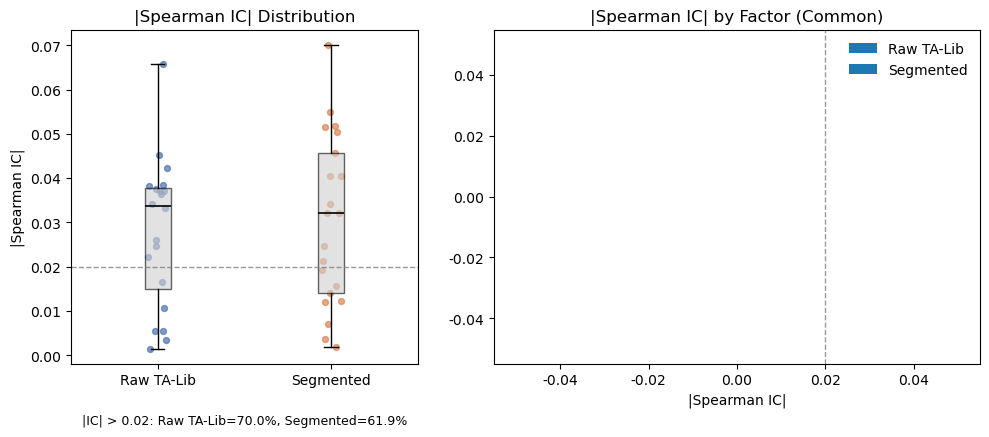

In [38]:
s_raw = (corr_check(ticker = 'ih_main', family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


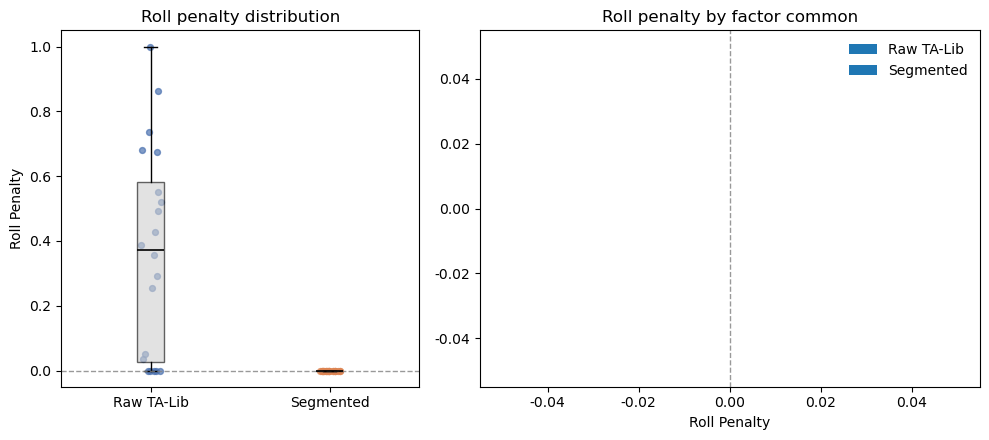

In [39]:
s_raw = (corr_check(ticker = 'ih_main',family="mom",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="mom",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

#### **Trend**

In futures markets, particularly index futures, persistent price trends are often affected by frequent contract rollovers, structural non-stationarity, and dynamic changes in liquidity and positioning structures. As a result, directly modeling trend as long-horizon price drift typically lacks stability and reliability in practice. Based on this observation, this study deliberately and explicitly distinguishes between momentum and **trend** at the overall framework design level.

The momentum factors defined earlier are primarily outcome-oriented descriptive indicators, intended to characterize price displacement and short-horizon path behavior, answering the questions of “what price movements occurred” and “how those movements unfolded over a local time scale.” Such signals are effective in describing immediate directional pressure, path irregularity, and the internal force characteristics of short-term momentum, but they do not directly reflect whether these price movements can **persist** under constraints related to time, contract boundaries, and changes in participation structure.

Building on this distinction, the trend module does not introduce new price displacement signals, but instead serves as a layer that characterizes the persistence of momentum under rollover constraints. The central question it addresses is whether existing momentum evolves into a coherent, sustainable market state with structural support. Accordingly, trend features do not rely on a single long-horizon return; rather, they comprehensively evaluate the quality, stability, and participation support of momentum signals—rather than their instantaneous strength—through higher-order diagnostics such as return skewness, directional consistency, trend age, open-interest participation, and relative mispricing.

At the daily frequency, the framework further incorporates a small number of empirically motivated trend indicators inspired by classical WorldQuant-style factors, which are used to describe typical behavioral patterns observed in the later stages of trends, such as trend exhaustion, acceleration-based reversal, and regime transition. In this study, such indicators are treated solely as auxiliary, interpretable tools for diagnosing trend phases, rather than as primary predictive signals.

It should be emphasized that these rule-based trend indicators are explicitly restricted to daily data. In higher-frequency settings (such as 60-minute, 30-minute, and 15-minute bars), although rollover effects are relatively weaker, microstructure noise increases significantly, making threshold-based and piecewise decision rules more prone to unstable triggering and thereby introducing artificial structural breaks and data-snooping risk. For robustness considerations, the high-frequency trend module is therefore strictly limited to continuous, interpretable state variables, deliberately excluding such heuristic rules.

Overall, the trend module should be understood as a structural characterization layer of momentum states: momentum is used to describe price movement and local path features, while trend is used to assess whether that momentum manifests as a persistent, coherent, and structurally supported state under futures-specific constraints, rather than assuming the inevitable existence of long-term trends.

在期货市场，尤其是股指期货中，价格的持续性趋势往往受到频繁换月、结构性非平稳性以及流动性与持仓结构动态变化的影响。因此，将趋势直接建模为长期价格漂移在实践中通常缺乏稳定性与可靠性。基于这一事实，本研究在整体框架设计上对**动量与趋势**进行了有意识且明确的区分。

前文定义的动量因子主要属于结果导向型描述指标，用于刻画价格位移及其短期路径行为，回答“价格发生了什么变化”以及“该变化在局部时间尺度上如何展开”。这类信号能够有效描述即时方向压力、路径不规则性以及短期动量的内部动力特征，但并不直接反映这些价格运动是否能够在时间维度、合约边界及参与结构变化等约束条件下持续存在。

在此基础上，趋势模块并未引入新的价格位移信号，而是作为在换月约束下对动量**持续状态**的刻画层存在。该模块关注的核心问题是：已有动量是否演化为一个连贯、可持续、且具备结构性支撑的市场状态。相应的趋势特征并不依赖单一的长周期回报，而是通过回报偏态、方向一致性、趋势年龄、开仓量参与以及相对偏离等高阶诊断指标，对动量信号的质量、稳定性与参与度支撑进行综合评估，而非刻画其瞬时强度。

在日频层面，框架进一步引入少量基于经验规则的趋势类指标，这些指标借鉴了经典的 WorldQuant 风格趋势因子，用于刻画趋势进入后期阶段时的典型行为模式，例如趋势衰竭、加速反转以及阶段性切换。此类指标在本研究中仅作为辅助性的、可解释的趋势阶段诊断工具，而非主要预测信号。

需要强调的是，上述基于规则的趋势指标被明确限制在日频数据中使用。在更高频场景（如 60 分钟、30 分钟与 15 分钟），尽管换月影响相对减弱，但微观结构噪声显著增强，使得阈值化、分段式决策规则更容易出现不稳定触发，从而引入人为的结构断裂与数据窥探风险。基于稳健性考虑，高频趋势模块严格限定为连续、可解释的状态型变量，刻意排除此类启发式规则。

总体而言，本趋势模块应被理解为对动量状态的结构性刻画层：动量用于描述价格运动及其局部路径特征，而趋势用于判断该动量是否能够在期货市场特有约束条件下表现为持续、连贯且具备结构性支撑的状态，而非假设长期趋势的必然存在。

#### **Feature Design**

**Skewness**

Skewness is a statistical diagnostic of how returns are accumulated over time. While trend probability captures the frequency of directional outcomes and therefore reflects persistence in a probabilistic sense, it treats all observations symmetrically and does not distinguish whether cumulative returns arise from **evenly distributed movements or from a small number of extreme realizations**.

Skewness, by contrast, encodes the asymmetry of return contributions and thus provides information about the structural support underlying momentum accumulation. 

In this sense, skewness measures whether observed momentum is sustained by broadly distributed, repeatable return contributions, or whether it relies disproportionately on a small number of extreme outcomes—a distinction that directly relates to the durability of a trend state. 

Positive skew indicates that recent performance is increasingly supported by larger directional contributions, while negative skew suggests weakening or deteriorating structural support. This perspective allows acceleration- and convexity-related diagnostics to be defined in a more meaningful, state-based manner, rather than as simple changes in directional frequency. 

偏度（skewness）是一种用于刻画回报在时间维度上如何被累积的统计诊断指标。
尽管趋势概率通过刻画方向性结果出现的频率，在概率意义上反映了持续性，但它对所有观测赋予对称权重，因而无法区分累计回报是来源于均匀分布的价格变动，还是主要由少数极端观测值所贡献。

相比之下，偏度刻画的是回报贡献的非对称性，从而为理解动量累积过程背后的结构性支撑提供了信息。

从这一意义上讲，偏度用于判断观测到的动量是由广泛分布、可重复的回报贡献所支撑，还是在不成比例地依赖于少数极端结果——这一差异与趋势状态的可持续性直接相关。

正偏度表明近期表现越来越多地由较大的方向性回报所支撑，而负偏度则意味着结构性支撑正在减弱或出现劣化。
基于这一视角，与加速度和凸性相关的诊断指标可以在更具状态意义的层面上加以定义，而不再仅仅被理解为方向出现频率的简单变化。

| Factor                     | Definition                                                                            | Measures                                             | Interpretation                                                                                                                                |
| -------------------------- | ------------------------------------------------------------------------------------- | ---------------------------------------------------- | --------------------------------------------------------------------------------------------------------------------------------------------- |
| returns_skew_5bar        | Rolling skewness of 1-period log returns over a 5-bar window                          | Short-horizon asymmetry of return contribution       | Positive values indicate momentum supported by larger directional returns; negative values suggest weakening or imbalanced structural support |
| returns_skew_20bar       | Rolling skewness of 1-period log returns over a 20-bar window (**minute frequency only**) | Long-horizon structural asymmetry                    | Highlights sustained dominance of extreme contributions, often associated with regime-level support or fragility                              |
| skew5_acceleration       | First-order difference of 5-bar return skewness                                       | Change in structural support over time               | Increasing values indicate strengthening contribution asymmetry; decreasing values suggest deterioration or normalization of trend support    |
| skew_convexity_5_7       | Difference between rescaled 7-bar and 5-bar skewness                                  | Cross-horizon curvature of return contribution       | Positive values signal convex strengthening of momentum support; negative values indicate flattening or early structural fatigue              |
| skew_regime_shift       | Deviation of short-horizon skewness from its recent rolling mean                      | Structural regime transition                         | Large deviations indicate changes in how momentum is supported, often preceding stabilization or breakdown                                    |
| skew_direction_alignment | Interaction between return skewness and smoothed directional sign                     | Alignment of structural support with trend direction | Positive values indicate skew-supported directional coherence; negative values suggest asymmetry opposing the prevailing trend                |


**Open Interest**

In futures markets, open interest reflects the total number of outstanding contracts that remain open, and its changes characterize whether market participants are willing to maintain risk exposure over time. Unlike trading volume, which primarily captures transaction activity, open interest is more closely associated with the intensity of market participation and the degree of risk commitment. An increase in open interest typically indicates net position creation and sustained capital inflow, whereas a decrease corresponds to position liquidation or deleveraging, often observed during periods of trend exhaustion or declining risk appetite. Consequently, variations in open interest provide important complementary information for understanding the participation structure underlying price movements.

Trend or momentum indicators constructed solely from price data implicitly assume that price fluctuations are driven by persistent directional forces. In practice, however, price movements may also arise from non-structural mechanisms such as temporary liquidity imbalances, position covering, or exogenous shocks. While such price displacements may appear trend-like ex post, they often lack durability. Motivated by this distinction, open interest dynamics are incorporated as conditioning information to assess whether observed price trends are supported by genuine position-taking behavior, thereby distinguishing structurally supported trends from transient price movements.

在期货市场中，持仓量（Open Interest）反映的是尚未平仓合约的整体规模，其变化刻画了市场参与者是否愿意持续保留风险敞口。与成交量主要侧重交易活跃度不同，持仓量更接近于对市场参与强度与风险承诺程度的描述：持仓增加通常意味着新增仓位进入市场，代表资金的持续投入；持仓减少则对应仓位的集中平仓或去杠杆行为，往往出现在趋势衰减阶段或风险偏好下降时期。因此，持仓变化为理解价格走势背后的参与结构提供了重要补充信息。

单纯基于价格构造的趋势或动量指标，隐含假设价格变动由持续的方向性力量驱动。然而在实际交易中，价格波动亦可能源于短期流动性失衡、仓位回补或外生冲击等非结构性因素。此类价格位移在事后呈现趋势形态，但通常缺乏持续性。基于上述考虑，我们引入持仓变化作为条件信息，用于刻画价格趋势是否伴随真实的仓位行为，从而区分结构性趋势与短暂的价格扰动。

| Factor                     | Definition                                                                        | Measures                                                                    | Interpretation                                                                                                                                                                                                           |
| -------------------------- | --------------------------------------------------------------------------------- | --------------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| trend_strength_oi        | Normalized price trend efficiency conditioned on the sign of open interest change | Structural strength of price trends under position expansion or contraction | Positive values indicate efficient, low-noise price trends supported by open interest expansion; negative values suggest price movement occurring alongside position unwinding, implying weaker structural trend support |
| trend_oi_agree           | Sign interaction between price trend direction and open interest change           | Directional agreement between price movement and position dynamics          | Positive values indicate price movement aligned with position accumulation, reflecting coherent trend participation; negative values suggest price changes driven by position liquidation or short covering              |
| oi_direction_persistence | Rolling mean of the sign of open interest changes over a medium horizon           | Temporal stability of positioning behavior                                  | Values close to ±1 indicate persistent position accumulation or liquidation, often associated with durable trend structures; values near zero reflect unstable or transitory participation dynamics                      |


**Misprice**

Conditional on the presence of an identified trend, mispricing measures are employed to assess whether short-term price movements remain consistent with the trajectory implied by longer-horizon trend structures. When short-term displacements fall within the range suggested by medium- or long-term trends, price dynamics can be interpreted as structurally coherent and trend-consistent. In contrast, significant deviations from the trend baseline indicate internal tension within the trend, reflecting either acceleration or deceleration of price dynamics.

Positive mispricing typically corresponds to phases of trend acceleration, where price movements exceed the scale implied by the prevailing trend and become increasingly sensitive to volatility and shocks. Negative mispricing, by contrast, reflects underperformance relative to the trend anchor and is often observed ahead of consolidation or trend deterioration. Accordingly, mispricing factors are not used as standalone directional signals, but as conditional descriptors that refine trend interpretation by distinguishing orderly continuation from overextension and structural fatigue.

在趋势已被识别的前提下，错配因子用于刻画短期价格位移是否与更长时间尺度下的趋势结构相一致。若短期价格变动幅度与中长期趋势所隐含的合理区间相符，则表明价格运行仍处于趋势框架之内，趋势结构保持稳定；反之，若短期价格显著偏离趋势基准，则反映价格运行出现加速或滞后，从而揭示趋势内部的结构张力。

具体而言，正向错配通常对应趋势加速阶段，价格运行速度快于趋势基准，虽不必然意味着反转，但其对波动率与冲击更为敏感；而负向错配则表明价格动能相对趋势减弱，往往出现在趋势衰减或转入震荡阶段之前。因此，错配因子并非用于独立判断方向，而是作为趋势条件下的补充刻画，用于区分趋势延续、过度扩张及结构性疲劳等不同运行状态。

| Factor        | Definition                                                                                                                 | Measures                                                                    | Interpretation                                                                                                                                                                                                                         |
| ------------- | -------------------------------------------------------------------------------------------------------------------------- | --------------------------------------------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| mr_rel_S_M  | Difference between short-horizon realized drift and medium-horizon expected drift, normalized by medium-horizon volatility | Cross-horizon price displacement relative to the medium-term trend          | Positive values indicate short-term price movement exceeding what the medium-term trend would imply (trend acceleration or overextension); negative values suggest short-term underperformance or lag relative to the prevailing trend |
| mr_rel_S_L  | Difference between short-horizon realized drift and long-horizon expected drift, normalized by long-horizon volatility     | Cross-horizon price displacement relative to the long-term structural trend | Positive values reflect short-term movement stretched relative to the broader trend structure; negative values indicate compression or early divergence from long-horizon trend expectations                                           |
| mr_inst_z_S | One-period return deviation from short-horizon expected return, normalized by short-horizon volatility                     | Instantaneous price displacement                                            | Large absolute values capture transient shocks or local liquidity imbalances; values near zero indicate price movement consistent with short-horizon expectations                                                                      |


**Trend consistency & Trend Age**

Trend characterization based solely on returns or momentum typically relies on return magnitude or volatility-adjusted measures, which provide only indirect information about the stability of directional behavior. To more directly assess trend quality, additional factors are introduced to capture directional coherence and temporal persistence. Trend consistency measures whether short-horizon price movements align with the prevailing medium-horizon trend, reflecting cross-scale coordination of directional behavior. Trend age, in turn, quantifies how long the current directional regime has persisted without interruption, providing a direct measure of trend maturity. By incorporating these dimensions, trends are no longer defined purely by the size of price movements, but are explicitly characterized as directional structures that exhibit both cross-horizon coherence and persistence over time, allowing for clearer distinction between stable trends and noise-driven price fluctuations.

在趋势刻画中，趋势强度往往通过收益幅度或波动调整后的收益来间接衡量，但此类指标难以区分价格方向性行为本身的稳定程度。为更直接刻画趋势的结构质量，本文进一步引入趋势一致性与趋势年龄因子，分别从跨时间尺度的一致性与时间维度上的持续性对趋势进行刻画。趋势一致性用于衡量短周期价格方向是否与中周期趋势保持一致，反映趋势在不同时间尺度下是否具备协调性；趋势年龄则刻画当前方向性运行已持续的时间长度，用于衡量趋势是否已形成稳定的行为模式。通过引入这两类因子，趋势不再仅由收益大小间接定义，而是被直接刻画为一种具有方向一致性与时间持续性的价格行为结构，从而更有助于区分稳定趋势与噪音驱动的短期波动。

| Factor                     | Definition                                                                                  | Measures                                                         | Interpretation                                                                                                                                                                                                      |
| -------------------------- | ------------------------------------------------------------------------------------------- | ---------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| trend_consistency_signed | Signed interaction between short- and medium-horizon trend directions                       | Cross-horizon directional coherence                              | Positive values indicate alignment between short- and medium-term trends, reflecting coherent directional structure; negative values suggest short-term movements conflicting with the prevailing medium-term trend |
| trend_age                | Length of the current uninterrupted run of same-signed returns within each contract segment | Temporal persistence of directional behavior                     | Larger values indicate a more established directional regime; small values suggest recently formed or unstable trends                                                                                               |
|trend_age_norm           | Trend age normalized by long-horizon realized volatility                                    | Persistence of directional behavior relative to background noise | High values reflect long-lasting directional behavior that is significant relative to volatility; low values indicate fragile or noise-dominated directional runs                                                   |


**World Quant Alpha**

In addition to the internally constructed trend, mispricing, and positioning-related factors, a limited set of classical time-series factors inspired by existing quantitative literature and widely used benchmark designs is incorporated as supplementary inputs. These factors are typically derived from time-series ranking or local statistical patterns and aim to capture phenomena such as trend maturity, acceleration or deceleration dynamics, and differential price behavior across weak and strong trend regimes. Their inclusion is not intended to define the core modeling framework, but rather to complement the internally designed factor set by covering certain edge cases and extreme behaviors that are less directly represented. Within the overall architecture, these factors serve as auxiliary descriptors that enhance regime coverage and robustness, rather than acting as primary directional signals.

除自主构建的趋势、错配与持仓结构因子外，本文亦引入少量源自既有量化研究与公开文献中的经典时间序列因子作为补充。这类因子通常基于时间序列排序（time-series ranking）或局部统计特征构建，侧重刻画趋势成熟度、加速与减速特征以及不同趋势强弱状态下的价格响应模式。引入这些外部因子并非作为核心建模逻辑，而是用于覆盖部分在自主因子体系中难以直接刻画的极端或边缘市场行为，同时为模型提供一定的跨研究范式参考。在整体设计中，此类因子仅作为补充信息参与模型学习，其作用更多体现在增强状态识别的完整性，而非主导预测方向。

**CSI 500 Index Futures**

In [40]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ic_main', family = 'trend', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=20)
target 1 period next return created
[coverage] kept 17/17 features (≥ 55%, n_eff ≥ 200); median coverage=79.26%, median n_eff=1857
Pearson Effective 52.94%
Spearman Effective 70.59%
Kendall Effective 58.82%
[selection] kept 12/17 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=17): 88.24%
roll_penalty     > 0.10 (all features, n=17): 0.00%


pearson  spearman   kendall  effective_pct  \
skew5_acceleration        0.019575  0.031952  0.021396       1.000000   
skew_convexity_5_7       -0.018482 -0.029619 -0.019149       1.000000   
skew_regime_shift         0.032072  0.035687  0.023860       1.000000   
skew_direction_alignment  0.032782  0.025640  0.016643       1.000000   
trend_strength_oi         0.008603  0.030272  0.020308       0.666667   
trend_oi_agree            0.033368  0.028878  0.023596       1.000000   
oi_direction_persistence  0.070349  0.085499  0.060020       1.000000   
mr_rel_S_M               -0.039606 -0.046025 -0.031088       1.000000   
mr_rel_S_L               -0.037488 -0.052433 -0.035349       1.000000   
mr_inst_z_S               0.011178  0.038550  0.025959       0.666667   
trend_age_norm           -0.030312 -0.032935 -0.021229       1.000000   
regime_switch_alpha24     0.024665  0.032447  0.021600       1.000000   

                          year_spearman_min  year_spearman_max  \
skew5_acceleration                -0.091023           0.145348   
skew_convexity_5_7                -0.210317           0.058415   
skew_regime_shift                 -0.018845           0.124911   
skew_direction_alignment          -0.141706           0.133758   
trend_strength_oi                 -0.167117           0.157242   
trend_oi_agree                    -0.179192           0.161884   
oi_direction_persistence           0.032269           0.190274   
mr_rel_S_M                        -0.146041           0.001229   
mr_rel_S_L                        -0.175744           0.002103   
mr_inst_z_S                       -0.079401           0.121702   
trend_age_norm                    -0.174851           0.069204   
regime_switch_alpha24             -0.042417           0.125222   

                          sign_consistency  roll_penalty  winsor_penalty  \
skew5_acceleration                     0.6           0.0        0.000000   
skew_convexity_5_7                     0.7           0.0        0.000000   
skew_regime_shift                      0.7           0.0        0.000000   
skew_direction_alignment               0.6           0.0        0.002515   
trend_strength_oi                      0.7           0.0        0.000000   
trend_oi_agree                         0.7           0.0        0.000000   
oi_direction_persistence               1.0           0.0        0.000000   
mr_rel_S_M                             0.9           0.0        0.000000   
mr_rel_S_L                             0.9           0.0        0.001159   
mr_inst_z_S                            0.6           0.0        0.000000   
trend_age_norm                         0.8           0.0        0.005095   
regime_switch_alpha24                  0.8           0.0        0.002582   

                          decile_LS_signed  decile_long_return  \
skew5_acceleration                0.000149            0.000185   
skew_convexity_5_7                0.003179           -0.002261   
skew_regime_shift                 0.003076            0.001420   
skew_direction_alignment          0.001000           -0.000347   
trend_strength_oi                 0.000236            0.000688   
trend_oi_agree                         NaN                 NaN   
oi_direction_persistence          0.002393           -0.000073   
mr_rel_S_M                        0.002380           -0.001638   
mr_rel_S_L                        0.004596           -0.002107   
mr_inst_z_S                       0.002744            0.001761   
trend_age_norm                    0.004928           -0.001054   
regime_switch_alpha24             0.003572            0.002173   

                          decile_short_return       QSL  
skew5_acceleration                   0.000035  0.450597  
skew_convexity_5_7                   0.000918  0.462714  
skew_regime_shift                   -0.001655  0.469262  
skew_direction_alignment            -0.001346  0.453747  
trend_strength_oi                    0.000452  0.450944  
trend_oi_agree        

In [41]:
corr_check(ticker = 'ic_main', family = 'trend', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=32 (presence ≥ 70%)
                                                 Pair  freq  presence  \
0                      FAMA — Weighted_Moving_Average    10       1.0   
1            Moving_Average — Weighted_Moving_Average    10       1.0   
2                               FAMA — Moving_Average    10       1.0   
3   Kaufman_Adaptive_Moving_Average — Weighted_Mov...    10       1.0   
4    Kaufman_Adaptive_Moving_Average — Moving_Average    10       1.0   
5              FAMA — Kaufman_Adaptive_Moving_Average    10       1.0   
6                      MAMA — Weighted_Moving_Average    10       1.0   
7       Double_Exponential_Moving_Average — Mid_Price     9       0.9   
8   Double_Exponential_Moving_Average — Ichimoku_T...     9       0.9   
9                          Ichimoku_Tenkan_Sen — MAMA     9       0.9   
10  Ichimoku_Tenkan_Sen — Triple_Exponential_Movin...     9       0.9   
11  Double_Exponential_Moving_Average —

pearson  spearman   kendall  effective_pct  year_spearman_min  \
ADX_Slope  0.028953  0.033476  0.022509            1.0          -0.045419   

           year_spearman_max  sign_consistency  roll_penalty  winsor_penalty  \
ADX_Slope           0.118131               0.7           0.0        0.001037   

           decile_LS_signed  decile_long_return  decile_short_return       QSL  
ADX_Slope          0.003278            0.002974            -0.000303  0.463007

Under the construction of dominant futures contracts, a systematic comparison of trend-related factors reveals substantial differences in both statistical behavior and predictive stability. Trend indicators derived from traditional TA-Lib implementations, which implicitly treat the dominant contract as a continuous price series, exhibit extremely high cross-factor correlations in rolling, multi-fold evaluations. A large number of factor pairs display average absolute correlations close to or exceeding 0.95 across multiple time slices, with several pairs approaching 0.99. This pronounced multicollinearity leads to severe information redundancy among trend features, making it difficult for the model to distinguish meaningful signals from structurally induced noise during feature selection.

From the perspective of predictive robustness, conventional trend factors show markedly weaker performance under rank-based evaluation metrics such as Spearman and Kendall correlations, while simultaneously exhibiting elevated roll penalties. More than half of the factors demonstrate pronounced instability around contract roll periods. Although some factors retain moderate linear correlation with future returns under Pearson metrics, such relationships are highly dependent on price amplitude and the contract stitching procedure, contributing limited value to ranking stability.

In contrast, the robust trend factor framework constructed on log closing prices and explicit segment-wise operations shows a fundamentally different behavior. Across multi-fold rolling tests, no highly correlated factor pairs are observed, and overall cross-factor correlations are substantially reduced. With comparable coverage and effective sample sizes, the robust factors exhibit a significantly higher proportion of effective signals under Spearman rank correlation, while roll penalties are effectively eliminated across the entire factor set. These results indicate that the robust trend formulation preserves ranking power while substantially mitigating structural instability induced by contract rolling.

The observed divergence originates from a structural mismatch between dominant contract construction and the assumptions embedded in traditional trend indicators. Most TA-Lib trend measures are built on price levels, amplitudes, or their smoothed transformations, implicitly assuming statistical continuity and comparability of the underlying price series. During dominant contract transitions, however, prices are often adjusted via level shifts or discontinuities to maintain nominal continuity, causing amplitude-based indicators to move synchronously around roll boundaries. As a result, trend factors derived from such inputs largely encode the same underlying price-level variation, producing artificially high correlations and degraded rolling stability. This phenomenon does not reflect genuine market behavior, but rather technical artifacts introduced by the contract stitching mechanism.

By explicitly segmenting the time series at contract boundaries and performing computations within individual contract segments, the proposed approach effectively decouples trend estimation from roll-induced distortions. While this segmentation necessarily limits the construction of very long-horizon continuous indicators, it ensures that trend characterization reflects genuine trading behavior within contracts rather than artifacts of contract concatenation. Empirically, this design substantially reduces feature redundancy and improves the stability and interpretability of trend signals in rank-based evaluation settings.

在期货主力合约构造下，对趋势类因子进行系统性对比后可以观察到显著差异。基于传统 TA-Lib 构建、默认将主力合约视为连续时间序列的趋势因子，在跨折滚动相关检验中呈现出极高的特征相关性，大量因子对在多个时间切片上的平均绝对相关系数接近或超过 0.95，部分甚至达到 0.99。此类高度共线性导致趋势因子之间信息冗余严重，使模型在特征选择阶段难以有效区分真实信号与结构性噪音。

从预测稳定性角度看，传统趋势因子在 Spearman 与 Kendall 等秩相关指标下的有效性比例明显偏低，同时滚动惩罚（roll penalty）显著偏高，超过一半的因子在换月附近表现出明显的不稳定性。尽管部分因子在 Pearson 相关意义下仍表现出一定线性相关性，但该相关性高度依赖价格幅度及主力合约拼接方式，对排序稳定性的贡献较为有限。

相比之下，基于对数收盘价并结合分段处理构建的稳健趋势因子体系，在多折滚动检验中未出现高相关因子对，跨因子绝对相关性显著下降。在覆盖率与有效样本数保持可比水平的前提下，该体系在 Spearman 秩相关意义下的有效性比例显著提升，且滚动惩罚在全体因子中基本消失。这表明，稳健版本的趋势因子在保持排序能力的同时，有效降低了由合约换月引入的结构性不稳定。

上述差异的根源在于主力合约构造方式与趋势指标隐含假设之间的结构性不匹配。传统 TA-Lib 趋势指标多基于价格水平、振幅或其平滑形式构建，隐含假设价格时间序列在统计意义上具有连续性与可比性。然而在主力合约切换过程中，价格往往通过平移或跳变实现名义连续性，使得绝大多数基于幅度的指标在换月前后产生同步变化，从而在统计上表现为高度相关的“共振”结构。

在这一背景下，趋势因子的核心信息实质上来源于同一价格水平变化，导致其在相关性与滚动稳定性方面出现系统性退化。该现象并非真实市场行为的反映，而主要由合约拼接机制引入的技术性噪音所致。

通过显式分段处理并在合约段内进行运算，尽管受合约长度限制难以构造跨长期的连续指标，但该方法有效切断了换月边界对趋势信号的直接影响，使趋势刻画更多反映真实交易行为而非合约构造方式。实证结果表明，该思路不仅显著降低了特征冗余，也提升了趋势信号在排序意义下的稳定性与可解释性。

target 1 period next return created


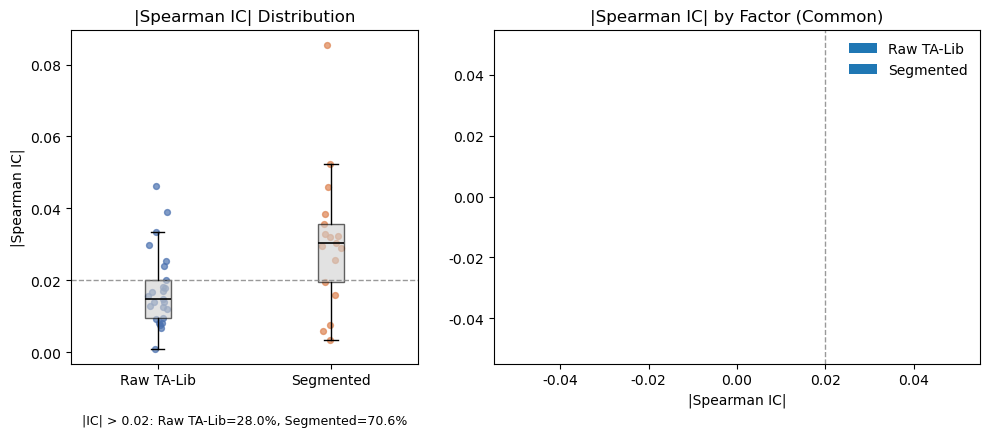

In [42]:
s_raw = (corr_check(family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


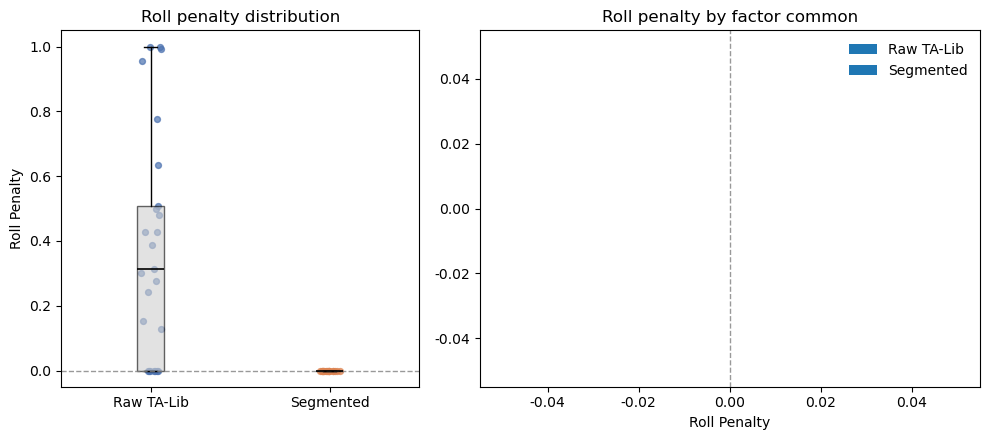

In [43]:
s_raw = (corr_check(family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Higher Frequency**

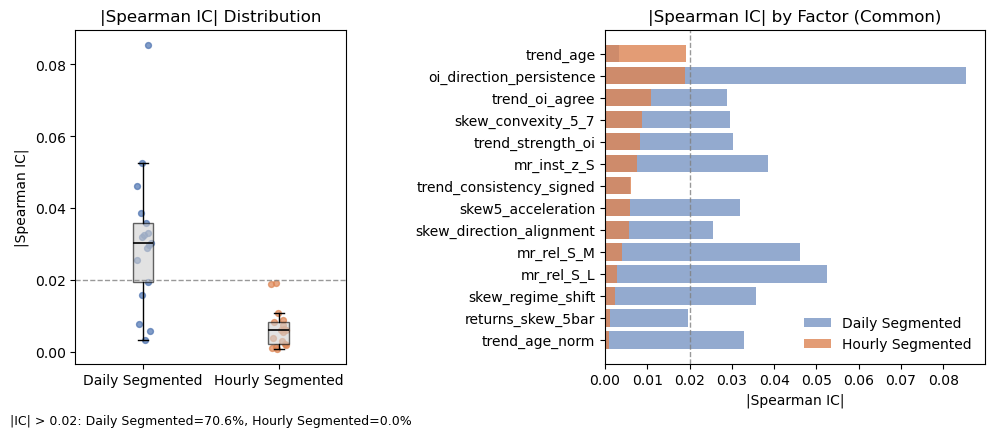

In [44]:
s_day = (corr_check(family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

Using the IF contract as an example, the segmented trend factors exhibit a slight increase in overall Spearman rank performance relative to traditional TA-Lib implementations. From a distributional perspective, the segmented formulation displays a more concentrated range of rank correlations, with roll penalties almost entirely eliminated. 

以沪深300（IF）合约为例，分段趋势因子在 Spearman 秩相关指标上的整体表现相较于传统 TA-Lib 版本略有提升。从分布形态来看，分段版本表现出更为集中的秩相关区间，同时滚动惩罚几乎完全消除 (相对）。

target 1 period next return created


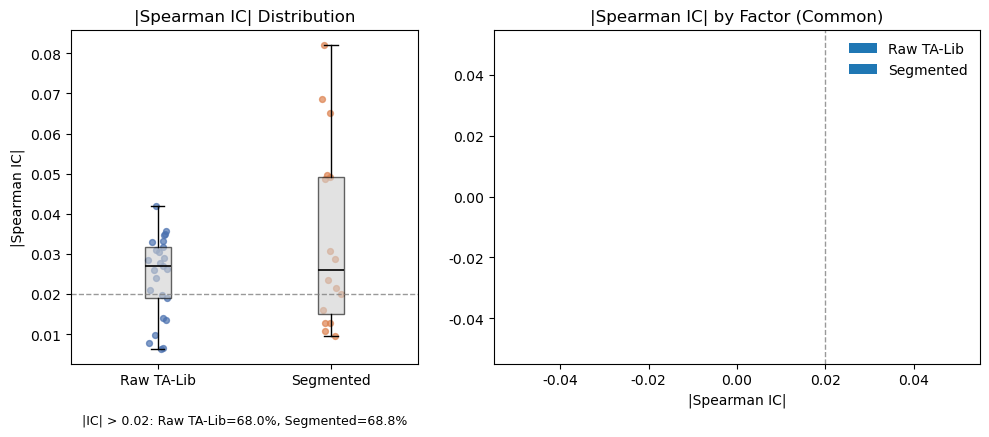

In [45]:
s_raw = (corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


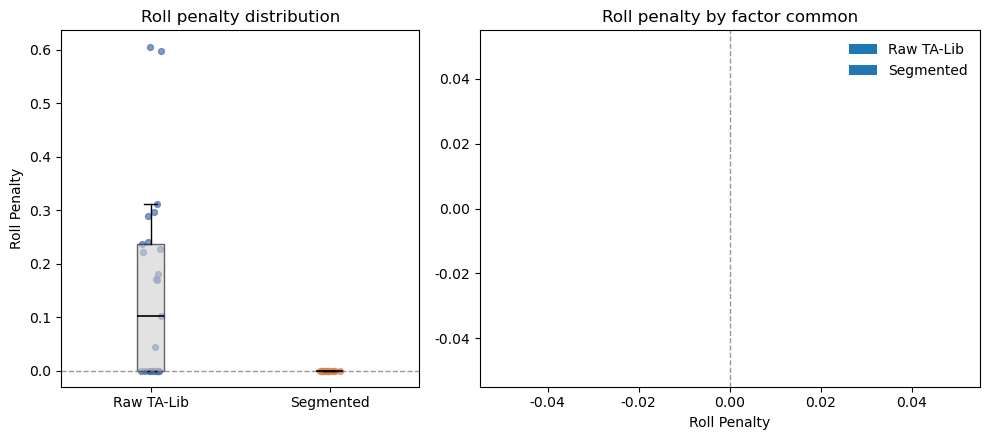

In [46]:
s_raw = (corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**SSE 50 Index Futures**

Consistent with the conclusions drawn for previous factor families, and when factor quality metrics such as roll penalty are not taken into account, trend-based factors on the IH contract exhibit overall weaker performance than traditional TA-Lib indicators. When evaluated solely using absolute Spearman rank correlation, segmented trend factors on IH show, for the first time, materially lower correlations than trend indicators constructed under the continuous-contract assumption. Further analysis suggests that this difference is more likely attributable to the intrinsic return characteristics of IH rather than to limitations of the segmented framework itself. In particular, IH displays a relatively low signal-to-noise ratio, characterized by a small mean return relative to volatility, while its tail distribution properties are also unfavorable for the formation of stable trends. As a result, directional signals are inherently constrained from a statistical perspective.

Although some TA-Lib trend indicators may achieve higher apparent Spearman values on IH by treating the dominant contract as a continuous time series, such performance is typically accompanied by pronounced roll sensitivity and severe cross-factor collinearity. From a conservative modeling standpoint, these correlations are better interpreted as statistical amplification arising from contract stitching, rather than as evidence of robust and interpretable trend structure.

Based on these considerations, this study does not attempt to forcibly construct trend signals for IH. Instead, a conservative principle is maintained: when the underlying return structure of an instrument does not support reliable trend inference, no artificially manufactured trend signal should be introduced into the model.

与前述因子类别的结论一致，在不考虑滚动惩罚等因子质量指标的前提下，IH 合约上的趋势类因子整体表现弱于传统 TA-Lib 版本。在以绝对 Spearman 秩相关作为评价标准的情形下，分段趋势因子在 IH 上的相关性水平首次显著低于在连续合约假设下构建的趋势指标。进一步分析表明，这一差异更可能源于 IH 自身的收益统计特征，而非分段建模方法本身的问题。具体而言，IH 合约整体呈现出较低的信噪比（Signal-to-Noise Ratio），表现为单期收益均值相对于波动率水平偏低；同时，其收益分布的尾部特征（tail ratio）亦不利于稳定趋势的形成，从而使方向性信号在统计意义上天然受限。

尽管在将主力合约视为连续时间序列的设定下，部分 TA-Lib 趋势指标在 IH 上可能获得更高的表观 Spearman 值，但该结果(如前所示）通常伴随着显著的换月敏感性以及严重的因子共线性问题。从保守建模的角度看，此类相关性更多反映的是价格振幅在合约拼接过程中的统计放大效应，而非真实、可解释的趋势结构。

基于上述考虑，本文并未尝试针对 IH 强行构造趋势信号，而是继续采取更为保守的处理原则：当标的资产自身的收益结构不足以支持稳定的趋势推断时，不向模型注入人为制造的趋势信息。

target 1 period next return created


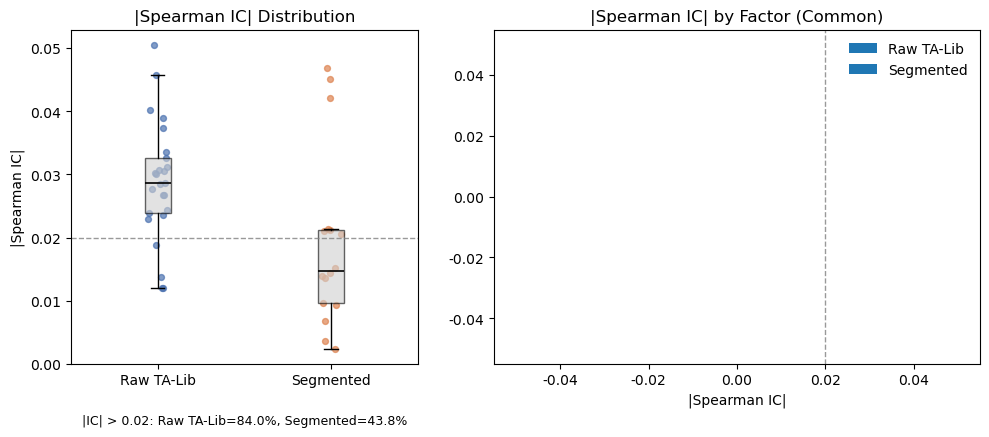

In [47]:
s_raw = (corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


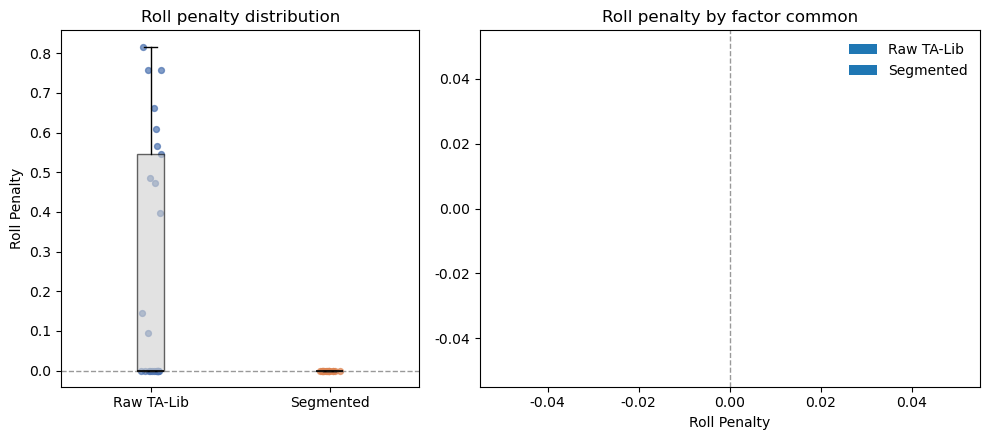

In [48]:
s_raw = (corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="trend",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

#### **Regression**

During factor research, we identified a class of indicators based on linear regression of price against time, such as LINEARREG_SLOPE (pt=α+βt+ϵ over window [t−w,t]), as having notable analytical value. These indicators are more appropriately understood as data-inferred trend descriptors, rather than conventional forecasting signals. Although regressing price directly on time may appear counterintuitive in form, this construction reflects a classical geometric approximation of financial time series: over sufficiently short horizons, price dynamics can be locally decomposed into a trend component and a stochastic disturbance.

Under this framework, the estimated regression slope should not be interpreted as a structural parameter with stable economic meaning, nor should it be directly regarded as a forecast of future returns. Instead, it provides a data-driven characterization of the direction, smoothness, and temporal coherence of price movement within a finite window, thereby offering a descriptive view of the trend geometry and market state of the price process.

Similar to Hilbert-transform-based cycle diagnostics, regression-derived slope statistics often exhibit pronounced time variation and non-stationarity in the presence of noise, structural breaks, and contract roll mechanisms. Importantly, this instability does not imply a loss of information. Rather, both the stability and the breakdown of the inferred trend carry state information: sustained and smooth slope estimates are typically associated with coherent trend regimes, whereas rapid reversals or amplified fluctuations may signal regime transitions, structural disturbances, or liquidity and roll-related effects.

在因子研究过程中，我们注意到一类基于价格关于时间进行线性回归的指标（如 LINEARREG_SLOPE）具有较强的分析价值。这类指标更适合被理解为基于数据推断的趋势描述工具，而非传统意义上的预测型信号。尽管将价格直接回归到时间变量上在形式上略显反直觉，但其背后反映的是一种经典的金融时间序列几何近似假设：在足够短的时间尺度内，价格演化可以被近似分解为趋势成分与随机扰动项的叠加。

在这一框架下，回归得到的斜率系数不应被视为具有稳定经济含义的结构性参数，也不宜被直接解读为对未来收益的预测。更合理的理解是，该斜率刻画了有限窗口内价格运动的方向性、平滑性与时间一致性，从而为价格序列的趋势几何特征与市场状态提供了一种数据驱动的描述。

与 Hilbert 变换类周期诊断指标类似，线性回归斜率等回归型统计量在噪声、结构性断点及合约换月等现实市场条件下，往往呈现出明显的时变性与非稳态特征。然而，这种不稳定性并非信息缺失，而是状态信息本身的体现：当斜率估计在滚动窗口内保持稳定和平滑时，通常对应较为清晰的趋势结构；而当斜率出现快速反转或波动放大时，则可能反映状态切换、结构扰动，或流动性压力与换月邻域效应等机制。

#### **Feature Design**

**Inferred Drift**

As discussed earlier, LinReg_Slope factors are included as simple, data-inferred trend descriptors, intended to characterize local drift and trend state rather than to serve as standalone predictive signals.

如前文所述，LinReg_Slope 因子被视为一种简单的、基于数据推断的趋势描述变量，用于刻画价格序列的局部漂移与趋势状态，而非作为独立的预测型信号。

| Factor | Definition | Measures | Interpretation |
|------|-----------|----------|----------------|
| LinReg_Slope_5 | Linear regression slope of log-price against time over a 5-period window | Short-horizon inferred drift | Positive values indicate short-term upward trend; negative values indicate downward drift |
| LinReg_Slope_10 | Linear regression slope of log-price against time over a 10-period window | Medium-horizon inferred drift | Captures more stable directional bias, less sensitive to short-term noise |
| LinReg_Slope_20 (minutes only) | Linear regression slope of log-price against time over a 20-period window | Long-horizon inferred drift | Reflects broader structural trend rather than short-term momentum |

**Stability**

Similar to the construction of Hilbert-based phase and period stability measures, the stability of linear regression–based trend estimates can be modeled in more informative ways than relying on the slope level alone. In particular, diagnostics such as goodness-of-fit, temporal consistency of the estimated slope, and changes in slope across sub-windows provide richer descriptions of trend stability and deformation.

Among these, slope change measures such as Slope_HalfDiff_10 explicitly compare trend estimates across adjacent sub-periods within the same horizon, allowing trend acceleration or exhaustion to be identified without mixing heterogeneous time scales. By contrast, comparing regression slopes across different window lengths often leads to excessive averaging effects, which can obscure localized structural changes. Therefore, slope-difference constructions within a fixed horizon are preferred when characterizing regression trend stability.

类似于 Hilbert 相位与周期稳定性的构建思路，基于线性回归的趋势稳定性同样可以通过比单一斜率水平更丰富的方式进行刻画。除斜率本身外，诸如回归拟合优度（goodness-of-fit）、斜率估计的时间一致性以及不同子窗口间斜率变化等指标，能够更全面地反映趋势的稳定性与几何形态的演变。

其中，Slope_HalfDiff_10 等斜率变化指标通过在同一时间尺度内比较相邻子区间的趋势估计，有效刻画了趋势的加速、衰减或结构性转折，而不会引入不同时间尺度混合所带来的平均化效应。相比之下，直接比较不同窗口长度下的回归斜率，往往会因跨尺度平均而掩盖局部结构变化。因此，在刻画线性回归趋势稳定性时，更倾向于采用固定窗口内的斜率差分构造，而非跨周期的斜率对比。

| Factor | Definition | Measures | Interpretation |
|------|-----------|----------|----------------|
| Slope_HalfDiff_10 | Difference between recent and earlier half-window regression slopes | Trend acceleration or deceleration | Positive values indicate trend strengthening; negative values suggest exhaustion or reversal |
| Rolling_R2_5 | R² of short-horizon regression | Short-term trend coherence | High values imply smooth, well-defined trend; low values indicate choppy behavior |
| Rolling_R2_10 | R² of medium-horizon regression | Medium-term trend coherence | Measures structural consistency of the inferred trend |
| Rolling_R2_20 | R² of long-horizon regression | Long-term trend coherence | High values correspond to stable, persistent trend regimes |
| Slope_Acceleration (minutes only) | First difference of long-horizon slope | Change in long-term trend state | Large absolute values signal rapid structural changes in trend dynamics |
| Residual_Vol_5 | Volatility of regression residuals over 5 periods | Short-horizon path noise | High values indicate unstable or noisy price movement relative to trend |
| Residual_Vol_10 | Volatility of regression residuals over 10 periods | Medium-horizon path noise | Captures sustained deviation from smooth drift |
| Residual_Vol_20 | Volatility of regression residuals over 20 periods | Long-horizon path noise | Often associated with regime instability or structural breaks |
| LinReg_Residual_Z_5 | One-period deviation from short-horizon expected drift, normalized by residual volatility | Instantaneous standardized surprise | Large absolute values capture shocks or liquidity-driven dislocations |
| LinReg_Residual_Z_10 | One-period deviation from medium-horizon expected drift, normalized by residual volatility | Medium-horizon standardized surprise | Highlights price moves inconsistent with prevailing trend geometry |

**Persistent**

Earlier trend-related constructs, such as trend probability, are designed to assess the likelihood or confidence that a trend-like structure is present at a given point in time. These measures focus on whether a trend exists and how strong it appears, often by aggregating multiple contemporaneous signals into a single assessment.

Persistence measures address a different but complementary question: once a trend, slope configuration, or deviation pattern has been identified, does this state tend to continue or revert over time? Rather than re-evaluating the existence of a trend, persistence diagnostics examine the temporal continuity of regression-inferred behavior.

By measuring persistence at the level of returns, inferred slopes, and residual signs, this class of factors provides a regression-based view of state durability. This perspective helps distinguish short-lived fluctuations from behaviors that exhibit regime-level consistency. In this sense, persistence does not redefine trend probability; instead, it serves as a time-consistency check on already-identified trend or deformation states.

先前定义的趋势相关指标主要用于评估某一时点上趋势结构是否存在，以及其置信程度和强弱水平。这类指标关注的是趋势“是否成立”，通常通过对多种同步信号进行聚合，形成对当前趋势状态的整体判断。

**持续性指标**关注的是一个不同但互补的问题：当某种趋势形态、斜率结构或偏离模式已经被识别之后，该状态在时间上更可能延续，还是更容易发生反转。与趋势概率侧重重新判断趋势是否存在不同，持续性度量强调的是回归推断状态在时间维度上的一致性与延续性。

通过在收益、回归斜率以及残差符号层面刻画持续性特征，这类因子从回归视角补充刻画了趋势或形变状态的耐久性，从而有助于区分短暂扰动与具有状态一致性的行为模式。因此，持续性并非对趋势概率的重复定义，而是对已识别趋势或偏离状态的时间稳定性检验。

| Factor | Definition | Measures | Interpretation |
|------|-----------|----------|----------------|
| Return_ACF1_5 | First-lag autocorrelation of returns over 5 periods | Short-term return persistence | Positive values suggest momentum-like behavior; negative values imply mean reversion |
| Return_ACF1_10 | First-lag autocorrelation of returns over 10 periods | Medium-term return persistence | Reflects regime-level serial dependence |
| Return_ACF1_20 | First-lag autocorrelation of returns over 20 periods | Long-horizon return persistence | Captures slow-moving structural dependence |
| Slope_ACF1_10 | First-lag autocorrelation of regression slope | Persistence of inferred trend state | High values indicate stable trend regimes; low values imply frequent reconfiguration |
| Resid_Sign_ACF1_10 | Autocorrelation of residual sign | Directional persistence of surprises | Sustained one-sided deviations may signal pressure buildup or regime transition |

**CSI 500 Index Futures**

In [49]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ic_main', family = 'reg', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=16)
target 1 period next return created
[coverage] kept 13/13 features (≥ 55%, n_eff ≥ 200); median coverage=82.71%, median n_eff=1938
Pearson Effective 46.15%
Spearman Effective 76.92%
Kendall Effective 46.15%
[selection] kept 8/13 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=13): 69.23%
roll_penalty     > 0.10 (all features, n=13): 0.00%


pearson  spearman   kendall  effective_pct  \
LinReg_Slope_5      -0.043503 -0.038986 -0.027392       1.000000   
LinReg_Slope_10     -0.017502 -0.029065 -0.019376       1.000000   
Rolling_R2_10        0.016491  0.026196  0.017709       1.000000   
Slope_HalfDiff_10   -0.024060 -0.036595 -0.025095       1.000000   
Residual_Vol_5      -0.002029  0.032034  0.020742       0.666667   
LinReg_Residual_Z_5  0.007003  0.038081  0.025231       0.666667   
Residual_Vol_10      0.053663  0.036309  0.024478       1.000000   
Slope_ACF1_10       -0.000888 -0.032625 -0.021715       0.666667   

                     year_spearman_min  year_spearman_max  sign_consistency  \
LinReg_Slope_5               -0.098117          -0.007811               1.0   
LinReg_Slope_10              -0.110213           0.024564               0.7   
Rolling_R2_10                -0.132214           0.098434               0.6   
Slope_HalfDiff_10            -0.161556           0.035506               0.6   
Residual_Vol_5               -0.035152           0.156509               0.6   
LinReg_Residual_Z_5          -0.095871           0.141756               0.7   
Residual_Vol_10              -0.018357           0.154193               0.9   
Slope_ACF1_10                -0.087496           0.121217               0.6   

                     roll_penalty  winsor_penalty  decile_LS_signed  \
LinReg_Slope_5                0.0        0.003232          0.000103   
LinReg_Slope_10               0.0        0.000000          0.001333   
Rolling_R2_10                 0.0        0.000000         -0.001852   
Slope_HalfDiff_10             0.0        0.000000          0.004425   
Residual_Vol_5                0.0        0.000000          0.000668   
LinReg_Residual_Z_5           0.0        0.000000          0.000585   
Residual_Vol_10               0.0        0.001893          0.002401   
Slope_ACF1_10                 0.0        0.001411         -0.001199   

                     decile_long_return  decile_short_return       QSL  
LinReg_Slope_5                 0.001495             0.001598  0.585177  
LinReg_Slope_10               -0.000766             0.000567  0.473535  
Rolling_R2_10                 -0.000673             0.001179  0.442593  
Slope_HalfDiff_10             -0.001893             0.002532  0.467701  
Residual_Vol_5                 0.001401             0.000733  0.452671  
LinReg_Residual_Z_5            0.001504             0.000919  0.452339  
Residual_Vol_10                0.002192            -0.000208  0.493511  
Slope_ACF1_10                 -0.000937            -0.002136  0.445063

In [50]:
corr_check(ticker = 'ic_main', family = 'reg', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 9/9 features (≥ 55%, n_eff ≥ 200); median coverage=99.06%, median n_eff=2320
Pearson Effective 33.33%
Spearman Effective 77.78%
Kendall Effective 44.44%
[selection] kept 3/9 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=9): 77.78%
roll_penalty     > 0.10 (all features, n=9): 44.44%


pearson  spearman   kendall  effective_pct  \
Realized_Quarticity_20  0.012788  0.051302  0.035143       0.666667   
Return_ACF1_20          0.019578  0.024236  0.015917       1.000000   
Residual_Vol_20        -0.014031  0.033525  0.022658       0.666667   

                        year_spearman_min  year_spearman_max  \
Realized_Quarticity_20          -0.062836           0.151266   
Return_ACF1_20                  -0.036211           0.085796   
Residual_Vol_20                 -0.091085           0.138357   

                        sign_consistency  roll_penalty  winsor_penalty  \
Realized_Quarticity_20               0.8           0.0        0.000924   
Return_ACF1_20                       0.6           0.0        0.000000   
Residual_Vol_20                      0.8           0.0        0.000360   

                        decile_LS_signed  decile_long_return  \
Realized_Quarticity_20          0.000289           -0.001138   
Return_ACF1_20                  0.001548           -0.000068   
Residual_Vol_20                -0.000357           -0.001478   

                        decile_short_return       QSL  
Realized_Quarticity_20            -0.001427  0.451063  
Return_ACF1_20                    -0.001617  0.477883  
Residual_Vol_20                   -0.001121  0.448536

Compared with the TA-Lib baseline, the regression-based factor set constructed on log-price demonstrates materially stronger robustness and structural consistency, rather than simple correlation strength. In the robust version, all features satisfy coverage and effective sample requirements, with zero roll penalty observed across the full feature set. Moreover, a larger fraction of features pass joint selection criteria on correlation magnitude, sign consistency, and roll sensitivity, indicating that the extracted signals are not driven by localized artifacts or contract mechanics.

By contrast, while the TA-Lib-based factors exhibit higher raw coverage and sign consistency in some cases, a substantial proportion of features suffer from non-negligible roll sensitivity, and fewer survive the joint selection filters. This suggests that many TA-Lib indicators implicitly mix heterogeneous regimes and contract boundaries, leading to apparent signal strength that is less stable under realistic futures trading conditions.


与 TA-Lib 基线版本相比，基于对数价格的回归型因子构造在稳健性与结构一致性方面表现出更为明显的优势，而非仅体现在相关性数值的提升上。在稳健版本中，全部因子均满足覆盖率与有效样本数要求，且在整体层面未观察到显著的换月惩罚。同时，在相关性强度、符号一致性与换月敏感性等联合筛选条件下，保留下来的因子比例更高，表明所提取的信号并非依赖于局部区间或合约机制驱动。

相比之下，TA-Lib 构造的因子在部分统计指标上虽表现出较高的覆盖率与符号一致性，但其中相当一部分因子对换月较为敏感，能够通过联合筛选的因子数量明显偏少。这一现象表明，部分 TA-Lib 指标在构造过程中隐含地混合了不同市场状态与合约边界，其表观信号强度在实际期货环境下的稳定性较弱。

target 1 period next return created


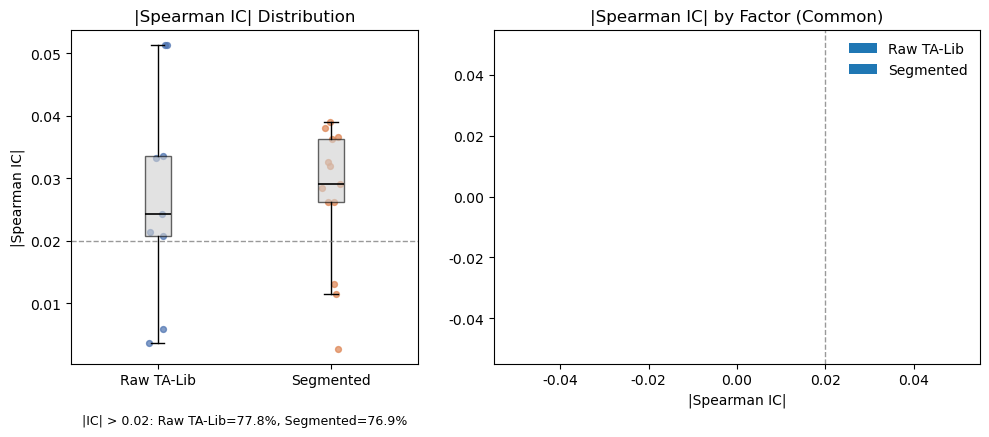

In [51]:
s_raw = (corr_check(ticker = 'ic_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


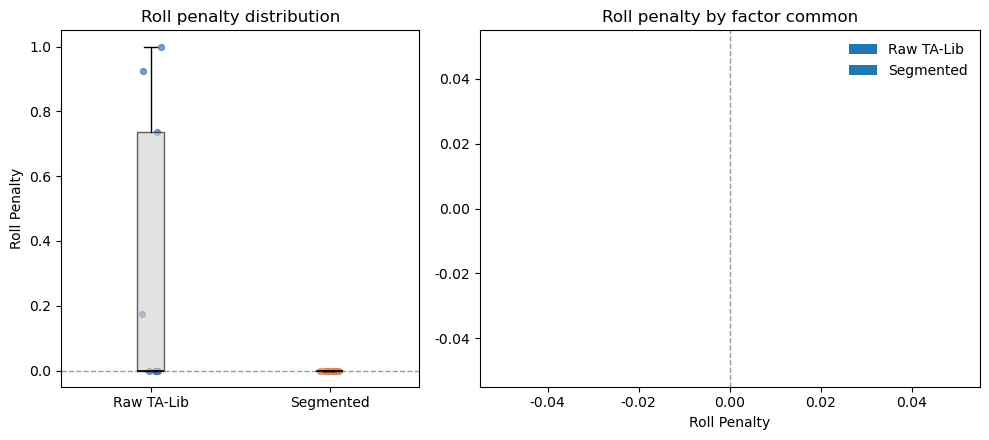

In [52]:
s_raw = (corr_check(ticker = 'ic_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Higher Frequency**

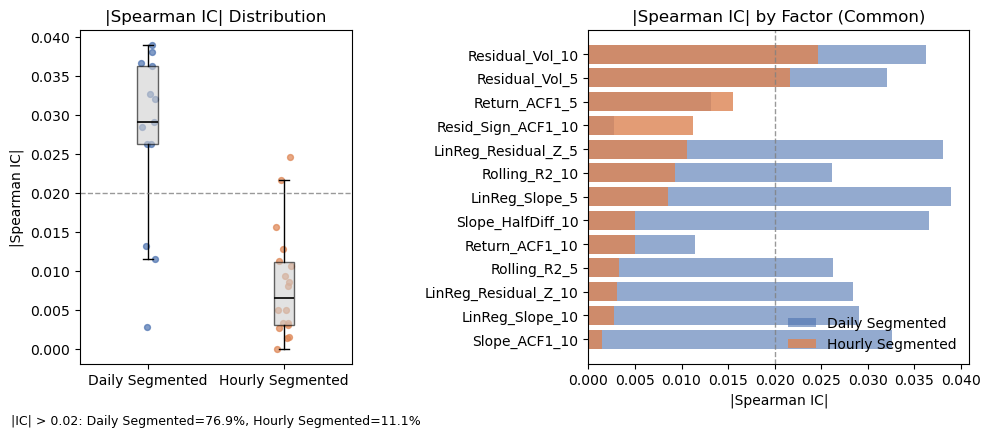

In [53]:
s_day = (corr_check(family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

On CSI 300 index futures (IF), the segmented regression-based factors exhibit slightly lower Spearman IC compared to the raw TA-Lib version, while achieving a substantial reduction in roll penalty. This trade-off is expected and economically reasonable. Notably, IF does not display strong sensitivity to regression-based trend signals in the first place, which is consistent with its underlying microstructure characteristics: relatively low return autocorrelation, modest signal-to-noise ratio, frequent gaps, and a more pronounced choppy trend profile compared to IC and IH. In such an environment, regression-inferred trends are naturally less persistent, limiting achievable rank correlation regardless of construction. Consequently, the observed IC reduction primarily reflects the removal of roll- and microstructure-driven pseudo-correlation, whereas the near-zero roll penalty indicates that the remaining signal is cleaner and more deployable under realistic trading conditions.

在 CSI 300 股指期货（IF） 上，分段回归构造的因子相较原始 TA-Lib 因子在 Spearman IC 上略有下降，但同时显著降低了换月惩罚。这一权衡是符合预期且具有经济合理性的。值得注意的是，IF 本身对回归型趋势信号并不表现出高度敏感性，这与其微观结构特征一致：收益自相关较弱、信噪比较低、跳空频率较高，且趋势更为破碎（choppy），相较 IC 与 IH 更难形成稳定的回归趋势。在此类市场环境中，回归推断的趋势天然不具备较强的持续性，因此无论采用何种构造方式，排序相关性的上限本身就较为有限。由此，IC 的小幅下降主要反映了对换月效应与微观结构噪声所放大伪相关性的剔除，而换月惩罚接近于零则表明剩余信号在实际交易条件下更加干净且可用。

target 1 period next return created


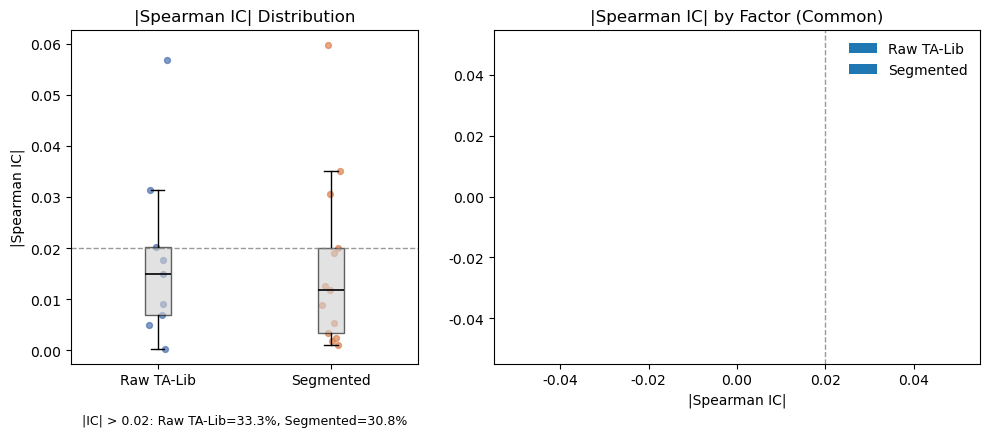

In [54]:
s_raw = (corr_check(ticker = 'if_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


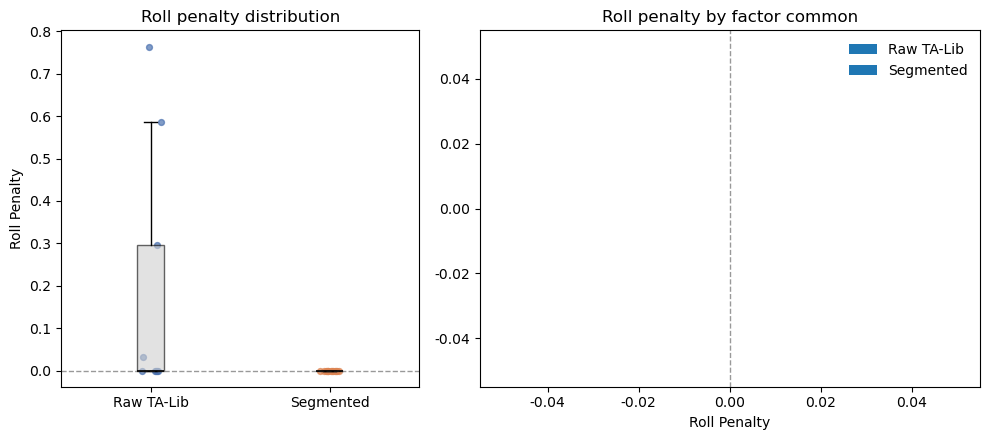

In [55]:
s_raw = (corr_check(ticker = 'if_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**SSE 50 Index Futures**

SSE 50 index futures (IH), segmented regression factors exhibit a clear and robust improvement in absolute Spearman IC—representing the first instance in which this class of regression-based trend diagnostics outperforms the raw TA-Lib construction. 

This behavior is economically explainable: IH displays stronger mean-reversion tendencies and more frequent state switching, and once roll-induced distortions are removed, regression-inferred states align more closely with the true price dynamics. As a result, both rank correlation and roll robustness improve simultaneously.

上证 50 股指期货（IH） 上，分段回归因子首次在 Spearman IC 的绝对水平上显著优于原始 TA-Lib 构造。这一现象具有明确的经济解释：IH 的价格行为更偏向于均值回复与频繁的状态切换，在去除换月干扰后，基于回归推断的状态刻画能够更准确地反映真实价格动力学，从而同时实现相关性提升与换月稳健性的改善。

target 1 period next return created


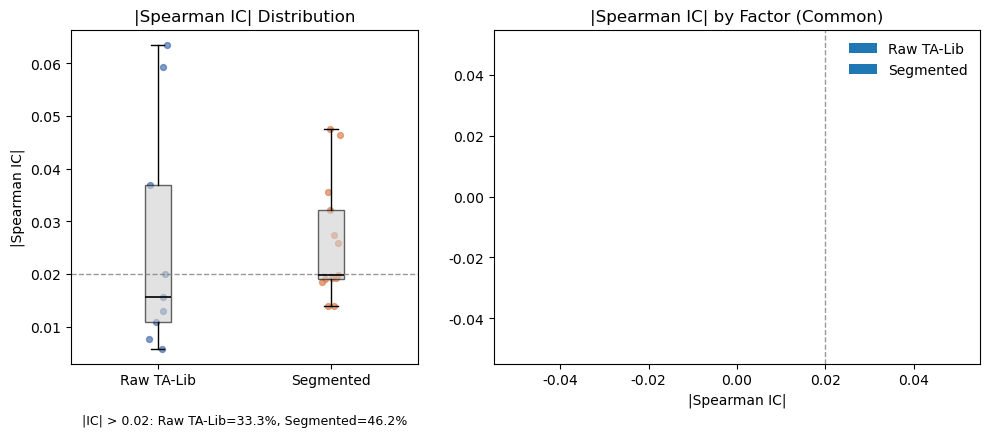

In [56]:
s_raw = (corr_check(ticker = 'ih_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


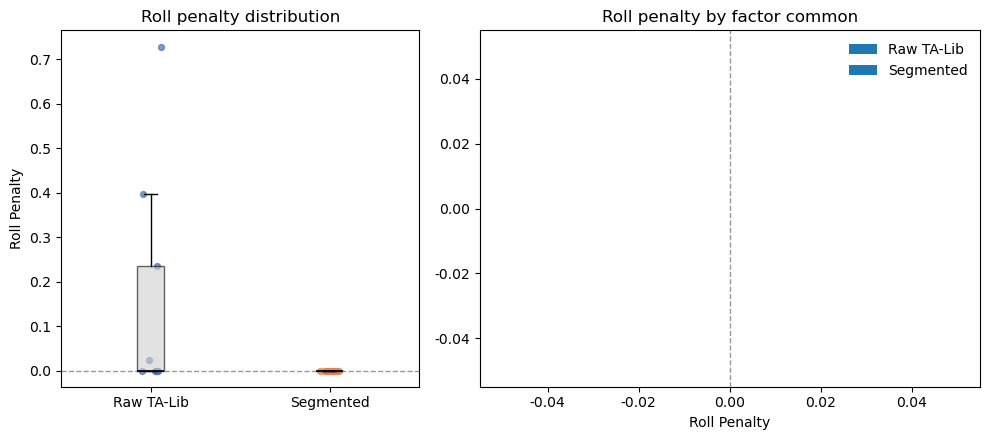

In [57]:
s_raw = (corr_check(ticker = 'ih_main', family="reg",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="reg",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

#### **Time Effects**

Time effects in financial markets are independent of price levels and return paths, yet they can systematically influence market behavior through mechanisms such as opening and closing dynamics, intra-week seasonality, and month-end or settlement effects. These effects rarely constitute stable standalone alpha signals, but they materially affect volatility, liquidity conditions, and the operating regime under which other factors function. Accordingly, time features are best treated as contextual and state-conditioning variables, rather than primary predictors.

金融市场中的时间效应独立于价格水平与收益路径本身，却会通过开盘与收盘行为、周内节律以及月末或结算相关效应等机制，系统性地影响市场行为。这类效应通常并不构成稳定的独立收益预测信号，但会显著影响波动水平、流动性状态以及其他因子的有效性。因此，时间因子更适合作为市场环境与状态刻画变量，而非主要的 alpha 来源。

**Circular Encoding for Periodic Variables**

For naturally periodic calendar variables such as day-of-week and month-of-year, we adopt circular (sin/cos) encoding to avoid spurious distance artifacts induced by linear representations. For example, in a linear scale, Friday and Monday appear far apart despite being temporally adjacent in trading rhythm. Circular embeddings preserve this topological continuity.

The encoding takes the form: Day_Sin = sin(2π × dayofweek / denom), Day_Cos = cos(2π × dayofweek / denom)

where denom = 5 is used for weekday-only markets (e.g., A-share index futures), and denom = 7 is applied in markets with weekend trading, determined automatically from the data. The same construction is applied to monthly cycles (Month_Sin, Month_Cos).

对于星期、月份等具有天然周期性的时间变量，我们采用 sin/cos 圆形编码，以避免线性编码所引入的伪距离问题。例如，在线性刻度下，周五与周一被错误地视为相距较远，而在真实交易节律中它们是时间上相邻的。圆形嵌入能够正确保持周期变量的拓扑连续性。

具体形式为： Day_Sin = sin(2π × dayofweek / denom)  Day_Cos = cos(2π × dayofweek / denom)

其中，denom = 5 用于仅在工作日交易的市场（如 A 股指数期货），denom = 7 用于包含周末交易的场景（由数据自动判定）。月份周期采用相同构造方式。

In intraday time modeling, we primarily rely on discrete, structured features to characterize trading sessions. Trading days in Chinese equity index and commodity futures markets do not follow a continuous clock; instead, they consist of clearly defined segments such as market open, midday break, and close. For most data frequencies, we deliberately avoid continuous phase encoding to prevent introducing artificial smoothness across non-trading intervals.

For higher-frequency data (minute, 5-minute, 10-minute, and 15-minute bars), we additionally provide relative intraday position–based phase encodings (Intraday_Sin/Cos), which help the model capture intraday cyclical patterns. These encodings are applied only within continuous trading sessions (e.g., the daytime session from 9:00 to 15:00) and never span non-trading gaps.

Accordingly, we adopt discrete trading-structure features to represent intraday states, including:

Market open and close indicators

Morning / afternoon session segmentation

Trading_Hour_Index: an ordinal index indicating the sequential position within the trading day, without implying a continuous phase assumption

This design effectively captures structural asymmetries in trading behavior while avoiding overly strong geometric constraints.


在日内时间建模中，我们主要使用离散的结构化特征来刻画交易时段。中国指数与商品期货市场的交易日并非连续时钟，而是由明确的开盘、午休、收盘等离散结构组成。对于大多数频率的数据，我们避免使用连续的相位编码，以防止在非交易时段引入人为的平滑性。
对于高频数据（分钟、5分钟、10分钟、15分钟），我们额外提供基于日内相对位置的相位编码（Intraday_Sin/Cos），这有助于模型捕捉日内周期模式。该编码仅针对连续交易时段（如日盘的9:00-15:00），不会跨越非交易间隔。。

因此，我们采用离散的交易结构特征来刻画日内状态，包括： 开盘与收盘标记, 上午 / 下午交易段划分 Trading_Hour_Index：交易日内的顺序位置索引（不隐含连续相位假设）该设计能够有效反映交易结构不对称性，同时避免引入过强的几何约束。

**CSI 500 Index Futures**

For CSI 500 index futures, time-based features exhibit a clear frequency-dependent IC profile. At the daily level, Month_End shows a more stable and mildly positive IC than Day_Sin, consistent with persistent month-end capital flow and institutional rebalancing effects. At the intraday level, Is_Opening, Is_Closing, and Trading_Hour_Index display low-magnitude Spearman ICs in the 0.02–0.03 range, yet with strong directional consistency, indicating a stable structural bias rather than random noise. Overall, the IC behavior of time features in CSI 500 is modest in magnitude but robust across samples, reflecting trading-stage asymmetries rather than smooth cyclical dynamics.

在 CSI 500 指数期货 上，时间类因子的 IC 表现呈现出清晰的频率分层特征：日频层面，Month_End 相较 Day_Sin 表现出更稳定且略偏正的 IC，反映了月末资金行为与制度性调仓带来的弱但持续的时间效应；日内层面，Is_Opening、Is_Closing 及 Trading_Hour_Index 的 Spearman IC 整体处于 0.02–0.03 的低幅区间，但方向一致性较高，说明其对收益方向的影响并非噪声，而是以结构性偏置形式稳定存在。整体来看，CSI 500 的时间因子 IC 幅度有限但跨样本稳定，体现为交易阶段差异而非连续周期振荡。

**CSI 300 Index Futures & SSE 50 Index Futures**

For CSI 300 (IF) and SSE 50 (IH) index futures, time-related ICs are almost entirely concentrated in the Month_End feature. This factor exhibits a stable positive Spearman IC (around 0.05) across both contracts, with strong year-to-year consistency and negligible roll sensitivity, indicating a classic month-end effect driven by institutional flows and index rebalancing. Other daily or intraday time features do not show statistically stable ICs, suggesting that for IF and IH, time effects are dominated by low-frequency, institutionally driven month-end behavior, rather than other structural patterns.

在 CSI 300（IF） 与 SSE 50（IH） 指数期货上，时间类因子的 IC 表现高度集中于 Month_End。该因子在两者上均呈现 稳定的正向 Spearman IC（约 0.05），并具有较高的年度一致性与接近于零的换月惩罚，表明其反映的是典型的月末资金与指数再平衡效应。除 Month_End 之外，其余日频或日内时间变量未表现出具有统计稳定性的 IC，说明在 IF 与 IH 上，时间效应主要体现在低频、制度驱动的月末行为，而非更细致的交易结构差异。

#### **Volatility**

In quantitative investment frameworks, traditional factors such as trend and momentum primarily capture directional information embedded in price series, reflecting the market’s explicit expectations of future returns. In real market environments, however, the asset pricing process often manifests earlier through changes in uncertainty and dynamic adjustments of risk premia. Especially during information-intensive periods or regime transitions, shifts in risk appetite, hedging demand, and liquidity conditions tend to be traded and reflected by the market prior to the emergence of clear price direction.

Volatility, as a direct proxy for risk and uncertainty, not only measures the magnitude of price fluctuations but also encapsulates critical information regarding risk structure, tail behavior, and market stability.

Accordingly, by incorporating volatility level, structural characteristics, higher-order moments, and regime transition features, volatility-based factors serve as a “risk state characterization module” within the overall framework. They provide conditional context and environmental interpretation for directional signals such as trend, momentum, and cycle factors, thereby enhancing the robustness and interpretability of the model across different market states.

在量化投资框架中，传统因子（如趋势、动量）主要刻画价格序列中的方向性信息，反映市场对未来收益的显性预期。然而，在真实市场环境中，资产定价过程往往更早地体现为不确定性变化与风险溢价的动态调整。尤其在信息密集或市场状态切换阶段，风险偏好、对冲需求及流动性条件的变化，通常先于价格方向本身被市场交易和反映。

波动率作为风险与不确定性的直接代理变量，不仅描述价格变动的幅度，还系统性地承载了风险结构、尾部行为以及市场稳定性等关键信息。

因此，通过引入波动率水平、波动结构、高阶矩及状态切换等多维特征，volatility 类因子在整体量化框架中承担“风险状态刻画模块”的角色，为趋势、动量及周期等方向性信号提供条件化约束与环境解释，从而提升模型在不同市场状态下的稳健性与可解释性。

**Magic Number Seven**

In the construction of volatility-based factors, statistical estimation typically exhibits strong data consumption characteristics. Unlike directional or level-based features, volatility is commonly characterized through second-order statistics such as rolling standard deviations, which require a sufficient number of contiguous observations to form a stable local distribution estimate. In data environments with segmented structures—such as contract rollovers in continuous futures series or treatments of abnormal price gaps—longer rolling windows are more likely to encounter issues of insufficient effective samples or unstable estimates. From an engineering perspective, this may manifest either as missing rolling estimates (e.g., when relatively strict min_periods thresholds are imposed), or as the need to rely on exponential moving average (EMA / EWMA)–based fallback estimators when sample availability is limited, depending on the specific implementation.

When the number of effective observations within a rolling window falls below a predefined threshold, a common fallback approach is to estimate volatility by applying exponential weighting separately to the first and second moments: an exponentially weighted mean of returns is first computed, followed by an exponentially weighted average of squared deviations from this mean to construct an exponentially weighted variance, whose square root is taken as the volatility estimate. The time scale of this EWMA estimator is governed by the exponential decay parameter—often characterized by its half-life or effective memory length—and therefore no longer strictly corresponds to the nominal rolling window length. In environments with dense segmentation, longer windows do not necessarily lead to a large number of missing values; instead, a more prevalent issue is the divergence between the nominal window size and the estimator’s effective time scale, which weakens both statistical interpretability and estimation stability.

Given these data structural and engineering constraints, we do not treat longer fixed windows as the default choice in daily-frequency volatility modeling. Instead, we prioritize the use of adjacent short-window combinations to characterize local volatility states: the shorter window captures instantaneous volatility levels, while the slightly longer window provides necessary smoothing and a local equilibrium reference without materially reducing sample coverage. Under current resource constraints and based on empirical evaluations—such as effective sample coverage and factor stability—using 7 as the relative upper bound in short-window combinations yields a robust trade-off between responsiveness, estimation stability, and sample utilization across most instruments. We emphasize that this window choice does not represent a globally optimal solution, but rather a reproducible and implementable empirical approach under the current data structure and engineering constraints.

在波动率因子的构建中，其统计估计通常具有较强的数据消耗特征。与方向性或水平类特征不同，波动率多通过滚动标准差等二阶统计量进行刻画，依赖于在连续区间内积累足够数量的有效样本以形成稳定的局部分布估计。在包含合约换月（连续合约拼接）、异常缺口处理等分段结构的数据环境中，较长滚动窗口更容易面临有效样本不足或估计不稳定的问题；在工程实现中，这可能表现为滚动估计结果缺失（如设置较高 min_periods），或在样本不足时需要采用指数加权平均（EMA / EWMA）等方式作为回退估计（具体取决于实现方案）。

当滚动窗口内的有效样本数低于设定阈值时，一种常见的回退方式是采用指数加权对一阶与二阶矩分别进行估计：先计算收益的指数加权均值，再对去均值后的平方项进行指数加权平均以构造指数加权方差，并取平方根作为波动率估计。该MA 估计的时间尺度由指数衰减参数（可用半衰期/有效记忆长度刻画）所决定，因而不再严格对应名义滚动窗口长度。在分段结构较为密集的情形下，较长窗口未必一定带来大量缺失值，但更常见的问题是名义窗口与实际有效时间尺度之间出现偏离，从而导致统计含义与稳定性下降。

基于上述数据结构与工程约束，我们在日频波动率建模中未将更长固定窗口作为默认选择，而是优先采用相邻短窗口组合来刻画局部波动状态：较短窗口用于反映即时波动水平，稍长窗口在不显著降低样本覆盖的前提下提供必要的平滑与局部均衡参考。结合当前资源约束下的实证评估（如有效样本覆盖率、因子表现稳定性等），将 7 作为短窗口组合中的相对上界在多数标的上能够在响应速度、估计稳定性与样本利用率之间取得较稳健的折中。需要强调的是，该窗口选择并非全局最优解，而是在当前数据结构与工程约束条件下的一种可复现、可落地的经验方案。

#### **Feature Design**

**Level (Magnitude)**

Volatility is commonly defined as the overall magnitude of price fluctuations and serves as a fundamental scale in risk state modeling. Given data segmentation and effective sample constraints, we prioritize short-horizon realized volatility and range-based measures to characterize local risk levels. By combining adjacent short windows through weighted aggregation, this design preserves responsiveness to risk changes while effectively reducing estimation noise and instability.

波动率通常被定义为价格变动的整体幅度，是风险状态建模中的基础量纲。受数据分段结构与有效样本约束的影响，在该类因子的构建中我们优先采用短周期的实现波动率与区间波动指标来刻画局部风险水平，并通过相邻窗口的加权组合，在保持对风险变化快速响应的同时，有效降低估计噪声与不稳定性。

| Factor                | Definition                                                                            | Measures                                             | Interpretation                                                                                                                                                                                  |
| --------------------- | ------------------------------------------------------------------------------------- | ---------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| Vol_Composite_5_7 | Composite short-horizon realized volatility constructed from adjacent rolling windows | Local volatility level with reduced estimation noise | Represents the current intensity of market risk at a local time scale; the use of adjacent windows stabilizes short-term volatility estimates while preserving responsiveness to regime changes |
| ATR_r_5           | Average True Range computed over 5 periods using log-price ranges                     | Short-horizon range-based volatility                 | Captures intraperiod price dispersion and microstructure-driven risk; robust to directional bias and complementary to return-based volatility measures                                          |


**Volatility Shape**

Volatility shape features are designed to capture the internal geometry of risk rather than its absolute magnitude. By examining short–long volatility differentials, range dispersion, return–range balance, and price location within volatility envelopes, these factors help distinguish between accelerating, compressing, directional, and range-bound risk regimes. As such, they provide essential contextual information for interpreting volatility magnitude and conditioning downstream trend or mean-reversion signals.

波动率形态因子旨在刻画风险的内在几何形态，而非其绝对规模。通过刻画短长周期波动率差异、区间波动的离散程度、收益与价格区间之间的相对关系，以及价格在波动区间中的位置，这类因子能够有效区分波动率加速、收敛、方向性主导及区间震荡等不同风险状态。因此，波动率结构类因子为理解波动率水平提供了关键的上下文信息，并为后续趋势或均值回归类信号提供了必要的条件化约束。

| Factor                     | Definition                                                                     | Measures                                             | Interpretation                                                                                                                |
| -------------------------- | ------------------------------------------------------------------------------ | ---------------------------------------------------- | ----------------------------------------------------------------------------------------------------------------------------- |
| Vol_Term_Structure_5_7 | Difference between short- and slightly longer-horizon realized volatility      | Local volatility term structure                      | Positive values indicate front-loaded or accelerating risk; negative values suggest volatility relaxation or mean reversion   |
| Range_CV_5             | Coefficient of variation of intrabar price ranges over a short horizon         | Dispersion of price ranges                           | High values indicate bursty or uneven intrabar volatility; low values reflect stable and homogeneous range behavior           |
| BB_%B_Pos_r_7          | Relative position of price within its recent volatility envelope               | Price location within conditional distribution       | Values near extremes indicate directional pressure; central values reflect balanced or mean-reverting conditions              |
| Range_to_RetVol_5 | Ratio of intrabar price range to close-to-close return volatility              | Efficiency of volatility transmission          | High values indicate oscillatory or inefficient price movement, where volatility is primarily absorbed intrabar rather than expressed through directional returns; low values suggest more efficient, directionally persistent regimes |
| Donchian_Z_7      | Standardized deviation of recent Donchian channel width from its local average | Expansion or compression of price distribution | High values reflect recent expansion of the price distribution relative to its baseline, indicating elevated dispersion; low values signal compression or coiling conditions associated with reduced volatility                        |
| Vol_of_Vol_7         | Short-horizon variability of realized volatility              | Stability of the volatility process       | High values indicate unstable or rapidly changing risk conditions; low values reflect smooth and persistent volatility regimes                                |
| Vol_Mean_Reversion_5v7 | Deviation of current volatility from its recent local average | Relative position in the volatility cycle | Positive values suggest elevated volatility relative to recent norms; negative values indicate suppressed volatility, often associated with buildup potential |



**Volatility Regimes**

Volatility regime features are designed to identify discrete risk environments characterized by abnormal, elevated, or accelerating volatility conditions. By applying simple threshold-based rules to short-horizon volatility and range measures, these indicators flag sudden volatility shocks, sustained high-risk states, and rapid volatility acceleration. Unlike continuous volatility descriptors, regime flags provide more interpretable signals that can be directly used for gating, conditioning, or risk control in downstream models.

波动率状态类因子用于识别离散的风险环境，重点刻画异常波动、持续高波动及波动率加速等典型情形。通过对短周期波动率与区间波动指标施加简单的阈值规则，这类因子能够标记突发性波动冲击、长期高风险状态以及波动率快速抬升阶段。相较于连续型波动率特征，状态类因子具有更强的可解释性，适用于下游模型中的信号筛选、条件化约束与风险控制。

| Factor                     | Definition                                                                                     | Measures                        | Interpretation                                                                                           |
| -------------------------- | ---------------------------------------------------------------------------------------------- | ------------------------------- | -------------------------------------------------------------------------------------------------------- |
| Vol_Spike_Regime      | Indicator for short-term volatility exceeding its recent local average by a significant margin | Sudden volatility shocks        | Flags abrupt volatility spikes often associated with events, news, or temporary market dislocations      |
| High_Volatility_Regime | Indicator for volatility being elevated relative to its longer-term distribution               | Sustained high-risk environment | Identifies persistent high-volatility regimes reflecting prolonged uncertainty or stress                 |
| Vol_Cross_5_over_7     | Indicator for short-horizon volatility exceeding a nearby longer horizon                       | Volatility acceleration         | Signals front-loaded or accelerating volatility, often preceding broader regime shifts                   |
| ATR_Burst_Flag         | Indicator for short-term range expansion relative to its local baseline                        | Intrabar range shocks           | Captures sudden expansions in price range, often linked to liquidity stress or microstructure disruption |


**Volatility Asymmetry**

Volatility magnitude, structure, and dynamics are typically constructed under symmetry assumptions and therefore provide limited insight into directional imbalance and temporal dependence in risk. To address this gap, we further introduce dependence and asymmetry features to characterize differential volatility responses to positive and negative returns, the co-movement between returns and volatility, and the clustering behavior of volatility shocks over time. These features offer complementary information for understanding how risk is transmitted and accumulated beyond symmetric volatility descriptions.

波动率水平、结构与动态类因子通常基于对称性假设，难以直接反映波动率在不同方向上的不均衡响应以及风险在时间上的依赖特征。因此，我们进一步引入依赖性与非对称性因子，用于刻画波动率对正负收益的差异化反应、收益与波动之间的联动关系以及波动率冲击在时间上的聚集现象，从而为理解风险的传导与积累机制提供有益补充。

| Factor                 | Definition                                                                                 | Measures                         | Interpretation                                                                                                             |
| ---------------------- | ------------------------------------------------------------------------------------------ | -------------------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| Vol_Asymmetry_5   | Normalized difference between upside and downside realized volatility over a short horizon | Directional volatility imbalance | Positive values indicate stronger volatility on positive returns; negative values indicate downside-dominated risk         |
| Downside_Semivar_7| Realized variance computed using only negative returns over a short horizon                | Downside risk concentration      | Captures the extent to which total risk is driven by negative return realizations, reflecting asymmetric downside exposure |
| Ret_Var_Corr_7    | Rolling correlation between returns and their squared values over a short horizon          | Return–volatility dependence     | Measures the degree to which returns co-move with volatility, often associated with leverage-like or risk-off behavior     |
| Vol_Clustering_7   | First-lag autocorrelation of absolute returns over a short horizon                         | Persistence of volatility shocks | High values indicate volatility clustering and sustained risk conditions                                                   |


**Higher Moment**

Finally, we introduce a small set of higher-moment features to explore the structural characteristics of tail risk. These factors are constructed from fourth-order return moments and are designed to capture the relative contribution of extreme price movements to overall risk. As higher-moment estimates are inherently sensitive to sample size and outliers, their statistical stability is generally weaker than that of variance-based measures. Accordingly, these features are treated as exploratory indicators of tail intensity and jump-driven risk, rather than primary risk descriptors within the overall framework.

最终，我们进一步引入少量高阶矩相关特征，用于探索尾部风险的结构性特征。这类因子基于收益的四阶矩构造，旨在刻画极端价格波动在整体风险中所占的相对比重。由于高阶矩估计对样本量及异常观测较为敏感，其统计稳定性通常弱于基于方差的风险指标，因此在整体框架中被视为对尾部强度与跳跃型风险的探索性刻画，而非核心风险描述变量。

| Factor | Definition | Measures | Interpretation |
|------|-----------|----------|----------------|
| Realized_Quarticity_5 | Normalized fourth moment of returns over a short horizon | Tail intensity of return distribution | High values indicate that extreme price movements contribute disproportionately to overall variance, suggesting jump-driven or heavy-tailed risk |
| Quarticity_Vol_Divergence_5 | Ratio of realized quarticity to short-term realized volatility | Tail risk relative to volatility level | Distinguishes smooth high-volatility regimes from environments dominated by spiky, extreme movements |

**CSI 500 Index Futures**

In [58]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ic_main', family = 'vol', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 19/19 features (≥ 55%, n_eff ≥ 200); median coverage=89.63%, median n_eff=2100
Pearson Effective 47.37%
Spearman Effective 78.95%
Kendall Effective 42.11%
[selection] kept 13/19 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=19): 84.21%
roll_penalty     > 0.10 (all features, n=19): 0.00%


pearson  spearman   kendall  effective_pct  \
Vol_Composite_5_7       0.007771  0.035562  0.023673       0.666667   
ATR_r_5                 0.009791  0.064522  0.044148       0.666667   
Vol_Term_Structure_5_7 -0.042611  0.026347  0.018682       1.000000   
Range_CV_5              0.027996  0.030566  0.020561       1.000000   
Range_to_RetVol_5      -0.049446  0.023682  0.015753       1.000000   
Donchian_Z_7            0.022220  0.054154  0.036085       1.000000   
BB_%B_Pos_r_7          -0.012973 -0.026773 -0.017795       0.666667   
Vol_Spike_Regime        0.031128  0.034929  0.028526       1.000000   
High_Volatility_Regime  0.035636  0.060595  0.049487       1.000000   
Vol_Cross_5_over_7      0.008422  0.023439  0.019142       0.666667   
ATR_Burst_Flag          0.017348  0.024076  0.019662       1.000000   
Vol_Asymmetry_5        -0.043386 -0.052219 -0.036506       1.000000   
Downside_Semivar_7      0.048229  0.053030  0.036383       1.000000   

                        year_spearman_min  year_spearman_max  \
Vol_Composite_5_7               -0.027728           0.093435   
ATR_r_5                         -0.017352           0.205567   
Vol_Term_Structure_5_7          -0.100065           0.134951   
Range_CV_5                      -0.088832           0.127380   
Range_to_RetVol_5               -0.069664           0.088919   
Donchian_Z_7                    -0.068926           0.144402   
BB_%B_Pos_r_7                   -0.068685           0.020603   
Vol_Spike_Regime                -0.037033           0.102184   
High_Volatility_Regime          -0.035437           0.179313   
Vol_Cross_5_over_7              -0.076767           0.146584   
ATR_Burst_Flag                  -0.046015           0.101637   
Vol_Asymmetry_5                 -0.112910           0.036223   
Downside_Semivar_7               0.024168           0.108641   

                        sign_consistency  roll_penalty  winsor_penalty  \
Vol_Composite_5_7                    0.8           0.0        0.000000   
ATR_r_5                              0.9           0.0        0.000000   
Vol_Term_Structure_5_7               0.6           0.0        0.000308   
Range_CV_5                           0.8           0.0        0.000000   
Range_to_RetVol_5                    0.6           0.0        0.000000   
Donchian_Z_7                         0.7           0.0        0.000000   
BB_%B_Pos_r_7                        0.8           0.0        0.000000   
Vol_Spike_Regime                     0.8           0.0        0.000000   
High_Volatility_Regime               0.9           0.0        0.000000   
Vol_Cross_5_over_7                   0.7           0.0        0.000000   
ATR_Burst_Flag                       0.7           0.0        1.000000   
Vol_Asymmetry_5                      0.9           0.0        0.000000   
Downside_Semivar_7                   1.0           0.0        0.003322   

                        decile_LS_signed  decile_long_return  \
Vol_Composite_5_7               0.001105            0.000792   
ATR_r_5                         0.000763           -0.000031   
Vol_Term_Structure_5_7         -0.000682            0.001653   
Range_CV_5                      0.001000            0.000349   
Range_to_RetVol_5              -0.000588            0.000810   
Donchian_Z_7                    0.003713            0.002437   
BB_%B_Pos_r_7                   0.001100            0.000189   
Vol_Spike_Regime                     NaN                 NaN   
High_Volatility_Regime               NaN                 NaN   
Vol_Cross_5_over_7                   NaN                 NaN   
ATR_Burst_Flag                       NaN                 NaN   
Vol_Asymmetry_5                 0.001355           -0.000077   
Downside_Semivar_7              0.001060            0.000777   

                        decile_short_return       QSL  
Vol_Composite_5_7                 -0.000313  0.513659  
ATR_r_5                           -0.000794  0.453052  
Vol_Term_Structure_5_7         

In [59]:
corr_check(ticker = 'ic_main', family = 'vol', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 9/9 features (≥ 55%, n_eff ≥ 200); median coverage=99.19%, median n_eff=2323
Pearson Effective 55.56%
Spearman Effective 88.89%
Kendall Effective 88.89%
[selection] kept 3/9 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=9): 88.89%
roll_penalty     > 0.10 (all features, n=9): 66.67%


pearson  spearman   kendall  effective_pct  \
NATR                0.015828  0.055190  0.038051            1.0   
BB_Width            0.021403  0.045556  0.030770            1.0   
Donchian_Width_ATR  0.035829  0.040421  0.027113            1.0   

                    year_spearman_min  year_spearman_max  sign_consistency  \
NATR                        -0.012644           0.188580               0.8   
BB_Width                    -0.103772           0.180145               0.8   
Donchian_Width_ATR          -0.126555           0.137610               0.7   

                    roll_penalty  winsor_penalty  decile_LS_signed  \
NATR                    0.049636        0.002296          0.001704   
BB_Width                0.000000        0.001233          0.000914   
Donchian_Width_ATR      0.000000        0.000000          0.002335   

                    decile_long_return  decile_short_return       QSL  
NATR                         -0.000025            -0.001729  0.451623  
BB_Width                     -0.000508            -0.001422  0.453533  
Donchian_Width_ATR            0.001502            -0.000833  0.459341

From the results, although the Spearman IC of volatility factors declines moderately after segmentation, the signals remain statistically meaningful while roll penalties are almost entirely eliminated. This suggests that segmentation primarily removes performance inflation induced by contract roll structures rather than erasing genuine predictive information.

For high-volatility instruments such as IC500, treating the main contract as a continuous time series tends to implicitly embed roll-related effects into volatility measures, thereby overstating apparent predictive power. This also helps explain why the original implementation shows a Spearman significance rate above 88%, yet only 3 out of 9 factors survive under stricter screening criteria (e.g., |ρ| > 0.02, sign > 0.55, roll < 0.20).

从结果来看，分段化处理后波动率因子的 Spearman IC 虽然出现了一定程度的回落，但整体仍保持稳定且具有统计意义，同时换月惩罚几乎被完全消除。这表明分段化处理主要剔除了由换月结构所引入的性能膨胀，而并未破坏因子本身所包含的有效信息。

在高波动率标的（如 IC500）中，若将主力合约简单视为连续时间序列，波动率类因子往往会隐含地学习到换月相关的结构性变化，从而高估其预测能力。这一现象也能够解释为何在原始实现中，Spearman 显著度表面上超过 88%，但在引入更为严格的筛选条件（如 |ρ| > 0.02、sign > 0.55、roll < 0.20）后，仅有 3/9 的因子能够被保留下来。

target 1 period next return created


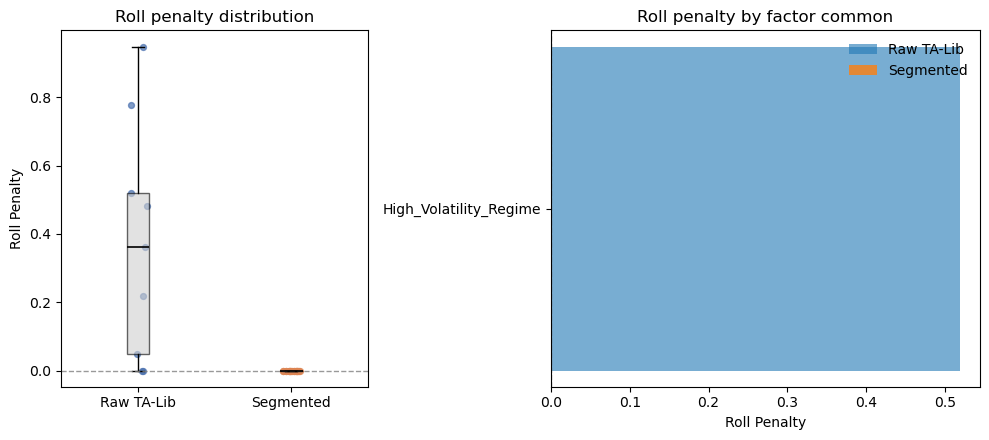

In [60]:
s_raw = (corr_check(ticker = 'ic_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Higher Frequency**

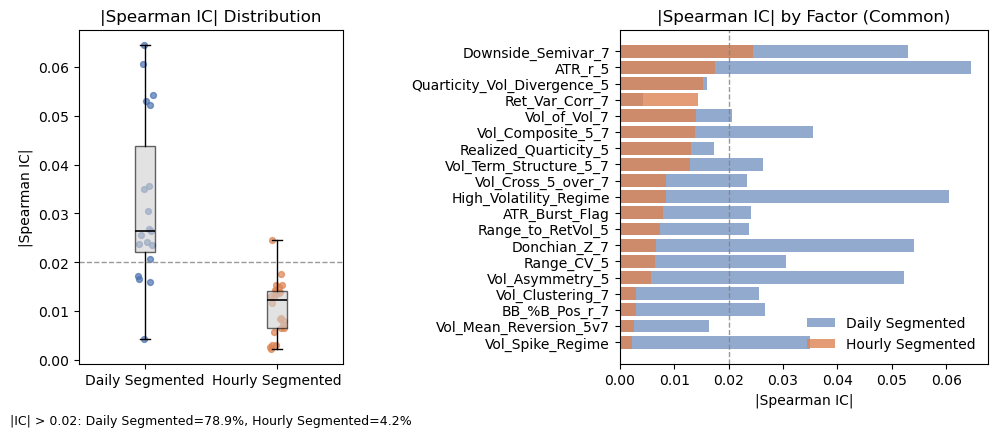

In [61]:
s_day = (corr_check(family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

For relatively low-volatility and structurally stable instruments such as CSI 300 futures, segmentation not only preserves the predictive ability of volatility factors but also leads to a noticeable improvement in the stability and effective proportion of Spearman IC. This result suggests that, under such market conditions, volatility factors exhibit good adaptability and cross-period consistency. After removing structural noise associated with contract rolls, these factors are able to characterize the underlying risk state in a more stable and coherent manner.

在 CSI 300 这类相对低波动、结构更为平稳的标的中，分段化处理不仅未削弱波动率因子的预测能力，反而在一定程度上提升了其 Spearman IC 的稳定性与有效占比。这表明波动率因子在该类市场环境下具有较好的适应性与可迁移性，能够在剔除换月等结构性噪声后，更稳定地刻画真实的风险状态。

target 1 period next return created


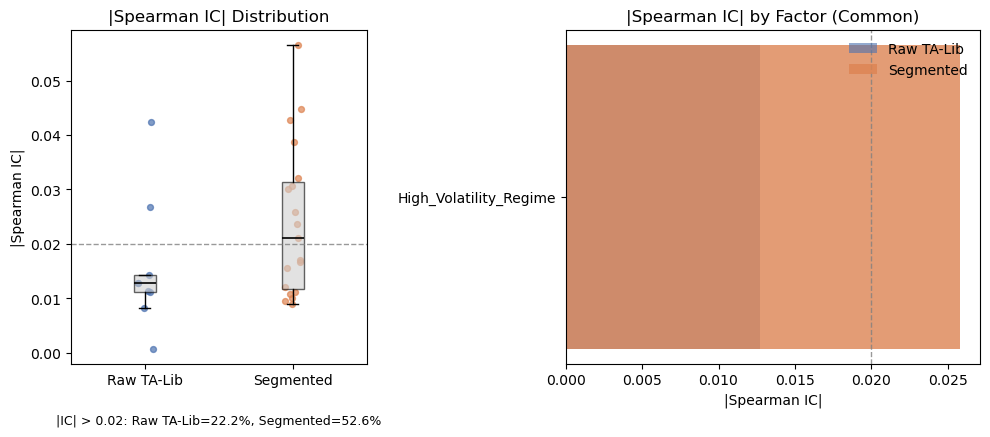

In [62]:
s_raw = (corr_check(ticker = 'if_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common =  plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


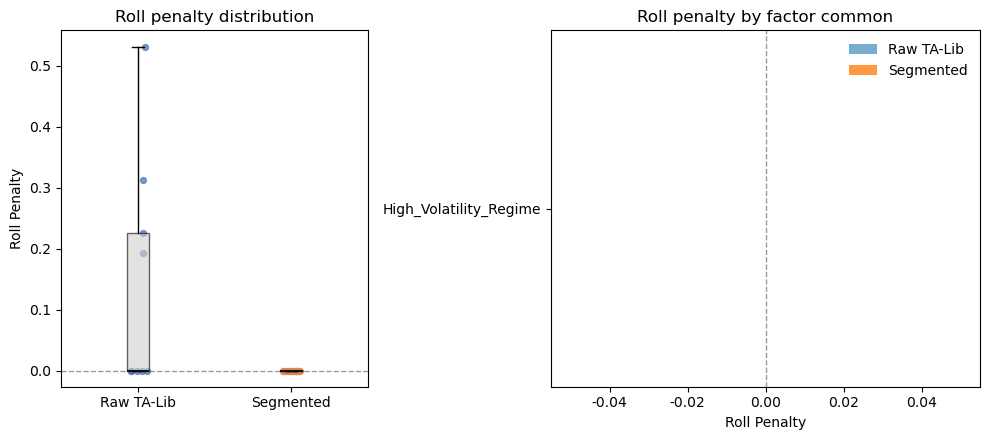

In [63]:
s_raw = (corr_check(ticker = 'if_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**SSE 50 Index Futures**

The SSE 50 results closely mirror those of CSI 300, suggesting that both contracts share similar low-volatility and structurally stable regimes, under which segmentation consistently improves volatility signal quality.

SSE 50 的表现与 CSI 300 高度一致：分段化处理在显著消除换月惩罚的同时，提升了 Spearman IC 的稳定性与有效占比。这表明两者在波动率水平与结构特征上具有相似性，分段化对其波动率因子的作用机制亦基本一致。

target 1 period next return created


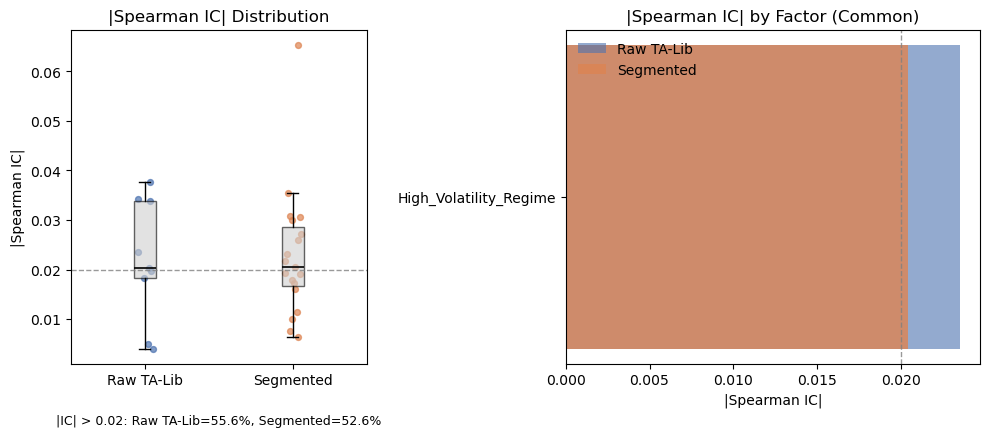

In [64]:
s_raw = (corr_check(ticker = 'ih_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


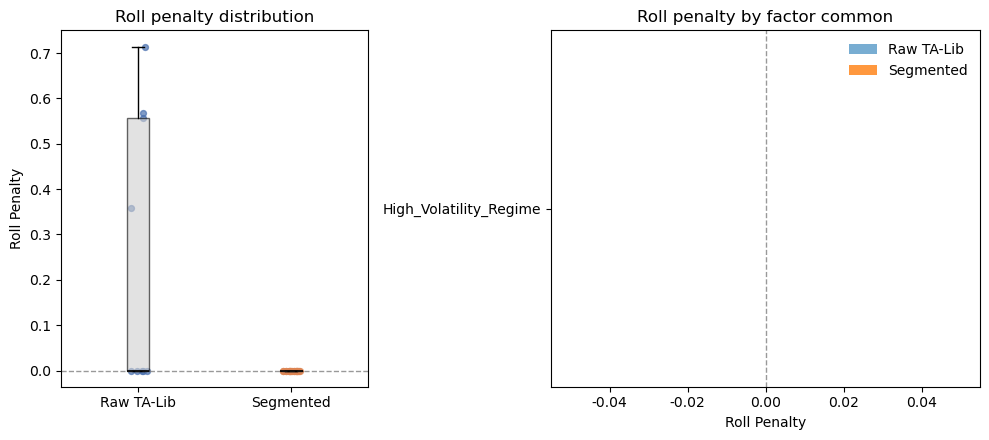

In [65]:
s_raw = (corr_check(ticker = 'ih_main', family="vol",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="vol",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

#### **Intraday**

In the construction of volatility factors, we already incorporate intraday range-based information such as ATR and high–low ranges to characterize how risk aggregates over time. While these measures rely on intraday prices, their modeling objective remains cross-bar volatility estimation, primarily addressing the question of “how large the fluctuations are.”

Building on the same range-based concept, the intraday structure factors further shift the focus to the single-bar level in order to describe how price movement is realized at a finer temporal scale. Rather than measuring range magnitude alone, this module provides a structured representation of intrabar price behavior, including close location, shadow geometry, range expansion, and gap-related pressure.

At the intraday scale, we additionally introduce range-based volatility estimators derived from high–low prices, such as Parkinson volatility, as a complement to traditional close-to-close measures. By efficiently utilizing range information without imposing directional assumptions, these estimators serve as suitable proxies for bar-level risk intensity.

在波动率因子的构建中，我们已经引入了部分源自日内价格区间的信息，例如 ATR、high–low range 等，用于刻画风险在时间维度上的聚合强度。这类指标虽然依赖日内数据，但其建模目标仍是跨多根 K 线的波动率刻画，核心在于回答“波动有多大”的问题。

在此基础上，日内结构类因子沿用相同的区间信息概念，但将关注点进一步下沉至单根 K 线尺度，用以刻画稍高频层面上价格变化的具体实现方式。该模块不再仅关注区间大小本身，而是对价格在区间内部的运行路径进行结构化描述，包括收盘位置、影线分布、区间扩张以及缺口压力等特征。

同时，在日内尺度下我们引入了基于高低价区间的波动率估计方法（如 Parkinson 波动率），作为对传统基于收盘价变动的波动率指标的补充。该类估计在忽略方向性的前提下，更高效地利用区间信息，适合作为单根 K 线层面风险强度的代理变量。

#### **Feature Design**

**Candle Geometry**

From a risk characterization perspective, bars with similar range magnitude may still correspond to very different market conditions. Body-dominated bars often reflect concentrated directional pressure, whereas bars with large shadows are more indicative of liquidity probing, transient shocks, or short-term order-flow imbalance. Candle geometry features aim to capture these differences in how risk is expressed within the same price range.

从风险刻画的角度看，即使在相同的区间波动强度下，不同的蜡烛结构往往对应着截然不同的市场状态。例如，实体主导的区间往往反映出方向性交易力量的集中释放，而影线占比偏高的区间则更多体现为流动性冲击、试探性交易或短期博弈行为。Candle Geometry 正是用于捕捉这类“区间内部风险表达方式”的差异。

| Factor                | Definition                                          | Measures                               | Interpretation                                                                                                             |
| --------------------- | --------------------------------------------------- | -------------------------------------- | -------------------------------------------------------------------------------------------------------------------------- |
| Range_Ratio       | Intrabar price range normalized by opening price    | Relative intrabar movement scale       | Higher values indicate larger price excursions relative to the opening level, reflecting stronger intrabar risk expression |
| Body_Ratio        | Candle body size normalized by total range          | Directional dominance within the range | High values suggest directional pressure dominates the bar; low values imply oscillatory or indecisive price action        |
| Lower_Shadow_Frac | Lower shadow length as a fraction of total range    | Downside probing intensity             | Large values indicate stronger downside testing or liquidity absorption at lower prices                                    |
| Upper_Shadow_Frac| Upper shadow length as a fraction of total range    | Upside probing intensity               | Large values reflect stronger upside testing or rejection near local highs                                                 |
| Wick_Imbalance   | Difference between upper and lower shadow fractions | Intrabar pressure asymmetry            | Positive values indicate stronger upside rejection; negative values imply stronger downside rejection                      |


**Gap & Open Pressure**

Gap and open pressure features characterize the deviation of the opening price from the prior close and its relative importance within the current intraday range. Rather than attempting to predict whether a price gap will persist or reverse, these features treat the opening gap as an initial condition that reflects the amount of risk pressure carried into the trading session.

Gap & Open Pressure 类特征用于刻画价格在开盘时刻相对于前一收盘的偏离程度及其在当前日内区间中的风险含义。该类因子并不试图预测缺口方向是否延续，而是将缺口视为一种初始条件，用于衡量开盘时刻所承载的风险压力及其相对于当日波动区间的重要性。

| Factor                 | Definition                                                        | Measures                  | Interpretation                                                                                                                         |
| ---------------------- | ----------------------------------------------------------------- | ------------------------- | -------------------------------------------------------------------------------------------------------------------------------------- |
| Open_Gap           | Opening price deviation relative to prior close                   | Opening displacement      | Captures the magnitude of price adjustment occurring at the session open                                                               |
| Open_Pressure_Norm | Opening deviation normalized by intraday range and local baseline | Relative opening pressure | High values indicate that opening risk is large relative to typical intraday movement, signaling concentrated risk release at the open |




**Intraday Volatility Proxy & World Quant**

Within the intraday structure module, we additionally introduce a small set of exploratory features to complement the characterization of bar-level risk intensity and structural extremeness. The motivation behind these features draws on classic high–low range-based estimators, such as Parkinson volatility, as well as early WorldQuant Alpha design ideas that emphasize structured representations of price extremeness.

It should be emphasized that these features are not treated as core volatility measures nor as standalone predictive signals. Instead, they serve as auxiliary structural descriptors of the intraday risk environment, providing additional context for how risk is expressed within individual bars.

在日内结构模块中，我们额外引入了少量探索性特征，用于补充刻画单根 K 线层面的风险强度与结构性极端状态。该类特征在构造动机上借鉴了部分经典的高低价区间估计方法（如 Parkinson 波动率），以及早期 WorldQuant Alpha 因子中对价格极端行为进行结构化刻画的设计思路。

需要强调的是，这些特征并不被视为核心波动率指标或独立的预测信号，其主要作用在于为日内风险环境提供辅助性的结构描述，用以补充对风险表达方式的理解。

| Factor                | Definition                                                            | Measures                 | Interpretation                                                                                                                                                         |
| --------------------- | --------------------------------------------------------------------- | ------------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| IV_Parkinson_7  | Short-window smoothed Parkinson volatility based on high–low range    | Bar-level risk intensity | Efficient proxy for intrabar volatility magnitude that utilizes high–low information without relying on directional returns                                            |
| High_Extreme_Flag | Indicator for price exceeding its recent intraday structural baseline | Structural extremeness   | Flags whether price is positioned at an unusually extended level relative to recent intraday structure, serving as a contextual marker rather than a predictive signal |


**CSI 500 Index Futures**

In [66]:
print('Robust Version: Modeling on Log Close')
corr_check(ticker = 'ic_main', family = 'intra', cls = treemodel_factors_augment, selection = True, light = False)

Robust Version: Modeling on Log Close
[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=12)
target 1 period next return created
[coverage] kept 9/9 features (≥ 55%, n_eff ≥ 200); median coverage=89.63%, median n_eff=2100
Pearson Effective 77.78%
Spearman Effective 55.56%
Kendall Effective 55.56%
[selection] kept 5/9 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=9): 66.67%
roll_penalty     > 0.10 (all features, n=9): 0.00%


pearson  spearman   kendall  effective_pct  \
Range_Ratio         0.045626  0.053530  0.036698            1.0   
Open_Gap           -0.078547  0.034079  0.023971            1.0   
Open_Pressure_Norm -0.048668 -0.030487 -0.020170            1.0   
IV_Parkinson_7      0.041749  0.065886  0.045196            1.0   
High_Extreme_Flag   0.035453  0.038797  0.031685            1.0   

                    year_spearman_min  year_spearman_max  sign_consistency  \
Range_Ratio                 -0.017083           0.187960               0.8   
Open_Gap                    -0.200832           0.131180               0.7   
Open_Pressure_Norm          -0.109687           0.082414               0.6   
IV_Parkinson_7              -0.008625           0.193295               0.9   
High_Extreme_Flag           -0.020964           0.160162               0.7   

                    roll_penalty  winsor_penalty  decile_LS_signed  \
Range_Ratio                  0.0        0.002465          0.003391   
Open_Gap                     0.0        0.000000          0.001195   
Open_Pressure_Norm           0.0        0.000806          0.004706   
IV_Parkinson_7               0.0        0.001806          0.003179   
High_Extreme_Flag            0.0        0.000000               NaN   

                    decile_long_return  decile_short_return       QSL  
Range_Ratio                   0.001926            -0.001465  0.463317  
Open_Gap                      0.000393            -0.000802  0.454779  
Open_Pressure_Norm           -0.001163             0.003543  0.468743  
IV_Parkinson_7                0.002017            -0.001162  0.462535  
High_Extreme_Flag                  NaN                  NaN  0.450000

In [67]:
corr_check(ticker = 'ic_main', family = 'intra', cls = treemodel_factors_daily, selection = True, light = False)

[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 7/7 features (≥ 55%, n_eff ≥ 200); median coverage=99.96%, median n_eff=2341
Pearson Effective 71.43%
Spearman Effective 57.14%
Kendall Effective 14.29%
[selection] kept 2/7 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=7): 71.43%
roll_penalty     > 0.10 (all features, n=7): 42.86%


pearson  spearman   kendall  effective_pct  \
High_Minus_Low  0.022215  0.079523  0.054622            1.0   
KUP             0.110899  0.024207  0.015665            1.0   

                year_spearman_min  year_spearman_max  sign_consistency  \
High_Minus_Low          -0.062531           0.159066               0.9   
KUP                     -0.053763           0.096744               0.6   

                roll_penalty  winsor_penalty  decile_LS_signed  \
High_Minus_Low      0.024809        0.001926          0.002732   
KUP                 0.000000        0.001152          0.001490   

                decile_long_return  decile_short_return       QSL  
High_Minus_Low            0.001222            -0.001510  0.458252  
KUP                       0.001418            -0.000073  0.455846

For high-volatility instruments such as IC (CSI 500), the post-segmentation behavior of intraday factors is highly consistent with what was previously observed in the volatility factor family. Many intraday structure features—such as range ratios, gap pressure, and Parkinson-type estimators—are constructed from single-bar or very short-horizon price dispersion, and therefore implicitly measure short-term volatility dynamics.

When the main contract is treated as a continuous time series, these factors tend to absorb price jumps and volatility discontinuities introduced by contract rollovers, leading to an inflation of Spearman IC at the statistical level. After applying segment-safe construction, this roll-induced performance inflation is effectively removed, resulting in a moderate decline in absolute IC.

Importantly, this decline does not indicate a loss of genuine factor information. Instead, segmentation substantially reduces roll penalty and yields a more conservative but structurally cleaner evaluation, allowing the remaining signal to more accurately reflect the factor’s true and reproducible information content.

对于 IC（中证 500） 这类高波动率标的，日内因子在分段化处理后的表现，与此前在波动率因子中观察到的结果高度一致。许多日内结构类因子（如区间比例、缺口压力、Parkinson 波动率等）基于单根 K 线或极短周期内的价格离散程度构造，在本质上隐含刻画的是短周期波动特征。 当主力合约被简单视为连续时间序列时，这类因子容易吸收换月过程中引入的价格跳变与波动不连续性，从而在统计上放大其 Spearman IC 表现。引入分段化（segment-safe）构造后，这部分由换月结构带来的性能膨胀被有效剔除，表现为绝对 IC 的一定回落。需要强调的是，该回落并不意味着因子信息的实质性削弱。相反，分段化处理显著降低了换月惩罚，使得因子评估更加保守，同时也更真实地反映了其可复现、可解释的有效信息含量。

target 1 period next return created


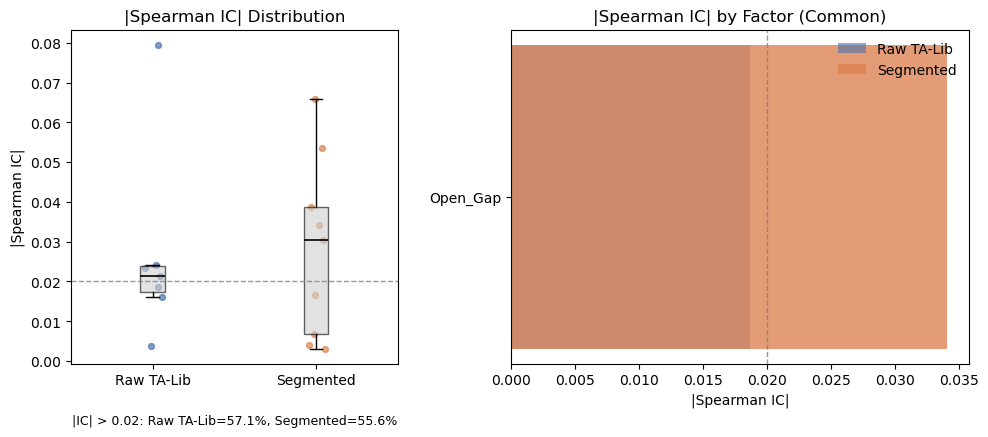

In [68]:
s_raw = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


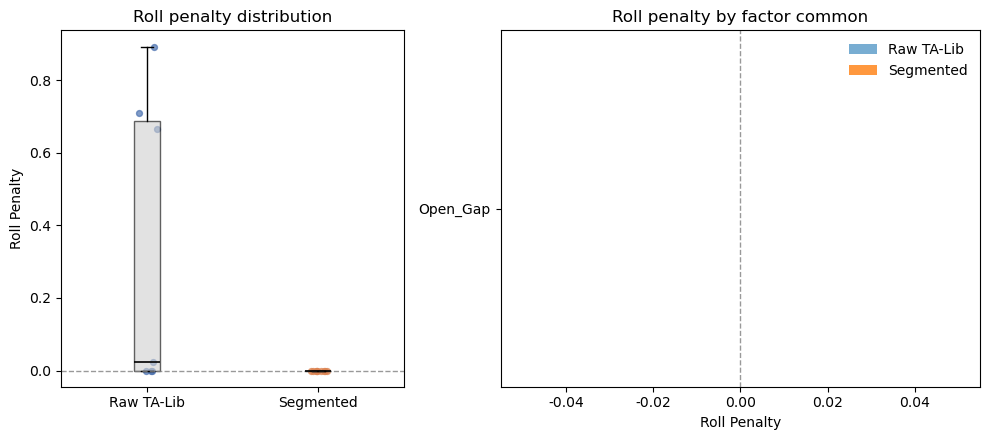

In [69]:
s_raw = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Higher Frequency**

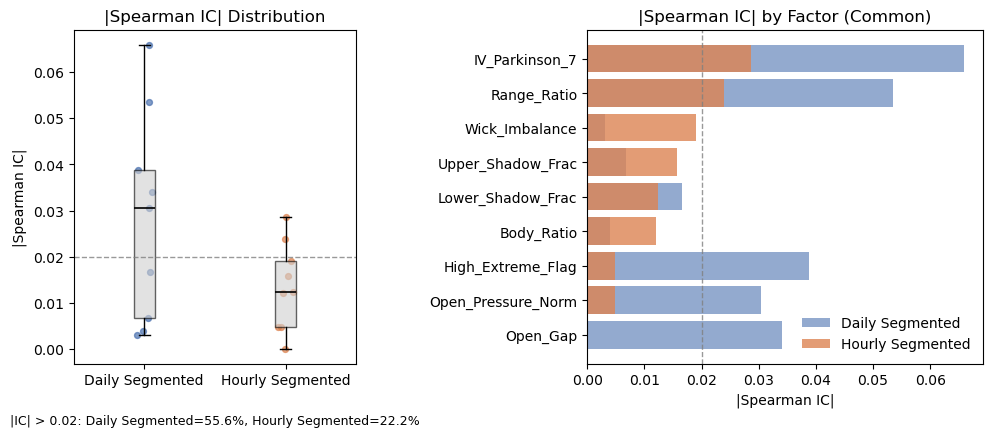

In [70]:
s_day = (corr_check(family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

For CSI 300 futures, which exhibit relatively low volatility and smoother contract transitions, segmentation leads to only marginal changes in Spearman IC, with no statistically meaningful improvement. This suggests that intraday structure factors in the raw continuous series were not strongly inflated by roll-related effects.
However, segmentation substantially reduces roll penalty while preserving factor effectiveness.

在 CSI 300 这类波动率较低、换月结构相对平稳的标的中，日内结构类因子在分段化处理后的 Spearman IC 表现仅出现轻微改善，整体变化不显著。这一结果表明，原始连续合约下的日内因子并未严重依赖换月结构所带来的性能膨胀。 但值得注意的是，分段化处理在几乎不影响因子有效性的前提下，显著消除了换月惩罚，使因子评估更加稳健与可比

target 1 period next return created


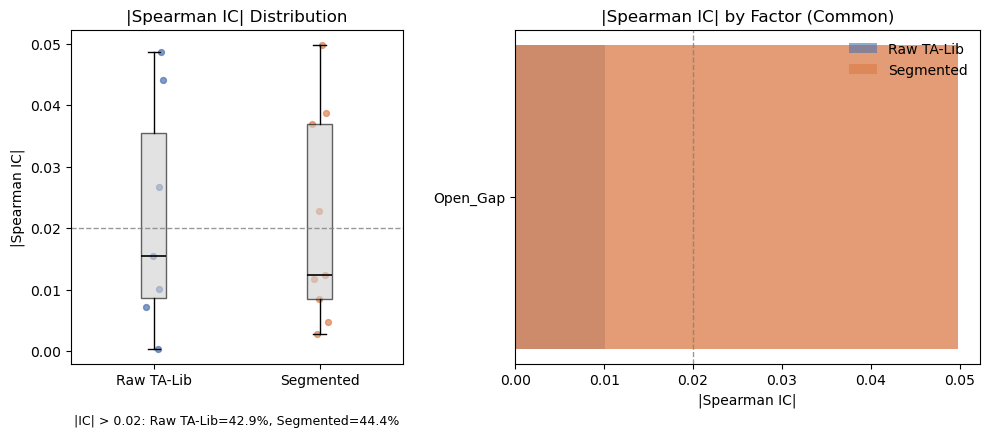

In [71]:
s_raw = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


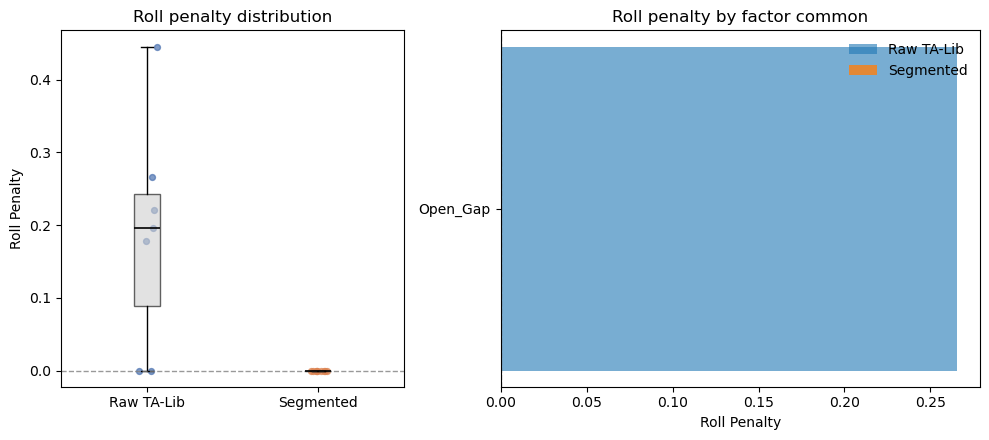

In [72]:
s_raw = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**SSE 50 Index Futures**

For instruments such as the SSE 50 (IH), which exhibit lower volatility and relatively smooth contract rollover dynamics, the performance of intraday structural factors remains highly consistent before and after segmentation. Both the distribution of Spearman IC and the proportion of effective signals show only marginal changes, indicating that these factors do not materially rely on roll-induced statistical amplification.

In this setting, the primary contribution of segmentation lies in eliminating rollover-related risk and penalty, rather than correcting inflated IC levels. This suggests that, for SSE 50, intraday factors predominantly capture genuine intraday price structure and microstructural behavior, with signals that are inherently cleaner and less contaminated by contract transition effects.

对于上证 50（IH）这类波动率较低、换月机制相对平稳的标的，日内结构类因子在分段化处理前后的表现高度一致。无论是 Spearman IC 的分布形态，还是有效因子占比，其变化幅度均较为有限。这一结果与上证 50 本身并未显著依赖换月结构所带来的统计放大效应密切相关。

在该类标的中，分段化处理的主要作用体现在系统性消除换月惩罚风险，而非对因子 IC 水平进行实质性修正。这表明，在上证 50 场景下，日内因子更多刻画的是真实的日内价格结构与微观交易行为，其信号来源相对干净，受合约切换等结构性噪声影响较小。

target 1 period next return created


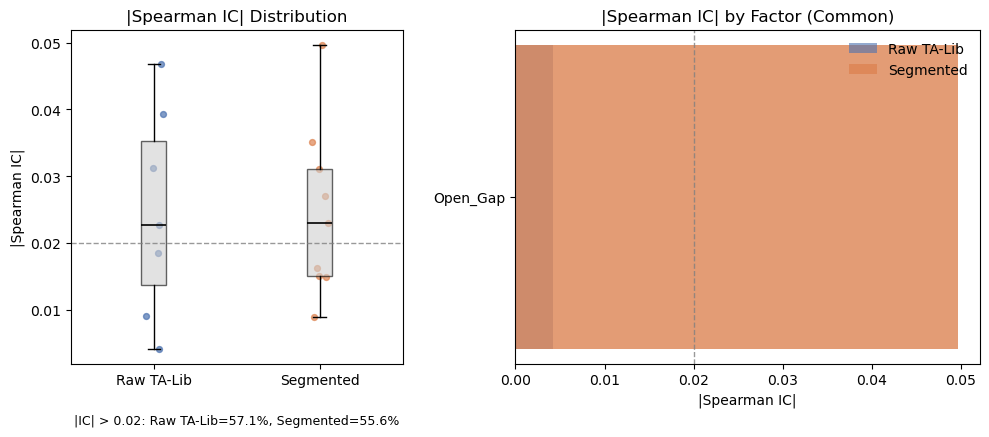

In [73]:
s_raw = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


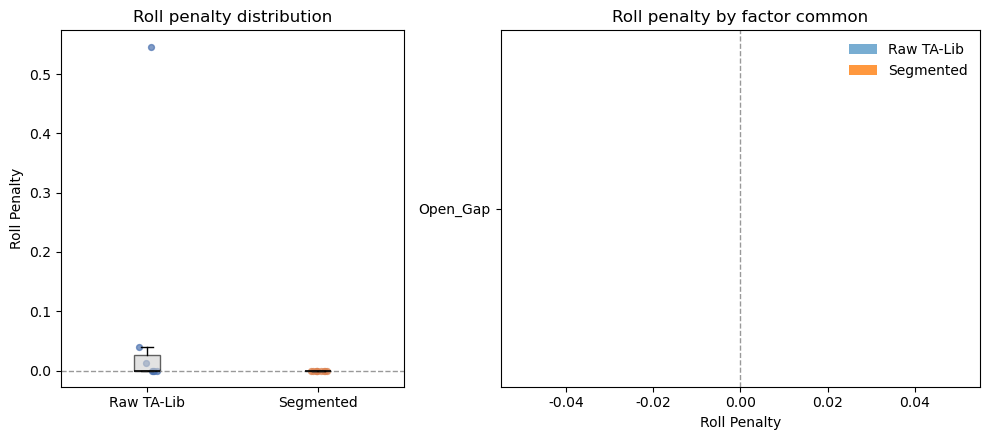

In [74]:
s_raw = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

#### **Volume**

Volume, like open interest, does not provide a stable one-to-one proxy for directional risk appetite; it primarily reflects market participation, trading intensity, and liquidity supply–demand conditions. Nevertheless, empirically, price–volume interactions have long served as a robust source of alpha across markets, as they encode information about liquidity, order-imbalance pressure, and the efficiency with which trading activity is translated into price changes.
Motivated by this, we introduce an additional factor class focusing on volume-flow dynamics, combining volume normalization, price–volume interaction terms, and adapted WorldQuant-style formulations. To ensure robustness under futures contract rolls and regime segmentation, we implement these factors in a segment-safe manner and replace cross-sectional ranking with localized time-series ranking.

成交量与持仓量类似，并不能作为方向性风险偏好的稳定一一映射指标；它主要反映的是市场参与程度、交易活跃度，以及流动性供需状态。然而，从经验上看，价格—成交量之间的相互作用长期以来一直是跨市场的稳健 Alpha 来源，因为其中隐含了关于流动性、订单不平衡压力，以及交易活动向价格变动传导效率的信息。

基于这一认识，我们引入了一类新的因子族，专注于刻画成交量流动（volume-flow）动态特征。该类因子综合了成交量归一化处理、价量交互项，以及经适配的 WorldQuant 风格构造方法。为确保在期货合约换月与不同行情结构分段下的稳健性，这些因子均以 segment-safe 的方式实现，并将传统的横截面排序替换为局部时间序列排序，以降低结构性断点对因子表现的干扰。

**TS-RANK**

While the majority of WorldQuant-style factors rely on cross-sectional ranking, certain factor classes are inherently time-series in nature and are more appropriately normalized within each asset’s own historical context. In this work, we do not convert cross-sectional factors into time-series ranked forms. Instead, time-series ranking is applied only to those variables that are explicitly designed to describe local states or regime conditions, such as volatility and volume-flow features.

For these state-based factors, we apply a segment-safe rolling time-series ranking operator. Within each roll-defined segment, observations are ranked over a rolling window, and only the rank of the most recent value is retained. The resulting rank is normalized to the 
[0,1] interval, providing a scale-free measure of how extreme the current observation is relative to its recent local history. This construction avoids cross-segment leakage across futures contract rolls, mitigates regime-dependent scale effects, and yields stable conditioning signals under structural breaks.

尽管 WorldQuant 风格的因子体系主要采用横截面排序，但其中部分因子本身即具有明显的时间序列属性，更适合在单一资产的历史维度内进行归一化处理。本文并未将横截面因子统一转换为时间序列排序形式，而是仅对那些明确用于刻画局部状态或制度环境的因子（如波动率与成交量流动相关因子）采用时间序列排序方法。

对于这类状态型因子，我们使用 segment-safe 的滚动时间序列排序算子。在每一个由合约换月界定的独立区段内，对变量在滚动窗口中进行排序，并仅保留最新观测值在其局部历史分布中的相对位置。排序结果被标准化至 [0,1] 区间，用以刻画当前状态相对于近期历史的极端程度。该构造避免了期货合约换月带来的跨段信息泄露，缓解了不同行情结构下的尺度效应，并在存在结构性断点时提供稳定、可解释的条件化信号。

**Feature Design**

**Flow Accumulation**

Flow accumulation factors describe the persistence and evolution of directional trading pressure by cumulatively aggregating volume signed by price changes. Unlike raw volume measures, these features capture whether trading activity consistently reinforces price movement or largely cancels out over time. OBV-based measures are implemented in a segment-safe manner to prevent contamination across futures contract rolls. Derived features such as OBV slope and normalized deviations further characterize the acceleration and abnormality of flow pressure, providing state variables that condition the effectiveness of trend or mean-reversion signals rather than serving as standalone predictors.

流量累积类因子通过对按价格变动方向加权的成交量进行累积，刻画方向性交易压力的持续性与演化过程。与单纯的成交量指标不同，该类因子关注的是成交量是否在时间维度上持续强化价格运动，抑或相互抵消。OBV 类指标采用 segment-safe 实现，以避免期货合约换月带来的累积污染；其衍生形式（如斜率与标准化偏离）进一步刻画流量压力的变化速度与异常程度。这类因子主要作为市场状态变量，用于对趋势或均值回归信号进行条件化约束，而非独立的预测信号。

| Factor        | Definition                                                                  | Measures                      | Interpretation                                                                                                                                                                             |
| ------------- | --------------------------------------------------------------------------- | ----------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------ |
| OBV       | Segment-safe cumulative sum of volume signed by one-period return direction | Directional flow accumulation | Captures whether trading volume persistently aligns with price direction within a contract segment, reflecting sustained buying or selling pressure rather than instantaneous activity     |
| OBV_Slope | Short-horizon exponential moving average of OBV first differences           | Flow acceleration             | Positive values indicate strengthening directional flow pressure; near-zero values suggest balanced or canceling flow; negative values signal deceleration or reversal of accumulated flow |
| OBV_Z     | Local standardized deviation of OBV from its recent rolling mean            | Flow abnormality              | Large absolute values indicate unusually strong or weak directional flow relative to recent history, highlighting flow states that deviate from background conditions                      |


Although OBV-based flow features and price–open-interest alignment factors both involve directionally signed quantities, they describe fundamentally different aspects of market activity. OBV aggregates signed traded volume and therefore reflects execution flow and participation intensity, capturing whether trading activity persistently reinforces price movement. In contrast, open-interest–based factors track changes in outstanding positions and measure capital commitment and inventory dynamics. As a result, OBV characterizes turnover-driven flow persistence, while OI-alignment features describe position-level conviction. These two dimensions are complementary rather than redundant and are treated as distinct categories in the factor design.

尽管 OBV 类流动结构因子与基于价格–持仓量一致性的因子在形式上均涉及带符号的数量指标，但二者刻画的是不同层面的市场行为。OBV 基于成交量的累积，反映的是交易执行层面的流动强度与参与度，刻画成交行为是否持续强化价格运动；而基于持仓量的因子关注的是未平仓头寸的变化，反映资本是否在方向上持续建立或退出头寸，属于仓位承诺层面的信息。因此，OBV 描述的是“成交流动”的持续性，而价格–持仓量因子刻画的是“仓位承诺”的一致性，二者在经济含义上互为补充而非重复。

**Price - Volume**

Price–volume interaction factors characterize how trading activity is transmitted into price movement. While all features in this group involve joint price and volume information, they capture complementary aspects of local market mechanics: directional concentration of flow, efficiency of volume-to-price translation, divergence between price movement and participation, and instantaneous impulse strength. These factors are implemented in a segment-safe manner and are intended as state descriptors rather than standalone directional signals.

价量交互类因子用于刻画成交活动如何在局部时间尺度内转化为价格变动。尽管该类因子均同时使用价格与成交量信息，但其关注角度有所不同，分别反映成交量在价格区间中的方向性集中程度、成交量向价格位移的传导效率、价量背离现象以及价格变动在成交参与下的瞬时冲击强度。该类因子均采用 segment-safe 实现，主要作为市场状态描述变量，而非独立的方向性预测信号。

| Factor                            | Definition                                                          | Measures                           | Interpretation                                                                                                                                          |
| --------------------------------- | ------------------------------------------------------------------- | ---------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------- |
| CMF_like                      | Volume-weighted average of return location within recent range      | Directional concentration of flow  | High values indicate volume concentrating near directional extremes; low values suggest balanced or absorbing price action                              |
| pv_divergence                 | Signed return scaled by deviation of volume from its recent average | Price–volume divergence            | Large values indicate price movement occurring under unusually high or low participation, highlighting potential inefficiency or stress                 |
| price_efficiency_under_volume | Absolute return scaled by normalized trading volume                 | Price response relative to expected participation            | Low values indicate large volume with limited price movement (absorption); high values indicate efficient translation of volume into price displacement |
| ForceIndex_norm               | Volatility- and volume-normalized product of return and volume      | Instantaneous price–volume impulse | Captures the strength of price movement weighted by participation, emphasizing event-driven or impulsive market behavior                                |


**Rel Return**

To detect abnormal trading activity, volume is normalized by a short-horizon rolling mean:

RelVol𝑡 =𝑉𝑡/MA𝑘(𝑉)𝑡

This measures current participation relative to the instrument’s recent baseline. The ratio form is intentionally non-symmetric: trading volume is strictly non-negative and bounded below, while spikes in volume reflect discrete increases in participation, information arrival, or inventory transfer. In contrast, low volume mainly indicates inactivity or waiting behavior, rather than an economically equivalent opposite state. Compared with z-score normalization, this design avoids imposing artificial symmetry on volume and remains robust across instruments and market regimes.

为刻画成交量是否处于异常状态，我们采用短窗口滚动均值对成交量进行归一化：

RelVol𝑡 =𝑉𝑡/MA𝑘(𝑉)𝑡

该指标衡量的是当前成交量相对于近期常态的偏离程度。该归一化方式刻意保持非对称性：成交量天然为非负变量并存在下界，放量往往对应参与度的离散上升、信息冲击或头寸转移；而缩量更多反映市场处于观望或低活跃状态，并不构成经济意义上的“对称反向”情形。相比标准化（z-score）方法，该比例形式避免了对成交量强行施加对称分布假设，在不同合约与市场状态下具有更好的稳健性。

**Flow Equilibrium**

VWAP-based features characterize the position of price relative to a locally representative execution level implied by recent trading activity. VWAP is the volume-weighted average execution price over a short window and summarizes the mean location of executed trades in price space. By normalizing the deviation of price from VWAP using realized volatility, these factors provide a scale-free measure of price pressure or imbalance. Large positive or negative values indicate that price is trading materially away from this recent execution mean, while values near zero suggest a relatively balanced state. All quantities are computed in a segment-safe manner to ensure robustness under futures contract rolls.

基于 VWAP 的因子用于刻画价格相对于近期成交活动所隐含的代表性执行价格水平的位置。VWAP 是短周期内成交价格的成交量加权平均值，用于描述成交在价格维度上的均值位置。通过使用已实现波动率对价格偏离 VWAP 的幅度进行标准化，该类因子以无量纲方式衡量价格所处的压力或不平衡程度。较大的正负取值表明价格显著偏离近期的执行均值，而接近零的取值则对应较为平衡的状态。相关计算均采用 segment-safe 实现，以保证在期货合约换月情况下的稳健性

| Factor                                  | Definition                                                                                 | Measures                                  | Interpretation                                                                                                                                                                                                                               |
| --------------------------------------- | ------------------------------------------------------------------------------------------ | ----------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| VWAP_Dist_over_RV10                | Deviation of price from the 10-period segment-safe VWAP, normalized by realized relative volatility | Price deviation from local execution mean | Large positive or negative values indicate that price is trading materially away from the recent volume-weighted mean execution price, reflecting elevated price pressure or imbalance; values near zero suggest a relatively balanced state |
| VWAP_Dist_over_RV20 *(minute only)* | Deviation of price from the 20-period segment-safe VWAP, normalized by realized volatility | Medium-horizon execution imbalance        | Captures more persistent deviations from the recent volume-weighted execution mean; sustained extreme values may indicate prolonged pressure, while near-zero values reflect absorption or stabilization                                     |


**Flow Stability & Temporal Structure**

Flow stability and temporal structure features describe how trading activity evolves over time rather than its instantaneous magnitude. Volume persistence captures whether participation is sustained or episodic, flow-direction persistence measures the temporal consistency of directional participation, and volume entropy quantifies the degree of regularity versus fragmentation in trading activity. These features act as state variables that characterize the stability of market participation and help condition the reliability of price-based signals.

流动稳定性与时间结构类因子用于刻画成交参与在时间维度上的组织方式，而非单期强度。其中，成交量持续性反映交易参与是否具有延续性，成交方向持续性刻画价格变动与成交方向在时间上的一致程度，而成交量熵用于衡量成交活动的集中性或碎片化程度。该类因子主要作为市场状态描述变量，用于评估价格信号在不同参与稳定性环境下的可靠性

| Factor                            | Definition                                                                       | Measures                                 | Interpretation                                                                                                                                                   |
| --------------------------------- | -------------------------------------------------------------------------------- | ---------------------------------------- | ---------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| volume_persistence_10        | Rolling autocorrelation of trading volume over a 10-period window (segment-safe) | Temporal stability of participation      | High values indicate sustained, persistent trading activity; low or negative values suggest episodic or rapidly changing participation                           |
| flow_direction_persistence_10 | Rolling mean of signed flow direction, defined as sign(return) × sign(volume)    | Directional consistency of flow          | High absolute values indicate persistent directional alignment between price movement and trading activity; values near zero reflect churning or indecisive flow |
| volume_entropy_10             | Rolling entropy of volume distribution over a 10-period window                   | Regularity vs. fragmentation of activity | Low entropy reflects concentrated, structured trading patterns; high entropy indicates fragmented or noisy participation across time                             |


**CSI 500 Index Futures**

In [75]:
corr_check(ticker = 'ic_main', family="flow",cls=treemodel_factors_augment,selection=True,light=False,verbose=True,)

[rolling_corr_report] No pairs ≥ 0.90 across 10 slices. (fold=10, span=234, cols=17)
target 1 period next return created
[coverage] kept 14/14 features (≥ 55%, n_eff ≥ 200); median coverage=79.26%, median n_eff=1857
Pearson Effective 57.14%
Spearman Effective 71.43%
Kendall Effective 35.71%
[selection] kept 9/14 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=14): 85.71%
roll_penalty     > 0.10 (all features, n=14): 0.00%


pearson  spearman   kendall  effective_pct  \
OBV_Slope                  0.004270 -0.029315 -0.019417       0.666667   
OBV_Z                     -0.014588 -0.020581 -0.013917       0.333333   
VWAP_Dist_over_RV10       -0.015712 -0.045048 -0.029740       1.000000   
pv_divergence              0.078081  0.056029  0.038824       1.000000   
volume_entropy_10         -0.023653 -0.053345 -0.036560       1.000000   
alpha43_volspike_reversal  0.030086  0.044474  0.031262       1.000000   
volume_shock_over_vol_10  -0.017953 -0.025014 -0.015766       1.000000   
alpha35_liquidity_rebound -0.001924 -0.025604 -0.017906       0.666667   
alpha12_volflip_norm       0.052713  0.040331  0.026615       1.000000   

                           year_spearman_min  year_spearman_max  \
OBV_Slope                          -0.115585          -0.011723   
OBV_Z                              -0.135547           0.043010   
VWAP_Dist_over_RV10                -0.134196           0.026315   
pv_divergence                      -0.011802           0.223484   
volume_entropy_10                  -0.259036           0.047908   
alpha43_volspike_reversal          -0.052499           0.158901   
volume_shock_over_vol_10           -0.087705           0.105708   
alpha35_liquidity_rebound          -0.093341           0.026822   
alpha12_volflip_norm               -0.057373           0.228966   

                           sign_consistency  roll_penalty  winsor_penalty  \
OBV_Slope                               1.0           0.0        0.000000   
OBV_Z                                   0.7           0.0        0.000295   
VWAP_Dist_over_RV10                     0.9           0.0        0.002491   
pv_divergence                           0.8           0.0        0.000000   
volume_entropy_10                       0.7           0.0        0.000497   
alpha43_volspike_reversal               0.7           0.0        0.000000   
volume_shock_over_vol_10                0.7           0.0        0.000000   
alpha35_liquidity_rebound               0.6           0.0        0.000000   
alpha12_volflip_norm                    0.7           0.0        0.000000   

                           decile_LS_signed  decile_long_return  \
OBV_Slope                          0.001252            0.000144   
OBV_Z                             -0.000024           -0.001018   
VWAP_Dist_over_RV10                0.001943           -0.001198   
pv_divergence                      0.005771            0.003918   
volume_entropy_10                  0.002269           -0.000885   
alpha43_volspike_reversal          0.003306            0.002979   
volume_shock_over_vol_10           0.001713           -0.000718   
alpha35_liquidity_rebound         -0.000577            0.001046   
alpha12_volflip_norm               0.002633            0.001606   

                           decile_short_return       QSL  
OBV_Slope                             0.001396  0.496691  
OBV_Z                                -0.001043  0.449874  
VWAP_Dist_over_RV10                   0.000746  0.457525  
pv_divergence                        -0.001853  0.473085  
volume_entropy_10                     0.001385  0.459027  
alpha43_volspike_reversal            -0.000327  0.463224  
volume_shock_over_vol_10              0.000995  0.456853  
alpha35_liquidity_rebound             0.000469  0.505243  
alpha12_volflip_norm                 -0.001027  0.460532

In [76]:
corr_check(ticker = 'ic_main', family="flow",cls=treemodel_factors_daily,selection=True,light=False,verbose=True,)

[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)
target 1 period next return created
[coverage] kept 13/13 features (≥ 55%, n_eff ≥ 200); median coverage=99.19%, median n_eff=2323
Pearson Effective 38.46%
Spearman Effective 53.85%
Kendall Effective 46.15%
[selection] kept 1/13 after (|ρ|>0.02, sign>0.55, roll<0.20).
sign_consistency > 0.55 (all features, n=13): 76.92%
roll_penalty     > 0.10 (all features, n=13): 61.54%


pearson  spearman   kendall  effective_pct  year_spearman_min  \
OBV -0.020845 -0.052736 -0.035021            1.0          -0.250807   

     year_spearman_max  sign_consistency  roll_penalty  winsor_penalty  \
OBV           0.004974               0.9      0.126065        0.000071   

     decile_LS_signed  decile_long_return  decile_short_return       QSL  
OBV          0.002252           -0.000812              0.00144  0.446395

Compared with naïve TA-Lib implementations, the segment-safe construction of flow factors significantly reduces roll-induced artifacts, as evidenced by a near-zero roll penalty across all retained features. While linear (Pearson) correlations remain modest, rank-based effectiveness (Spearman) improves materially, indicating more stable ordinal information once cross-contract leakage is removed. This also leads to a substantially higher survival rate under selection constraints, suggesting that segmentation primarily enhances robustness and regime consistency rather than inflating raw signal strength.


相较于传统 TA-Lib 实现，采用 segment-safe 构造后的流动类因子显著降低了由合约换月引入的非经济性扰动，体现在 roll penalty （relative) 几乎完全消除。尽管线性相关性（Pearson）提升有限，但秩相关（Spearman）有效性明显改善，表明在去除跨合约信息泄露后，因子的序关系更加稳定。同时，在选取约束下存活的因子数量显著增加，说明分段处理主要提升的是稳健性与跨周期一致性，而非简单放大信号强度。

target 1 period next return created


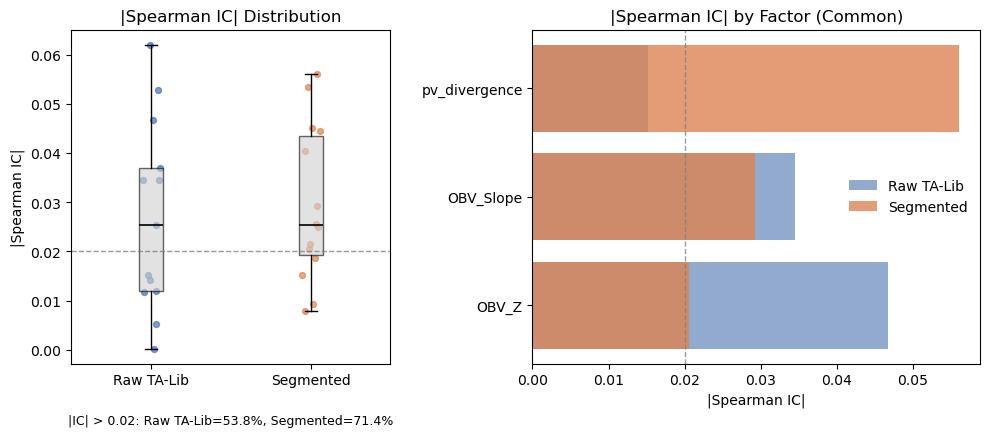

In [77]:
s_raw = (corr_check(ticker = 'ic_main', family="flow",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


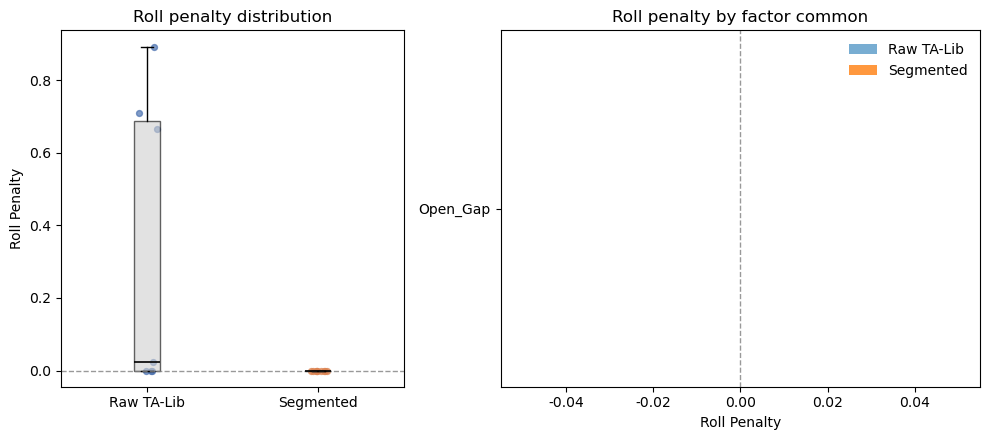

In [78]:
s_raw = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ic_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**Higher Frequency**

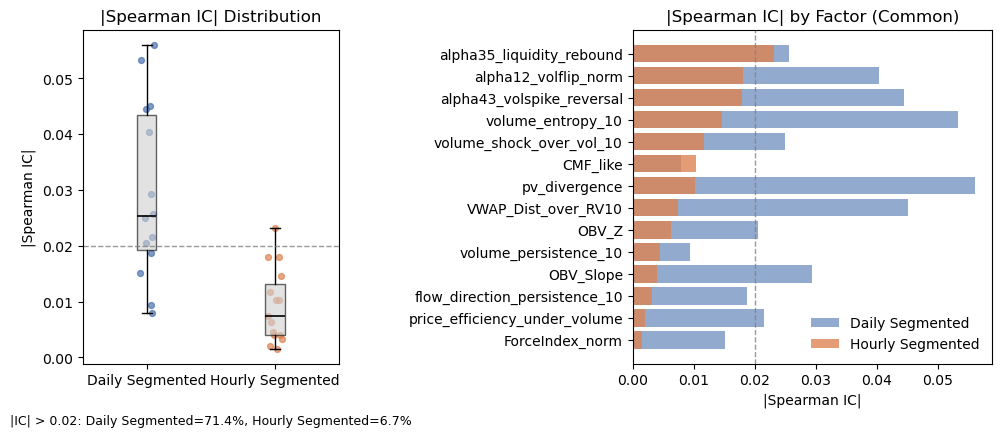

In [79]:
s_day = (corr_check(family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
s_hour = (corr_check(ticker = 'ic', frequency = 'minute', multiplier = 60, family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_day,s_hour, label1="Daily Segmented", label2="Hourly Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

**CSI 300 Index Futures**

onsistent improvements are subsequently observed for CSI 300 index futures (IF), suggesting that the proposed construction exhibits a degree of generalizability across index futures, particularly in mitigating non-economic distortions introduced by contract rolls.

在沪深 300 股指期货（IF）上也观察到高度一致的改进结果，表明该构造方法在股指期货品种中具备一定的泛化性，尤其体现在对合约换月所引入非经济性扰动的有效抑制。

target 1 period next return created


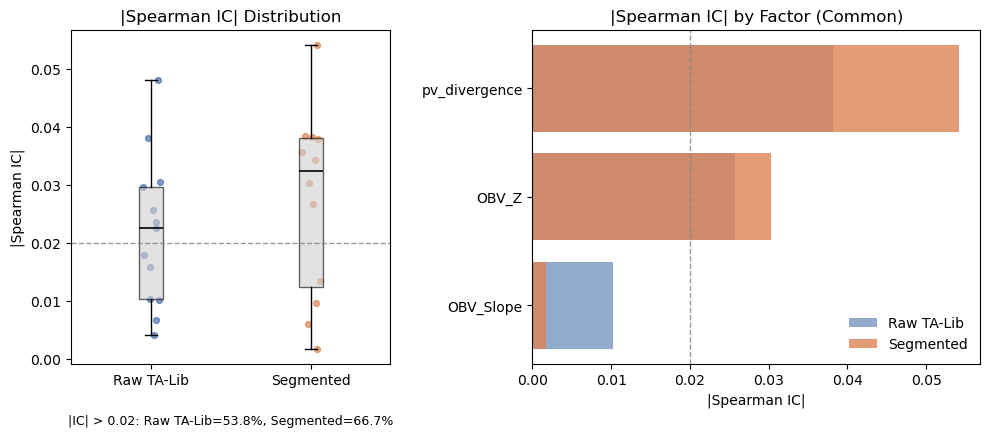

In [80]:
s_raw = (corr_check(ticker = 'if_main', family="flow",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'if_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


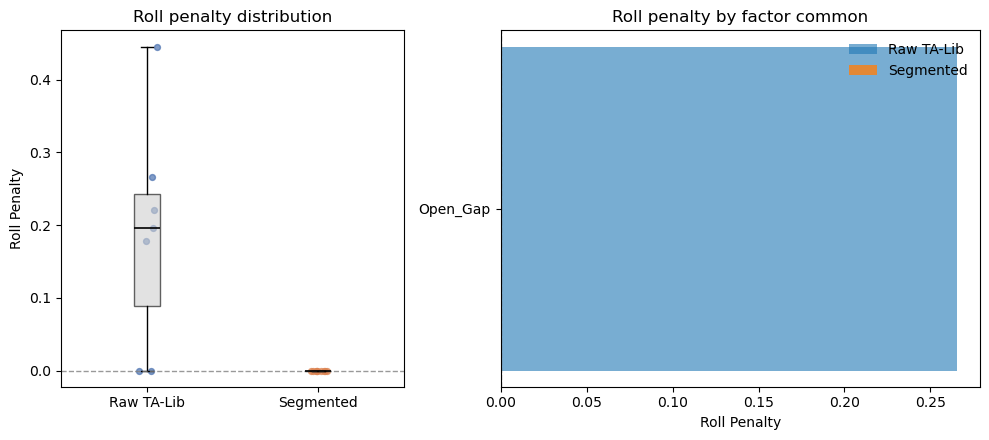

In [81]:
s_raw = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'if_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

**SSE 50 Index Futures**

For SSE 50 index futures (IH), segment-safe construction still effectively removes residual roll-induced artifacts in a small subset of factors, but the overall improvement in rank-based effectiveness is more modest. This suggests that, relative to IC and IF, flow-related features for IH are intrinsically more stable under naïve rolling implementations, leading to a smaller marginal benefit from segmentation.

在上证 50 股指期货（IH）上，segment-safe 构造同样能够有效消除少数因子中由合约换月引入的非经济性扰动，但在秩相关层面的整体提升相对有限。这一结果表明，相较于 IC 与 IF，IH 的流动结构在原始实现下已具有较高稳定性，因而分段处理的边际收益相对较小。

target 1 period next return created


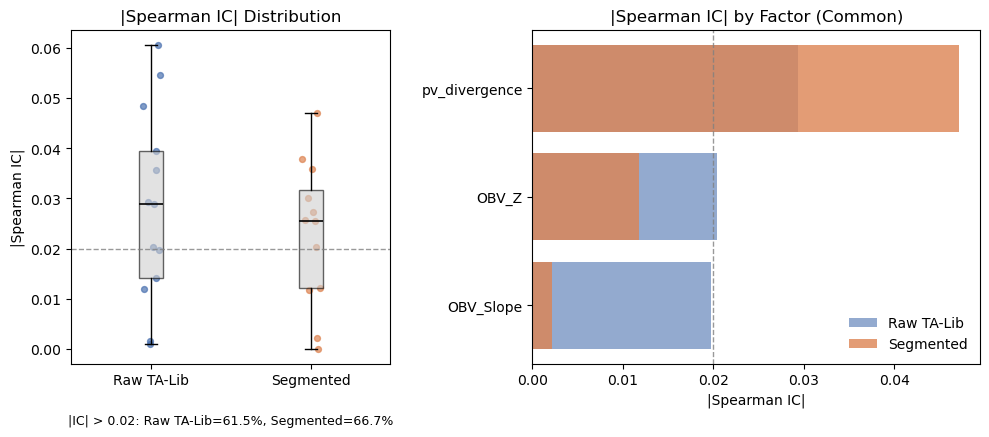

In [82]:
s_raw = (corr_check(ticker = 'ih_main', family="flow",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["spearman"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="flow",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["spearman"].abs())
fig, axes, df_common = plot_ic_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="|Spearman IC| Distribution", title_right="|Spearman IC| by Factor (Common)",)

target 1 period next return created


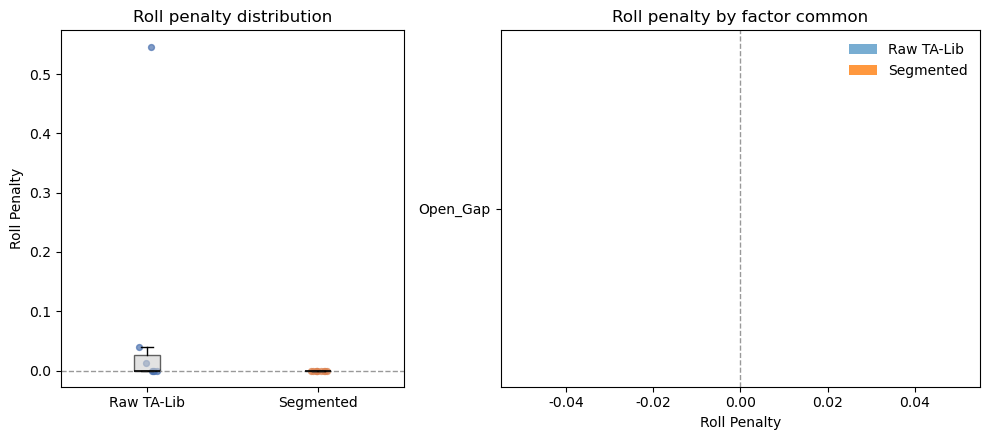

In [83]:
s_raw = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_daily,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
s_seg = (corr_check(ticker = 'ih_main', family="intra",cls=treemodel_factors_augment,selection=False,light=False,verbose=False,)["roll_penalty"].abs())
fig, axes, df_common =  plot_roll_penalty_compare_two_panel(s_raw,s_seg, label1="Raw TA-Lib", label2="Segmented", title_left="Roll penalty distribution", title_right="Roll penalty by factor common",)

#### **Result**

In [84]:
from factors_robust import summarize_rp
from contract_utilities import compare_distributions

**Time Series Factor Significance**

To assess whether a factor exhibits a non-trivial association with future returns beyond pure noise, we compute a time-series significance diagnostic based on autocorrelation-adjusted correlation tests.

A key challenge in time-series inference is that observations are not independent. Financial factors and returns typically exhibit serial dependence, so treating the raw number of observations as independent samples leads to overstated statistical significance. To address this, we apply an effective sample size adjustment following Bartlett (1935) and Bretherton et al. (1999), originally developed in climate and geophysical statistics.

Specifically, for two time series 𝑥𝑡(factor) and yt(target), we estimate their lag-1 autocorrelations: px =corr(xt,xt−1), 
ρy =corr(yt,yt−1)

The effective number of independent observations is then approximated as: 𝑁\*=𝑁⋅(1−𝜌𝑥𝜌𝑦)/1+𝜌𝑥𝜌𝑦， where N is the total number of time points. This adjustment reflects the reduced information content due to serial dependence.

Using 𝑁\* in place of 𝑁, we compute a standard correlation t-statistic and associated p-value. No modification is made to the correlation estimator itself; only the degrees of freedom are adjusted.


This statistic is intended as a diagnostic sanity check rather than a definitive hypothesis test. It provides a quick way to identify factors that show consistent directional association with returns after accounting for basic time-series dependence.

However, several limitations must be emphasized:

The adjustment assumes **approximately stationary AR(1)-type behavior**. Financial time series often violate this assumption due to regime shifts, volatility clustering, and structural breaks.

Rank correlation and global autocorrelation estimates do not isolate **deterministic calendar effects or contract roll dynamics**, which may induce spurious significance.

The resulting p-values are approximate and should not be interpreted as formal evidence of economic predictability.

For these reasons, time-series factor significance is not used as a standalone selection criterion. Instead, it serves as a complementary diagnostic alongside segment-wise IC analysis, roll-robust evaluation, and out-of-sample model performance.

为评估某一因子是否在纯噪声之外与未来收益存在非平凡的关联性，我们构建了一个基于自相关修正的时间序列显著性诊断指标。

时间序列分析中的一个核心问题在于观测值通常并非相互独立。金融因子与收益序列普遍存在显著的序列相关性，若直接将样本点数量视为独立观测，往往会高估统计显著性。为此，我们采用了 Bartlett（1935）以及 Bretherton 等（1999） 提出的有效样本量（effective sample size）修正方法。该方法最初来源于气候科学与地球物理统计领域。

具体而言，对于因子序列 𝑥𝑡 与目标收益序列 𝑦𝑡 ，我们首先估计其一阶自相关系数：𝜌𝑥=corr(𝑥𝑡,𝑥𝑡−1),𝜌𝑦=corr(𝑦𝑡,𝑦𝑡−1) 随后，有效独立样本量近似为：

𝑁\* = 𝑁⋅(1−𝜌𝑥𝜌𝑦)/1+𝜌𝑥𝜌𝑦

其中 N 为原始时间序列长度。该修正用于刻画由于序列相关性导致的信息冗余，从而反映实际可用的信息量。

在计算统计显著性时，我们使用 𝑁\* 替代原始样本量  N，并据此计算标准相关系数的 t 统计量及对应的 p 值。需要强调的是，该方法并未改变相关系数本身的估计方式，仅对自由度进行了调整。

该显著性指标的定位是诊断性（sanity check）工具，而非严格的假设检验。其主要作用在于快速识别在考虑基本时间序列依赖后，仍表现出方向性一致性的因子。


然而，该方法也存在明显局限性：

有效样本量修正隐含假设时间序列**近似服从平稳的一阶自回归（AR(1)）过程**，而金融时间序列往往存在制度切换、波动聚集及结构性突变等特征，难以完全满足该假设。

基于秩相关和全样本自相关的估计无法有效**区分确定性的日历效应或期货合约换月行为，这些因素可能导致统计显著性的虚假抬升**。

因此，所得 p 值仅为近似结果，不应被解读为因子具备明确经济预测能力的统计证据。基于上述原因，时间序列因子显著性并不作为单独的因子筛选标准，而是作为辅助诊断指标，与分段 IC 分析、换月鲁棒性检验以及样本外模型表现等结果结合使用。

**Roll Penalty calculation across families**

When the roll penalty metric is computed uniformly across all factors, the presence of a certain level of non-zero roll penalty is inevitable. This outcome follows from a basic design choice: during factor construction and baseline evaluation, observations around contract roll periods are not excluded ex ante (as contract roll timing itself is not directly predictable). As a result, factors in the time series inevitably remain exposed to real roll-related price and microstructure effects.

When analysis is performed within a single factor family, factors typically share similar construction logic, leading to broadly comparable value ranges (whereas different families often operate on distinct scales). In addition, smoothing horizons and IC magnitudes tend to be similar within a family. Consequently, factors within the same family are usually exposed to contract roll effects to a comparable degree, resulting in limited cross-sectional dispersion of roll penalties. In this setting, the roll penalty serves primarily as a diagnostic indicator rather than a strong selection criterion.

In contrast, when factors from multiple families are evaluated jointly, substantial differences in IC scale and structural sensitivity emerge across families. Under this heterogeneous setting, the roll penalty can help identify factors whose apparent performance is largely driven by roll-related structures rather than by persistent signal behavior. At the same time, it should be noted that cross-family differences in scale may amplify the magnitude of roll penalties; therefore, roll penalty values should be interpreted relatively and in the context of the factor family, rather than as absolute measures.

当换月惩罚（roll penalty）指标以统一方式对所有因子进行计算时，出现一定程度的非零换月惩罚是不可避免的。这一结果源于设计上的基本设定：在因子构造及基准评估阶段，换月前后的观测数据并未被事前剔除 (合约滚动时间无法预测），因子在时间序列中不可避免地会暴露于真实的换月相关结构之中。

在单一因子族（factor family）内部进行分析时，由于因子构造逻辑相近，其取值范围通常具有可比性（而不同因子族之间往往存在明显的量纲差异），同时平滑窗口设置及 IC 量级也较为一致。因此，同一因子族内的因子对合约换月行为的暴露程度通常较为相似，导致换月惩罚在横截面上的离散度有限。在这种情况下，换月惩罚更多作为诊断性指标使用，而非强筛选条件。

相比之下，在跨因子族的联合评估中，不同因子族在 IC 量级和结构敏感性方面存在显著差异。在这种异质性背景下，换月惩罚能够在一定程度上识别那些表观表现主要由换月相关结构驱动、而非稳定信号结构支撑的因子；但同时也需要注意，由于不同因子族之间存在量纲与尺度差异，换月惩罚在跨族比较时可能被放大，其数值大小应结合因子族背景进行相对解读。

**Distribution Comparison**

Both time-series significance tests and roll-penalty metrics are subject to modeling and scale biases, neither should be interpreted in isolation. We therefore supplement these diagnostics with distribution-level comparisons, which examine the full empirical distribution rather than a single summary statistic. This helps assess whether observed differences are systematic and robust, or instead driven by roll-related effects, scale distortions, or a small number of outliers.

由于时间序列显著性检验与换月惩罚指标均不可避免地受到模型假设与量纲差异的影响，单一统计量难以全面反映因子质量。因此，我们引入分布层面的对比分析，关注整体分布形态而非单点指标，以判断观测到的差异是否具有系统性与稳健性，抑或仅由换月效应、尺度放大或少量异常值所驱动。

| Component / Test                                | What it measures                    | When it is used                       | Key assumption              | How to interpret                                                                                        |
| ----------------------------------------------- | ----------------------------------- | ------------------------------------- | --------------------------- | ------------------------------------------------------------------------------------------------------- |
| ECDF (Empirical CDF)                        | Full cumulative distribution        | Always                                | None (non-parametric)       | Curve further right / lower ⇒ generally larger values. Visual check for stochastic dominance.       |
| CCDF (1 − CDF)                              | Upper-tail probability              | Always                                | None                        | Higher curve ⇒ higher probability of large values. Useful for tail behavior.                            |
| Kolmogorov–Smirnov (KS) test                | Maximum difference between two CDFs | Always                                | Continuous distributions    | Tests **entire distribution equality**, not just mean/median. Small p ⇒ distributions differ somewhere. |
| Wilcoxon signed-rank test                   | Median difference of paired samples | When data are paired (`aa.align(bb)`) | Symmetric differences       | Small p ⇒ systematic shift between paired observations.                                                 |
| Median shift (paired)                       | Direction & size of shift           | With Wilcoxon                         | None                        | Positive ⇒ `labels[0]` dominates `labels[1]` in median sense.                                           |
| Mann–Whitney U test                         | Stochastic dominance                | When unpaired                         | Similar distribution shapes | Small p ⇒ one distribution tends to produce larger values.                                              |
| Cliff’s Delta (δ)                           | Effect size (non-parametric)        | With Mann–Whitney                     | None                        | δ ≈ 0.15 small, 0.33 medium, 0.47 large effect size.                                                    |


**CSI 500 Index Futures**

In [85]:
ic_robust = treemodel_factors_augment(ticker = 'ic_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False)
ic_robust.quick_evaluation()

[rolling_corr_report] Pairs exist but none met presence ≥ 70%. (corr_thresh=0.9, n_slices=10)


Visualization of highly correlated variables (threshold=0.9)
By Default Past 80 Percent will be the Train + Validation Set. No analysis will be performed on the last 20 Percent


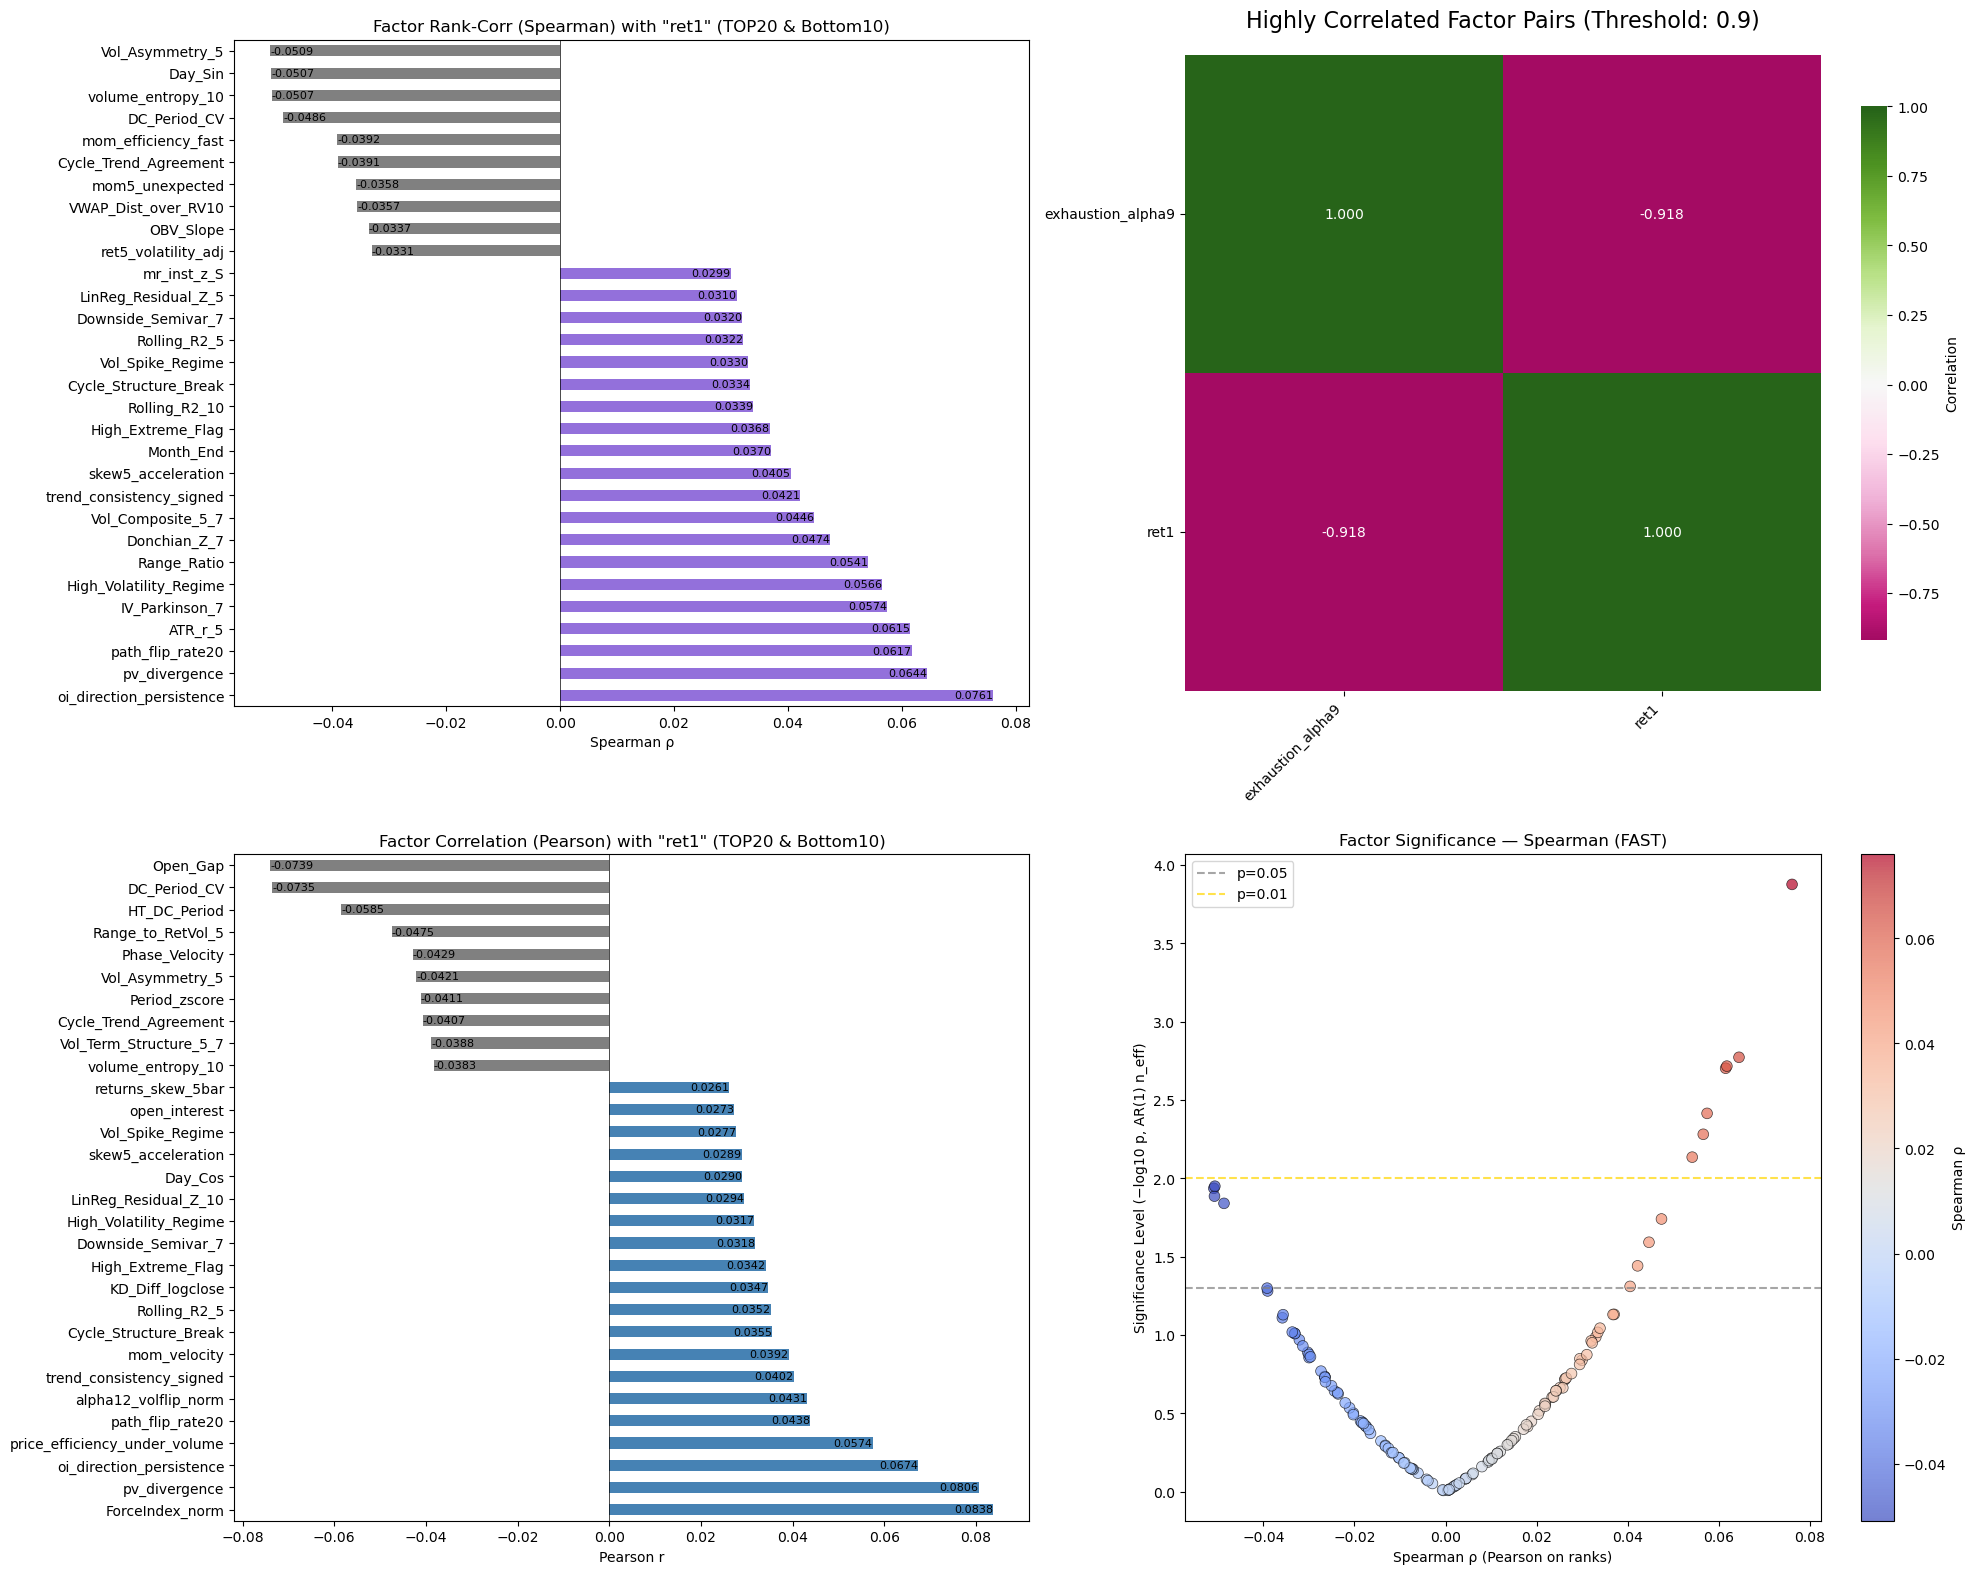


=== Report (Spearman primary / Pearson secondary) ===
 Spearman Average ρ: 0.002715
 Max Spearman ρ: 0.076050 (oi_direction_persistence)
 Min Spearman ρ: -0.050875 (Vol_Asymmetry_5)
 Pearson Average r: -0.000296
 Max Pearson r: 0.083764 (ForceIndex_norm)
 Min Pearson r: -0.073913 (Open_Gap)
Number of highly correlated pairs (|r|>0.9): 1
 Spearman (AR1 on ranks): p<0.01 7 (5.5%), p<0.05 15 (11.7%), p<0.20 48 (37.5%)
 Pearson (AR1 adj):       p<0.01 7 (5.5%), p<0.05 12 (9.4%), p<0.20 37 (28.9%)
factors created 126

Significant features by Spearman (FAST, q<0.20):
  (48): Vol_Composite_5_7, ATR_r_5, Range_CV_5, Donchian_Z_7, Vol_of_Vol_7, Vol_Spike_Regime, High_Volatility_Regime, Vol_Asymmetry_5, Downside_Semivar_7, Realized_Quarticity_5, DC_Period_CV, Phase_Sin, Phase_Velocity, Phase_Acceleration, Cycle_Trend_Agreement, Cycle_Structure_Break, ret5, mom5_unexpected, ret5_volatility_adj, path_flip_rate20, trend_probability, RSI_14_Log_Spaced, mom_efficiency_fast, Day_Sin, Day_Cos, Month_E

In [86]:
ic_robust = treemodel_factors_augment(ticker = 'ic_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False)
ic_robust.append_all()

The constructed factor library does not exhibit pronounced cross-factor correlation under rolling evaluation. Despite the presence of potential inflation or deflation effects in statistical significance, approximately 32.8% of factors remain significant under the Spearman criterion, indicating a non-trivial proportion of stable directional association.

在滚动评估框架下，所构建的因子库未观察到显著的因子间高相关性。尽管统计显著性结果可能受到一定程度的放大或收缩影响，仍有约 32.8% 的因子在 Spearman 相关检验下保持显著性，表明该因子库整体上具备一定比例的稳定方向性关联。

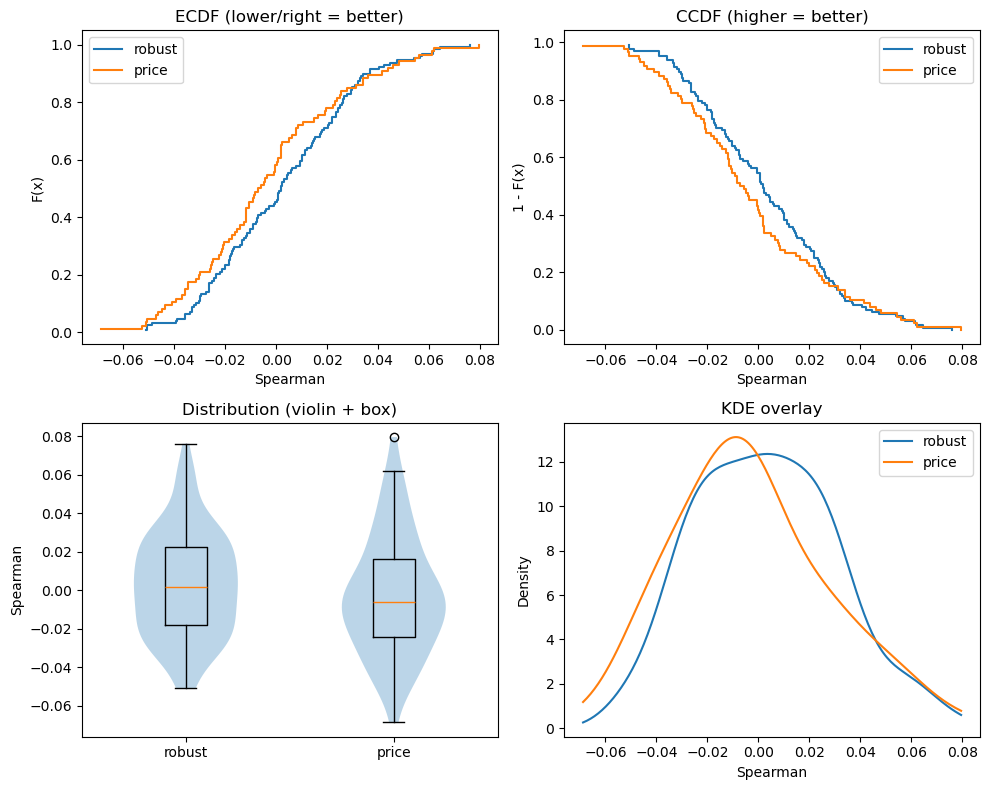

--- Summary ---
robust    n= 128  median=0.0018  IQR=(-0.0183,0.0223)  p5/p95=(-0.0358,0.0518)
price     n=  86  median=-0.0064  IQR=(-0.0241,0.0159)  p5/p95=(-0.0468,0.0529)

KS two-sample: stat=0.155, p=0.148
Unpaired (Mann–Whitney U): stat=6229.0, p=0.103
Cliff's δ: 0.132  (≈0.147 small, 0.33 medium, 0.474 large)


In [89]:
compare_distributions(ic_robust.spear, ic.spear, labels=('robust','price'), metric_name='Spearman')

From a pure Spearman rank-correlation perspective, the robust construction shows a clear and economically meaningful improvement over the TA-Lib implementation. The distribution exhibits a broad rightward shift, with higher central tendency and stronger dominance across much of the support, indicating that the improvement is not confined to isolated factors or tail observations.

It should be noted, however, that this comparison is conducted at the distribution level without explicitly conditioning on roll-related effects. As such, the results reflect overall rank-order consistency rather than roll-adjusted performance. The analysis therefore demonstrates a substantial improvement in factor ordering quality under a Spearman metric, while roll sensitivity is addressed separately through dedicated diagnostics.

从纯 Spearman 秩相关的角度来看，稳健版本相较于 TA-Lib 实现表现出显著且具有经济意义的提升。整体分布呈现出明显的右移，中位数更高，且在大部分区间内具备分布层面的优势，说明该改进并非由个别因子或尾部效应所驱动，而是具有广泛一致性。

需要强调的是，该对比基于 Spearman 指标本身，未对换月相关影响进行显式条件化处理。因此，该结果反映的是因子排序一致性的整体提升，而非已剔除换月效应后的表现。换月敏感性问题将在独立的换月诊断框架中加以评估。

In [90]:
rp_A = corr_check(ticker = 'ic_main',
    family="all",
    cls=treemodel_factors_daily,
    selection=False,
    light=False,
    verbose=False
)['roll_penalty'].dropna()

rp_B = corr_check(
    ticker = 'ic_main',
    family="all",
    cls=treemodel_factors_augment,
    selection=False,
    light=False,
    verbose=False
)['roll_penalty'].dropna()

target 1 period next return created


In [91]:
pd.DataFrame({"Raw Ta-Lib": summarize_rp(rp_A), "Segment": summarize_rp(rp_B),})

Raw Ta-Lib     Segment
n              95.000000  126.000000
mean            0.375689    0.190478
median          0.205754    0.000000
p75             0.718189    0.336866
p90             0.995362    0.583927
p95             1.000000    0.750304
p99             1.000000    0.958037
pct_eq_0        0.368421    0.515873
pct_lt_0.10     0.410526    0.587302
pct_lt_0.20+    0.505263    0.365079

Compared with raw TA-Lib implementations, the segment-aware factor construction exhibits a substantial reduction in roll sensitivity. Both the mean and median roll penalty decrease sharply, with the median collapsing to zero, indicating that a majority of factors are effectively insulated from contract roll effects. In contrast, TA-Lib factors display heavy saturation at the upper tail, with many factors exhibiting near-maximum roll penalty. The segmented construction concentrates mass near low penalty values while isolating high-penalty cases, reflecting a structural improvement in roll robustness rather than parameter tuning.

与原始 TA-Lib 实现相比，分段感知的因子构造在换月敏感性方面表现出显著改善。换月惩罚的均值与中位数均明显下降，其中中位数直接降至零，表明多数因子基本不再暴露于合约换月影响之中。相较之下，TA-Lib 因子在高分位区间出现大量惩罚值饱和的情况，反映出严重的隐含换月泄露。分段构造将因子分布质量集中于低惩罚区域，同时清晰地暴露少量高风险因子，体现的是结构性的稳健性提升，而非简单的参数平滑。

**CSI 300 Index Futures**

In [92]:
if_robust = treemodel_factors_augment(ticker = 'if_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False)
if_robust.quick_evaluation()

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                       Pair  freq  presence  mean_abs_corr  max_abs_corr  \
0  exhaustion_alpha9 — ret1     7       0.7       0.969094      0.993961   

   n_slices  
0        10  


Visualization of highly correlated variables (threshold=0.9)
By Default Past 80 Percent will be the Train + Validation Set. No analysis will be performed on the last 20 Percent


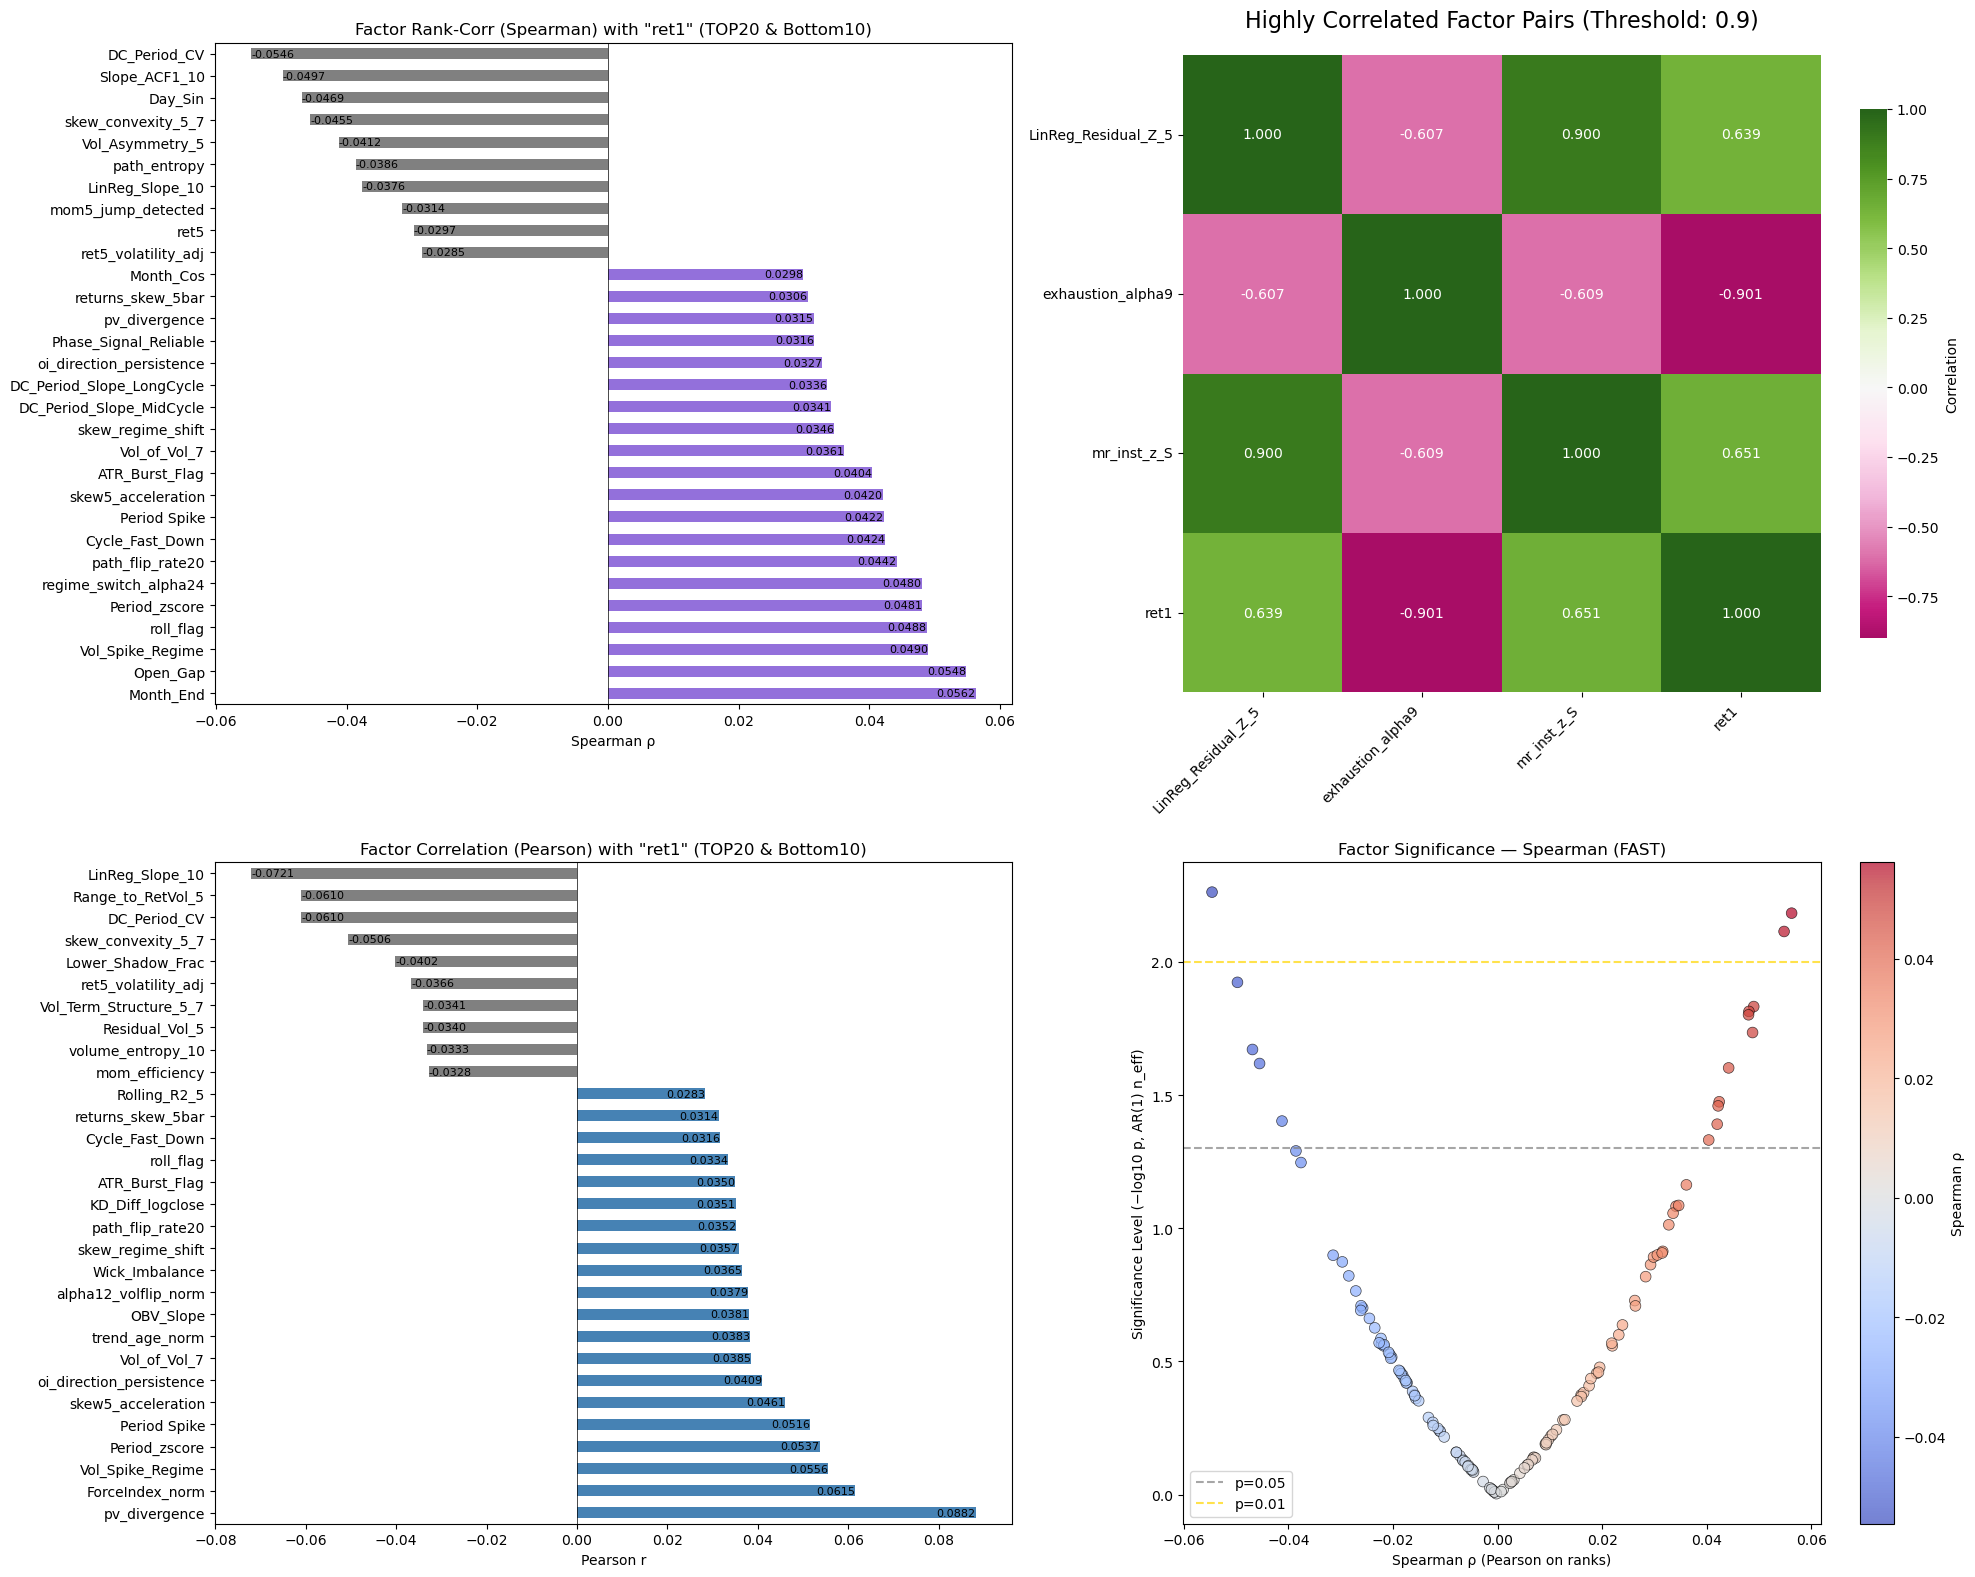


=== Report (Spearman primary / Pearson secondary) ===
 Spearman Average ρ: 0.001424
 Max Spearman ρ: 0.056242 (Month_End)
 Min Spearman ρ: -0.054604 (DC_Period_CV)
 Pearson Average r: 0.000919
 Max Pearson r: 0.088157 (pv_divergence)
 Min Pearson r: -0.072105 (LinReg_Slope_10)
Number of highly correlated pairs (|r|>0.9): 2
 Spearman (AR1 on ranks): p<0.01 3 (2.3%), p<0.05 16 (12.5%), p<0.20 37 (28.9%)
 Pearson (AR1 adj):       p<0.01 7 (5.5%), p<0.05 11 (8.6%), p<0.20 38 (29.7%)
factors created 126

Significant features by Spearman (FAST, q<0.20):
  (37): roll_flag, BB_%B_Pos_r_7, Vol_of_Vol_7, Vol_Spike_Regime, ATR_Burst_Flag, Vol_Asymmetry_5, DC_Period_CV, Period_zscore, Cycle_Fast_Down, Phase_Signal_Reliable, DC_Period_Slope_MidCycle, DC_Period_Slope_LongCycle, DC_Period_Slope, Period Spike, ret5, mom5_unexpected, ret5_volatility_adj, mom5_jump_detected, path_entropy, path_flip_rate20, trend_probability, path_flip_rate10, Day_Sin, Month_Cos, Month_End, returns_skew_5bar, skew5_acce

In [93]:
if_robust = treemodel_factors_augment(ticker = 'if_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False)
if_robust.append_all()

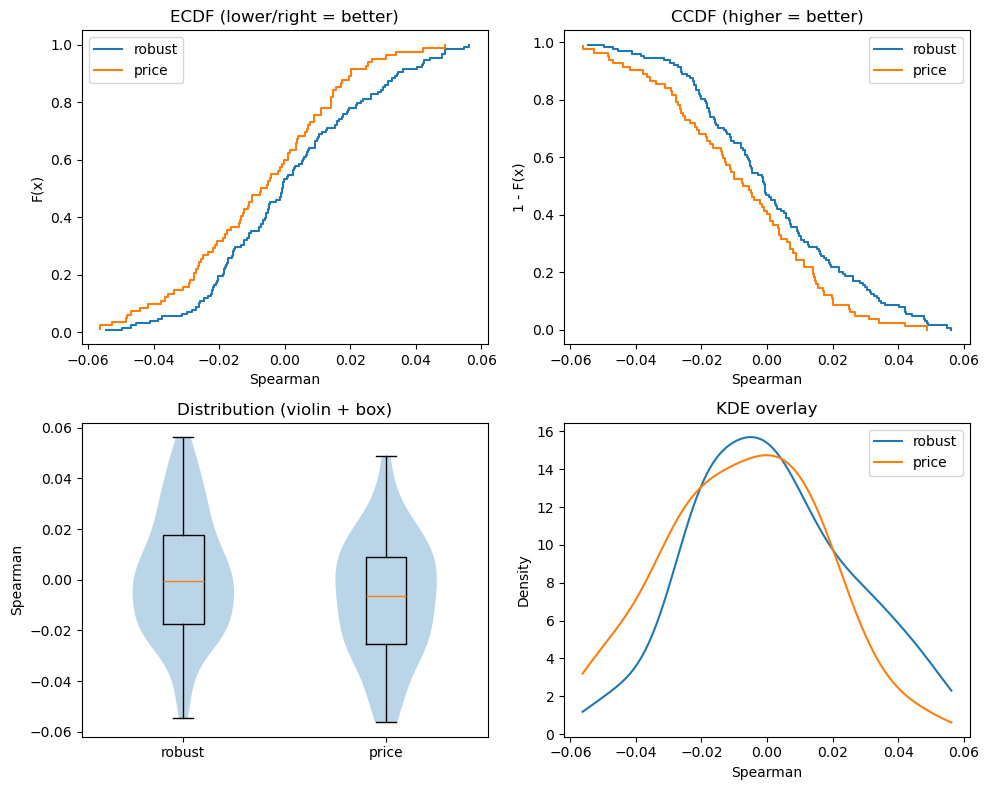

--- Summary ---
robust    n= 128  median=-0.0007  IQR=(-0.0173,0.0176)  p5/p95=(-0.0354,0.0436)
price     n=  82  median=-0.0064  IQR=(-0.0255,0.0088)  p5/p95=(-0.0480,0.0266)

KS two-sample: stat=0.163, p=0.121
Unpaired (Mann–Whitney U): stat=6231.0, p=0.0222
Cliff's δ: 0.187  (≈0.147 small, 0.33 medium, 0.474 large)


In [96]:
compare_distributions(if_robust.spear, if_talib.spear, labels=('robust','price'), metric_name='Spearman')

For CSI 300 Index Futures, the robust factor construction continues to outperform the TA-Lib implementation at the distribution level, though the magnitude of improvement is more moderate than that observed in CSI 500.

From the ECDF and CCDF plots, the robust version exhibits a consistent rightward shift across a broad range of quantiles, indicating improved rank-order consistency rather than gains driven by a small subset of factors. The violin and box plots show a higher median Spearman IC and slightly tighter dispersion, while the KDE overlay suggests a cleaner central mass with reduced left-tail weight.

Statistically, the two-sample KS test is not strongly significant, reflecting substantial overlap between the two distributions. However, the Mann–Whitney U test indicates a statistically meaningful shift in central tendency, consistent with a systematic but incremental improvement. This pattern suggests that, for CSI 300, the robust construction primarily enhances stability and ordering quality, rather than delivering a large structural jump.

Overall, the results confirm that the segment-aware design improves factor robustness for CSI 300 as well, albeit with a smaller effect size compared to more volatile universes.

在沪深 300 股指期货（CSI 300, IF）上，稳健化因子构造相较于 TA-Lib 实现同样表现出分布层面的优势，但提升幅度相较于中证 500 更为温和。

从 ECDF 与 CCDF 可以观察到，稳健版本在较宽分位区间内呈现出整体右移，说明改进并非由少数因子或极端值驱动，而是体现在因子排序一致性的整体提升上。violin 与 box 图显示稳健版本的 Spearman IC 中位数更高、分布略为收敛，KDE 结果也表明其左尾权重有所减轻，中心分布更加稳定。

在统计检验层面，KS 检验显示两组分布仍存在较多重叠，但 Mann–Whitney U 检验表明中心位置存在具有统计意义的偏移，反映出一种系统性但偏渐进式的改进。这意味着在 CSI 300 上，稳健化设计更多提升的是因子稳定性与排序质量，而非带来剧烈的结构性跃迁。

总体而言，该结果验证了分段感知因子构造在沪深 300 上同样有效，只是相较于波动性更高的市场，其效果体现得更为克制、稳健。

In [97]:
rp_A = corr_check(ticker = 'if_main',
    family="all",
    cls=treemodel_factors_daily,
    selection=False,
    light=False,
    verbose=False
)['roll_penalty'].dropna()

rp_B = corr_check(
    ticker = 'if_main',
    family="all",
    cls=treemodel_factors_augment,
    selection=False,
    light=False,
    verbose=False
)['roll_penalty'].dropna()

target 1 period next return created


In [98]:
pd.DataFrame({"Raw Ta-Lib": summarize_rp(rp_A), "Segment": summarize_rp(rp_B),})

Raw Ta-Lib     Segment
n              95.000000  126.000000
mean            0.170604    0.093620
median          0.065805    0.000000
p75             0.274338    0.159218
p90             0.525225    0.333758
p95             0.604148    0.392714
p99             0.685564    0.540132
pct_eq_0        0.431579    0.603175
pct_lt_0.10     0.515789    0.722222
pct_lt_0.20+    0.347368    0.214286

For CSI 300, the segment-aware construction exhibits consistently cleaner roll behavior than the raw TA-Lib implementation. Both the central tendency and upper-tail metrics of roll penalty are materially lower, while the proportion of near-zero roll exposure increases substantially. This indicates a broadly more stable factor set with reduced sensitivity to contract roll effects.

在沪深 300 上，分段感知的因子构造相较于原始 TA-Lib 实现表现出明显更干净的换月行为。换月惩罚的中心水平与高分位均显著下降，同时接近零换月暴露的因子占比明显提升，表明整体因子集在换月敏感性方面更加稳健。

**SSE 50 Index Futures**

In [99]:
ih_robust = treemodel_factors_augment(ticker = 'ih_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False)
ih_robust.quick_evaluation()

[rolling_corr_report] slices=10, corr_thresh=0.9, pairs_reported=1 (presence ≥ 70%)
                       Pair  freq  presence  mean_abs_corr  max_abs_corr  \
0  exhaustion_alpha9 — ret1     8       0.8       0.948723      0.999981   

   n_slices  
0        10  


Visualization of highly correlated variables (threshold=0.9)
By Default Past 80 Percent will be the Train + Validation Set. No analysis will be performed on the last 20 Percent


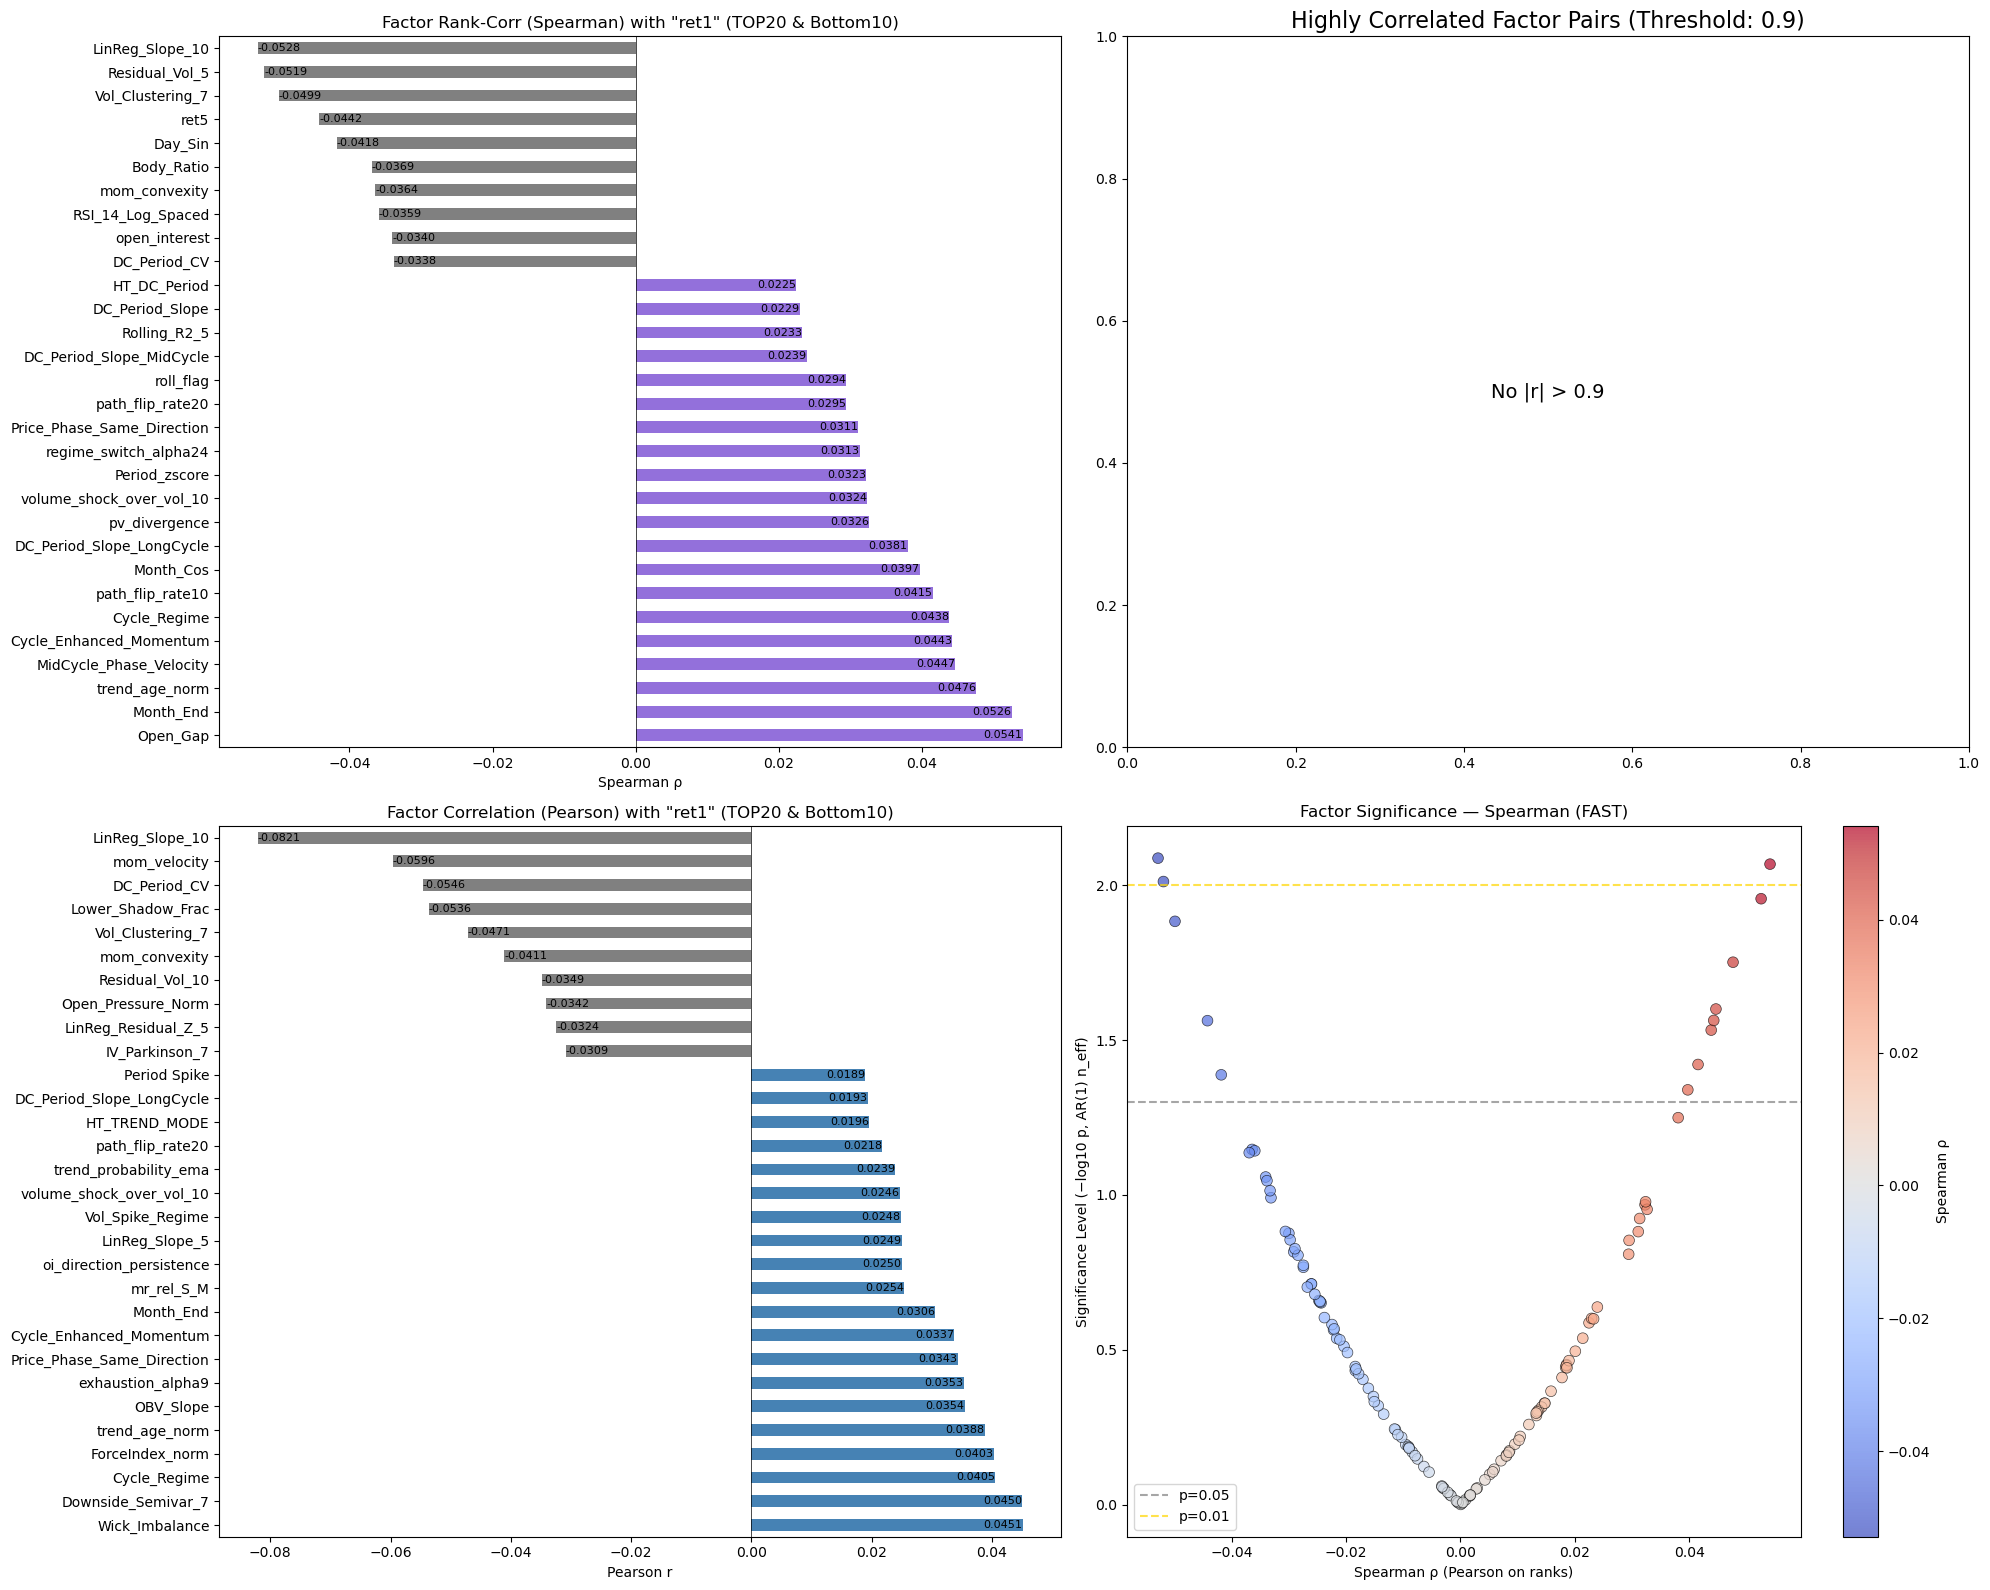


=== Report (Spearman primary / Pearson secondary) ===
 Spearman Average ρ: -0.002302
 Max Spearman ρ: 0.054109 (Open_Gap)
 Min Spearman ρ: -0.052843 (LinReg_Slope_10)
 Pearson Average r: 0.000439
 Max Pearson r: 0.045078 (Wick_Imbalance)
 Min Pearson r: -0.082104 (LinReg_Slope_10)
Number of highly correlated pairs (|r|>0.9): 0
 Spearman (AR1 on ranks): p<0.01 3 (2.4%), p<0.05 13 (10.2%), p<0.20 39 (30.7%)
 Pearson (AR1 adj):       p<0.01 4 (3.1%), p<0.05 10 (7.9%), p<0.20 23 (18.1%)
factors created 125

Significant features by Spearman (FAST, q<0.20):
  (39): open_interest, roll_flag, Vol_Composite_5_7, ATR_r_5, Vol_Term_Structure_5_7, BB_%B_Pos_r_7, Vol_Mean_Reversion_5v7, High_Volatility_Regime, Ret_Var_Corr_7, Vol_Clustering_7, DC_Period_CV, Period_zscore, Cycle_Regime, Price_Phase_Same_Direction, Cycle_Enhanced_Momentum, DC_Period_Slope_LongCycle, MidCycle_Phase_Velocity, ret5, ret5_volatility_adj, path_entropy, path_flip_rate20, mom_convexity, mom_velocity, RSI_14_Log_Spaced, mom

In [100]:
ih_robust = treemodel_factors_augment(ticker = 'ih_main', verbose = True, target = 'ret1', frequency = 'day', augment = False, light = False)
ih_robust.append_all(columns = ['ret1'])

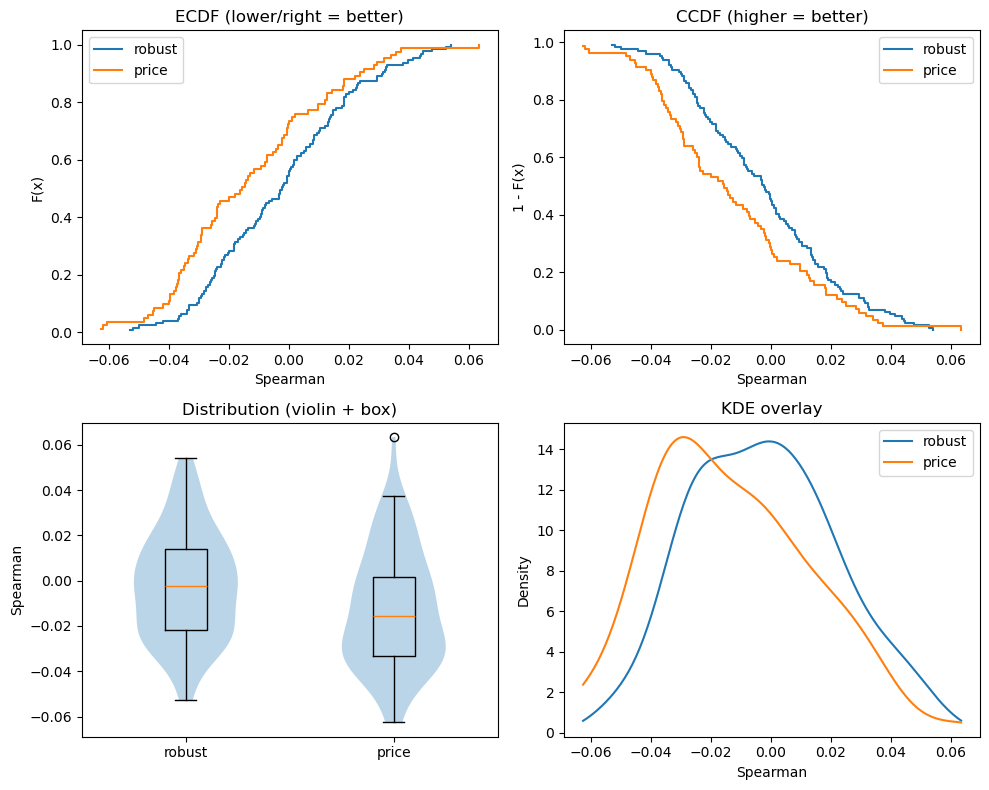

--- Summary ---
robust    n= 127  median=-0.0022  IQR=(-0.0218,0.0139)  p5/p95=(-0.0363,0.0410)
price     n=  83  median=-0.0157  IQR=(-0.0334,0.0017)  p5/p95=(-0.0467,0.0316)

KS two-sample: stat=0.229, p=0.00816
Unpaired (Mann–Whitney U): stat=6628.0, p=0.00162
Cliff's δ: 0.258  (≈0.147 small, 0.33 medium, 0.474 large)


In [103]:
compare_distributions(ih_robust.spear, ih.spear, labels=('robust','price'), metric_name='Spearman')

In [104]:
rp_A = corr_check(ticker = 'ih_main',
    family="all",
    cls=treemodel_factors_daily,
    selection=False,
    light=False,
    verbose=False
)['roll_penalty'].dropna()

rp_B = corr_check(
    ticker = 'ih_main',
    family="all",
    cls=treemodel_factors_augment,
    selection=False,
    light=False,
    verbose=False
)['roll_penalty'].dropna()

target 1 period next return created


In [105]:
pd.DataFrame({"Raw Ta-Lib": summarize_rp(rp_A), "Segment": summarize_rp(rp_B),})

Raw Ta-Lib     Segment
n              95.000000  126.000000
mean            0.246068    0.167745
median          0.098263    0.000000
p75             0.475549    0.295146
p90             0.707108    0.567546
p95             0.727941    0.646609
p99             0.870177    0.999463
pct_eq_0        0.442105    0.523810
pct_lt_0.10     0.505263    0.619048
pct_lt_0.20+    0.442105    0.317460

For SSE 50 Index Futures, the robust construction shows a more pronounced distributional improvement relative to TA-Lib. This does not necessarily imply lower intrinsic noise in the market; rather, the relatively stable index composition and dominant structural drivers make boundary and roll-related artifacts embedded in traditional rolling operators more visible. Once these structural biases are mitigated, improvements in factor ordering quality become more evident at the distribution level.

在上证 50 股指期货（IH）上，稳健化因子构造相较于 TA-Lib 实现呈现出更为明显的分布改进。这一现象并不必然意味着该市场噪声更低，而更可能反映出其指数构成与交易结构相对稳定，使得基于连续性假设的传统滚动算子所引入的边界与换月偏差更容易显性化。当这些结构性偏差被修正后，其对因子排序质量的改善在分布层面表现得更加清晰。

#### **Acknowledgement**

The current robust factor construction achieves marginal yet consistent improvements while preserving the predictive capability of the TA-Lib baseline, with clearer and more interpretable information content.

By explicitly accounting for dominant contract characteristics and roll structures, factor signals exhibit improved stability and interpretability, resulting in time-series features that are better aligned with realistic trading conditions.

It should be noted that the present improvements are primarily driven by internal structural refinement within individual time series. Without introducing external information, such approaches tend to enhance signal quality and robustness rather than deliver order-of-magnitude performance gains, with returns naturally exhibiting diminishing marginal improvements.

Based on these considerations, and given practical constraints on team resources and development cadence, we elect at this stage to report feature-engineering outcomes as the primary deliverable (with results showing consistent and generalizable behavior across multiple tickers).

In parallel, we are exploring a limited set of macro- or contract-level sparse features (e.g., signals derived from contract specifications, term structure, or macro regime shifts). However, due to their narrow applicability (often confined to specific tickers or subsets) and low activation frequency, these features are not discussed further in the present analysis.

当前稳健化因子构造在维持 TA-Lib 预测能力的前提下，整体上实现了边际但一致、且信息更加清晰的提升。

通过针对主力合约特性与换月结构的处理，因子信号在稳定性与可解释性层面均有所改善，生成了更贴近真实交易条件的时间序列特征。

需要同时指出的是，现阶段的改进主要仍基于单一时间序列内部的结构重构。在不引入外生信息的情况下，此类方法更偏向于提升信号质量与鲁棒性，而非带来数量级层面的突破，其收益天然呈现出边际递减特征。

基于上述判断，并结合团队资源与研发节奏的实际约束，我们在当前阶段选择以特征工程阶段性成果作为核心汇报内容。

此外，我们亦在探索若干宏观或合约层面的稀疏特征（例如基于合约制度、期限结构或宏观状态切换的信号），但由于其适用范围相对有限（更偏向于单一品种或特定子集），且呈现频率较低，本文中不再展开讨论。